# Model training tests

In [1]:
## Import packages
import os
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from rdkit import Chem
from flaml import AutoML
from rdkit.Chem import rdMolDescriptors as rd


DATAPATH = "../data"
FIGUREPATH = "../figures"

## PADEL Descriptors
The authors of the publication originally try PADEL descriptors to train the model. Because Padel descriptors take a long time to be calculated, we only do it once for the whole file and save the results

In [ ]:
from padelpy import from_smiles

df = pd.read_csv(os.path.join(DATAPATH, "training_set.csv"))
unprocessed_idx = []
descs = []
for i,smi in enumerate(df["smiles"].tolist()):
    try:
        descriptors = from_smiles([smi])
        descs.extend(descriptors)
    except:
        print(f"Error processing SMILES: {smi}")
        unprocessed_idx += [i]

descs_df = pd.DataFrame(descs)

df_ = df.drop(unprocessed_idx)
df_padel = pd.concat([df_.reset_index(drop=True), descs_df.reset_index(drop=True)], axis=1)


# Save the updated DataFrame to a CSV file
df_padel.to_csv(os.path.join(DATAPATH, "training_set_padel.csv"), index=False)

In [36]:
len(df_padel)

583

In [3]:
df = pd.read_csv(os.path.join(DATAPATH, "training_set_padel.csv"))
df = df[["smiles", "inchikey", "outcome"]]
df.to_csv(os.path.join(DATAPATH, "training_set_clean.csv"), index=False)

In [38]:
# TRAIN TEST SPLITS

# we will always use the same train test split, saving the files to reuse them
# ONLY RUN ONCE
from sklearn.model_selection import train_test_split

def random_split(df, size):
    indices = np.arange(len(df))
    X_train, X_test, y_train, y_test, i_train, i_test = train_test_split(df["smiles"], df["outcome"], indices, test_size=size, stratify=df["outcome"])
    train = df.iloc[i_train]
    test = df.iloc[i_test]
    return train, test

df = pd.read_csv(os.path.join(DATAPATH, "training_set_clean.csv"))
for i in range(5):
    train, test = random_split(df, 0.2)
    train.to_csv(os.path.join(DATAPATH, "train_test_splits", "train_{}.csv".format(i)))
    test.to_csv(os.path.join(DATAPATH, "train_test_splits", "test_{}.csv".format(i)))

[flaml.automl.logger: 01-30 08:52:18] {1679} INFO - task = classification
[flaml.automl.logger: 01-30 08:52:18] {1690} INFO - Evaluation method: cv
[flaml.automl.logger: 01-30 08:52:18] {1788} INFO - Minimizing error metric: 1-roc_auc
[flaml.automl.logger: 01-30 08:52:18] {1900} INFO - List of ML learners in AutoML Run: ['lgbm', 'rf', 'xgboost', 'extra_tree', 'xgb_limitdepth', 'lrl1']
[flaml.automl.logger: 01-30 08:52:18] {2218} INFO - iteration 0, current learner lgbm
[flaml.automl.logger: 01-30 08:52:21] {2345} INFO - Estimated sufficient time budget=30511s. Estimated necessary time budget=703s.
[flaml.automl.logger: 01-30 08:52:21] {2397} INFO -  at 4.6s,	estimator lgbm's best error=0.3899,	best estimator lgbm's best error=0.3899
[flaml.automl.logger: 01-30 08:52:21] {2218} INFO - iteration 1, current learner lgbm
[flaml.automl.logger: 01-30 08:52:22] {2397} INFO -  at 5.8s,	estimator lgbm's best error=0.3685,	best estimator lgbm's best error=0.3685
[flaml.automl.logger: 01-30 08:52

[flaml.automl.logger: 01-30 08:53:56] {2218} INFO - iteration 34, current learner lgbm
[flaml.automl.logger: 01-30 08:53:59] {2397} INFO -  at 102.4s,	estimator lgbm's best error=0.3070,	best estimator lgbm's best error=0.3070
[flaml.automl.logger: 01-30 08:53:59] {2218} INFO - iteration 35, current learner lgbm
[flaml.automl.logger: 01-30 08:54:03] {2397} INFO -  at 106.3s,	estimator lgbm's best error=0.2997,	best estimator lgbm's best error=0.2997
[flaml.automl.logger: 01-30 08:54:03] {2218} INFO - iteration 36, current learner xgboost
[flaml.automl.logger: 01-30 08:54:05] {2397} INFO -  at 108.8s,	estimator xgboost's best error=0.3372,	best estimator lgbm's best error=0.2997
[flaml.automl.logger: 01-30 08:54:05] {2218} INFO - iteration 37, current learner rf
[flaml.automl.logger: 01-30 08:54:07] {2397} INFO -  at 110.5s,	estimator rf's best error=0.3722,	best estimator lgbm's best error=0.2997
[flaml.automl.logger: 01-30 08:54:07] {2218} INFO - iteration 38, current learner xgboost


[flaml.automl.logger: 01-30 08:57:39] {2218} INFO - iteration 70, current learner xgboost
[flaml.automl.logger: 01-30 08:57:54] {2397} INFO -  at 337.5s,	estimator xgboost's best error=0.3140,	best estimator lgbm's best error=0.2847
[flaml.automl.logger: 01-30 08:57:54] {2218} INFO - iteration 71, current learner lgbm
[flaml.automl.logger: 01-30 08:58:31] {2397} INFO -  at 374.7s,	estimator lgbm's best error=0.2821,	best estimator lgbm's best error=0.2821
[flaml.automl.logger: 01-30 08:58:31] {2218} INFO - iteration 72, current learner extra_tree
[flaml.automl.logger: 01-30 08:58:33] {2397} INFO -  at 376.2s,	estimator extra_tree's best error=0.3702,	best estimator lgbm's best error=0.2821
[flaml.automl.logger: 01-30 08:58:33] {2218} INFO - iteration 73, current learner xgboost
[flaml.automl.logger: 01-30 08:58:39] {2397} INFO -  at 382.2s,	estimator xgboost's best error=0.3140,	best estimator lgbm's best error=0.2821
[flaml.automl.logger: 01-30 08:58:39] {2218} INFO - iteration 74, cu

/home/leila/miniconda3/envs/dili_env/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,
/home/leila/miniconda3/envs/dili_env/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,


[flaml.automl.logger: 01-30 09:02:17] {2397} INFO -  at 600.2s,	estimator lrl1's best error=0.4881,	best estimator lgbm's best error=0.2821


/home/leila/miniconda3/envs/dili_env/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,


[flaml.automl.logger: 01-30 09:02:21] {2627} INFO - retrain lgbm for 4.5s
[flaml.automl.logger: 01-30 09:02:21] {2630} INFO - retrained model: LGBMClassifier(colsample_bytree=0.8913156093807983,
               learning_rate=0.0331397793506018, max_bin=255,
               min_child_samples=7, n_estimators=1, n_jobs=-1, num_leaves=63,
               reg_alpha=0.035846156270917195, reg_lambda=7.8440389118591805,
               verbose=-1)
[flaml.automl.logger: 01-30 09:02:21] {1930} INFO - fit succeeded
[flaml.automl.logger: 01-30 09:02:21] {1931} INFO - Time taken to find the best model: 374.6724007129669
[flaml.automl.logger: 01-30 09:02:23] {1679} INFO - task = classification
[flaml.automl.logger: 01-30 09:02:23] {1690} INFO - Evaluation method: cv
[flaml.automl.logger: 01-30 09:02:23] {1788} INFO - Minimizing error metric: 1-roc_auc
[flaml.automl.logger: 01-30 09:02:23] {1900} INFO - List of ML learners in AutoML Run: ['lgbm', 'rf', 'xgboost', 'extra_tree', 'xgb_limitdepth', 'lrl1']
[

[flaml.automl.logger: 01-30 09:03:16] {2218} INFO - iteration 31, current learner lgbm
[flaml.automl.logger: 01-30 09:03:17] {2397} INFO -  at 55.7s,	estimator lgbm's best error=0.2984,	best estimator lgbm's best error=0.2984
[flaml.automl.logger: 01-30 09:03:17] {2218} INFO - iteration 32, current learner lgbm
[flaml.automl.logger: 01-30 09:03:19] {2397} INFO -  at 57.0s,	estimator lgbm's best error=0.2984,	best estimator lgbm's best error=0.2984
[flaml.automl.logger: 01-30 09:03:19] {2218} INFO - iteration 33, current learner extra_tree
[flaml.automl.logger: 01-30 09:03:20] {2397} INFO -  at 58.5s,	estimator extra_tree's best error=0.3467,	best estimator lgbm's best error=0.2984
[flaml.automl.logger: 01-30 09:03:20] {2218} INFO - iteration 34, current learner lgbm
[flaml.automl.logger: 01-30 09:03:21] {2397} INFO -  at 59.7s,	estimator lgbm's best error=0.2968,	best estimator lgbm's best error=0.2968
[flaml.automl.logger: 01-30 09:03:21] {2218} INFO - iteration 35, current learner rf

[flaml.automl.logger: 01-30 09:05:00] {2397} INFO -  at 158.4s,	estimator extra_tree's best error=0.3001,	best estimator xgboost's best error=0.2732
[flaml.automl.logger: 01-30 09:05:00] {2218} INFO - iteration 67, current learner xgboost
[flaml.automl.logger: 01-30 09:05:03] {2397} INFO -  at 161.1s,	estimator xgboost's best error=0.2732,	best estimator xgboost's best error=0.2732
[flaml.automl.logger: 01-30 09:05:03] {2218} INFO - iteration 68, current learner lgbm
[flaml.automl.logger: 01-30 09:05:04] {2397} INFO -  at 162.4s,	estimator lgbm's best error=0.2968,	best estimator xgboost's best error=0.2732
[flaml.automl.logger: 01-30 09:05:04] {2218} INFO - iteration 69, current learner xgboost
[flaml.automl.logger: 01-30 09:05:10] {2397} INFO -  at 168.7s,	estimator xgboost's best error=0.2732,	best estimator xgboost's best error=0.2732
[flaml.automl.logger: 01-30 09:05:10] {2218} INFO - iteration 70, current learner extra_tree
[flaml.automl.logger: 01-30 09:05:13] {2397} INFO -  at 

[flaml.automl.logger: 01-30 09:07:10] {2397} INFO -  at 288.5s,	estimator xgboost's best error=0.2732,	best estimator xgboost's best error=0.2732
[flaml.automl.logger: 01-30 09:07:10] {2218} INFO - iteration 101, current learner xgb_limitdepth
[flaml.automl.logger: 01-30 09:07:17] {2397} INFO -  at 295.7s,	estimator xgb_limitdepth's best error=0.2883,	best estimator xgboost's best error=0.2732
[flaml.automl.logger: 01-30 09:07:17] {2218} INFO - iteration 102, current learner extra_tree
[flaml.automl.logger: 01-30 09:07:19] {2397} INFO -  at 297.6s,	estimator extra_tree's best error=0.3001,	best estimator xgboost's best error=0.2732
[flaml.automl.logger: 01-30 09:07:19] {2218} INFO - iteration 103, current learner lgbm
[flaml.automl.logger: 01-30 09:07:34] {2397} INFO -  at 312.3s,	estimator lgbm's best error=0.2968,	best estimator xgboost's best error=0.2732
[flaml.automl.logger: 01-30 09:07:34] {2218} INFO - iteration 104, current learner extra_tree
[flaml.automl.logger: 01-30 09:07:3

[flaml.automl.logger: 01-30 09:09:16] {2397} INFO -  at 414.9s,	estimator rf's best error=0.3085,	best estimator xgboost's best error=0.2732
[flaml.automl.logger: 01-30 09:09:16] {2218} INFO - iteration 136, current learner xgb_limitdepth
[flaml.automl.logger: 01-30 09:09:20] {2397} INFO -  at 418.9s,	estimator xgb_limitdepth's best error=0.2883,	best estimator xgboost's best error=0.2732
[flaml.automl.logger: 01-30 09:09:20] {2218} INFO - iteration 137, current learner rf
[flaml.automl.logger: 01-30 09:09:23] {2397} INFO -  at 421.4s,	estimator rf's best error=0.3040,	best estimator xgboost's best error=0.2732
[flaml.automl.logger: 01-30 09:09:23] {2218} INFO - iteration 138, current learner lgbm
[flaml.automl.logger: 01-30 09:09:24] {2397} INFO -  at 422.5s,	estimator lgbm's best error=0.2953,	best estimator xgboost's best error=0.2732
[flaml.automl.logger: 01-30 09:09:24] {2218} INFO - iteration 139, current learner extra_tree
[flaml.automl.logger: 01-30 09:09:26] {2397} INFO -  at 

/home/leila/miniconda3/envs/dili_env/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,
/home/leila/miniconda3/envs/dili_env/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,
/home/leila/miniconda3/envs/dili_env/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,
/home/leila/miniconda3/envs/dili_env/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,


[flaml.automl.logger: 01-30 09:10:34] {2397} INFO -  at 492.9s,	estimator lrl1's best error=0.5217,	best estimator xgboost's best error=0.2732
[flaml.automl.logger: 01-30 09:10:34] {2218} INFO - iteration 160, current learner lrl1


/home/leila/miniconda3/envs/dili_env/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,
/home/leila/miniconda3/envs/dili_env/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,
/home/leila/miniconda3/envs/dili_env/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,
/home/leila/miniconda3/envs/dili_env/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,
/home/leila/miniconda3/envs/dili_env/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not conver

[flaml.automl.logger: 01-30 09:10:41] {2397} INFO -  at 499.5s,	estimator lrl1's best error=0.5217,	best estimator xgboost's best error=0.2732
[flaml.automl.logger: 01-30 09:10:41] {2218} INFO - iteration 161, current learner lrl1


/home/leila/miniconda3/envs/dili_env/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,
/home/leila/miniconda3/envs/dili_env/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,
/home/leila/miniconda3/envs/dili_env/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,
/home/leila/miniconda3/envs/dili_env/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,
/home/leila/miniconda3/envs/dili_env/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not conver

[flaml.automl.logger: 01-30 09:10:47] {2397} INFO -  at 505.3s,	estimator lrl1's best error=0.5217,	best estimator xgboost's best error=0.2732
[flaml.automl.logger: 01-30 09:10:47] {2218} INFO - iteration 162, current learner xgb_limitdepth


/home/leila/miniconda3/envs/dili_env/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,


[flaml.automl.logger: 01-30 09:10:49] {2397} INFO -  at 507.2s,	estimator xgb_limitdepth's best error=0.2883,	best estimator xgboost's best error=0.2732
[flaml.automl.logger: 01-30 09:10:49] {2218} INFO - iteration 163, current learner lrl1


/home/leila/miniconda3/envs/dili_env/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,
/home/leila/miniconda3/envs/dili_env/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,
/home/leila/miniconda3/envs/dili_env/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,
/home/leila/miniconda3/envs/dili_env/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,


[flaml.automl.logger: 01-30 09:10:54] {2397} INFO -  at 512.3s,	estimator lrl1's best error=0.5215,	best estimator xgboost's best error=0.2732
[flaml.automl.logger: 01-30 09:10:54] {2218} INFO - iteration 164, current learner xgb_limitdepth


/home/leila/miniconda3/envs/dili_env/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,


[flaml.automl.logger: 01-30 09:10:57] {2397} INFO -  at 515.4s,	estimator xgb_limitdepth's best error=0.2883,	best estimator xgboost's best error=0.2732
[flaml.automl.logger: 01-30 09:10:57] {2218} INFO - iteration 165, current learner xgb_limitdepth
[flaml.automl.logger: 01-30 09:11:00] {2397} INFO -  at 518.2s,	estimator xgb_limitdepth's best error=0.2883,	best estimator xgboost's best error=0.2732
[flaml.automl.logger: 01-30 09:11:00] {2218} INFO - iteration 166, current learner xgboost
[flaml.automl.logger: 01-30 09:11:02] {2397} INFO -  at 520.3s,	estimator xgboost's best error=0.2732,	best estimator xgboost's best error=0.2732
[flaml.automl.logger: 01-30 09:11:02] {2218} INFO - iteration 167, current learner xgboost
[flaml.automl.logger: 01-30 09:11:07] {2397} INFO -  at 525.1s,	estimator xgboost's best error=0.2732,	best estimator xgboost's best error=0.2732
[flaml.automl.logger: 01-30 09:11:07] {2218} INFO - iteration 168, current learner extra_tree
[flaml.automl.logger: 01-30 

[flaml.automl.logger: 01-30 09:12:23] {1930} INFO - fit succeeded
[flaml.automl.logger: 01-30 09:12:23] {1931} INFO - Time taken to find the best model: 93.69735097885132
[flaml.automl.logger: 01-30 09:12:24] {1679} INFO - task = classification
[flaml.automl.logger: 01-30 09:12:24] {1690} INFO - Evaluation method: cv
[flaml.automl.logger: 01-30 09:12:24] {1788} INFO - Minimizing error metric: 1-roc_auc
[flaml.automl.logger: 01-30 09:12:24] {1900} INFO - List of ML learners in AutoML Run: ['lgbm', 'rf', 'xgboost', 'extra_tree', 'xgb_limitdepth', 'lrl1']
[flaml.automl.logger: 01-30 09:12:24] {2218} INFO - iteration 0, current learner lgbm
[flaml.automl.logger: 01-30 09:12:25] {2345} INFO - Estimated sufficient time budget=13412s. Estimated necessary time budget=309s.
[flaml.automl.logger: 01-30 09:12:25] {2397} INFO -  at 2.6s,	estimator lgbm's best error=0.2872,	best estimator lgbm's best error=0.2872
[flaml.automl.logger: 01-30 09:12:25] {2218} INFO - iteration 1, current learner lgbm


[flaml.automl.logger: 01-30 09:13:10] {2218} INFO - iteration 33, current learner extra_tree
[flaml.automl.logger: 01-30 09:13:13] {2397} INFO -  at 49.7s,	estimator extra_tree's best error=0.2689,	best estimator extra_tree's best error=0.2689
[flaml.automl.logger: 01-30 09:13:13] {2218} INFO - iteration 34, current learner lgbm
[flaml.automl.logger: 01-30 09:13:13] {2397} INFO -  at 50.6s,	estimator lgbm's best error=0.2710,	best estimator extra_tree's best error=0.2689
[flaml.automl.logger: 01-30 09:13:13] {2218} INFO - iteration 35, current learner rf
[flaml.automl.logger: 01-30 09:13:15] {2397} INFO -  at 52.1s,	estimator rf's best error=0.3134,	best estimator extra_tree's best error=0.2689
[flaml.automl.logger: 01-30 09:13:15] {2218} INFO - iteration 36, current learner extra_tree
[flaml.automl.logger: 01-30 09:13:17] {2397} INFO -  at 53.7s,	estimator extra_tree's best error=0.2689,	best estimator extra_tree's best error=0.2689
[flaml.automl.logger: 01-30 09:13:17] {2218} INFO - 

[flaml.automl.logger: 01-30 09:14:09] {2218} INFO - iteration 68, current learner lgbm
[flaml.automl.logger: 01-30 09:14:11] {2397} INFO -  at 108.6s,	estimator lgbm's best error=0.2710,	best estimator extra_tree's best error=0.2609
[flaml.automl.logger: 01-30 09:14:11] {2218} INFO - iteration 69, current learner extra_tree
[flaml.automl.logger: 01-30 09:14:13] {2397} INFO -  at 110.1s,	estimator extra_tree's best error=0.2609,	best estimator extra_tree's best error=0.2609
[flaml.automl.logger: 01-30 09:14:13] {2218} INFO - iteration 70, current learner extra_tree
[flaml.automl.logger: 01-30 09:14:15] {2397} INFO -  at 111.7s,	estimator extra_tree's best error=0.2609,	best estimator extra_tree's best error=0.2609
[flaml.automl.logger: 01-30 09:14:15] {2218} INFO - iteration 71, current learner extra_tree
[flaml.automl.logger: 01-30 09:14:16] {2397} INFO -  at 113.3s,	estimator extra_tree's best error=0.2609,	best estimator extra_tree's best error=0.2609
[flaml.automl.logger: 01-30 09:1

[flaml.automl.logger: 01-30 09:15:10] {2218} INFO - iteration 102, current learner lgbm
[flaml.automl.logger: 01-30 09:15:11] {2397} INFO -  at 168.2s,	estimator lgbm's best error=0.2710,	best estimator extra_tree's best error=0.2609
[flaml.automl.logger: 01-30 09:15:11] {2218} INFO - iteration 103, current learner extra_tree
[flaml.automl.logger: 01-30 09:15:13] {2397} INFO -  at 170.0s,	estimator extra_tree's best error=0.2609,	best estimator extra_tree's best error=0.2609
[flaml.automl.logger: 01-30 09:15:13] {2218} INFO - iteration 104, current learner lgbm
[flaml.automl.logger: 01-30 09:15:14] {2397} INFO -  at 171.2s,	estimator lgbm's best error=0.2710,	best estimator extra_tree's best error=0.2609
[flaml.automl.logger: 01-30 09:15:14] {2218} INFO - iteration 105, current learner extra_tree
[flaml.automl.logger: 01-30 09:15:16] {2397} INFO -  at 172.7s,	estimator extra_tree's best error=0.2609,	best estimator extra_tree's best error=0.2609
[flaml.automl.logger: 01-30 09:15:16] {2

[flaml.automl.logger: 01-30 09:16:03] {2218} INFO - iteration 136, current learner extra_tree
[flaml.automl.logger: 01-30 09:16:05] {2397} INFO -  at 222.0s,	estimator extra_tree's best error=0.2452,	best estimator extra_tree's best error=0.2452
[flaml.automl.logger: 01-30 09:16:05] {2218} INFO - iteration 137, current learner lgbm
[flaml.automl.logger: 01-30 09:16:06] {2397} INFO -  at 223.1s,	estimator lgbm's best error=0.2710,	best estimator extra_tree's best error=0.2452
[flaml.automl.logger: 01-30 09:16:06] {2218} INFO - iteration 138, current learner extra_tree
[flaml.automl.logger: 01-30 09:16:08] {2397} INFO -  at 224.7s,	estimator extra_tree's best error=0.2452,	best estimator extra_tree's best error=0.2452
[flaml.automl.logger: 01-30 09:16:08] {2218} INFO - iteration 139, current learner rf
[flaml.automl.logger: 01-30 09:16:09] {2397} INFO -  at 226.6s,	estimator rf's best error=0.2783,	best estimator extra_tree's best error=0.2452
[flaml.automl.logger: 01-30 09:16:09] {2218}

[flaml.automl.logger: 01-30 09:17:01] {2397} INFO -  at 278.0s,	estimator lgbm's best error=0.2710,	best estimator extra_tree's best error=0.2452
[flaml.automl.logger: 01-30 09:17:01] {2218} INFO - iteration 171, current learner extra_tree
[flaml.automl.logger: 01-30 09:17:02] {2397} INFO -  at 279.7s,	estimator extra_tree's best error=0.2452,	best estimator extra_tree's best error=0.2452
[flaml.automl.logger: 01-30 09:17:02] {2218} INFO - iteration 172, current learner extra_tree
[flaml.automl.logger: 01-30 09:17:04] {2397} INFO -  at 281.2s,	estimator extra_tree's best error=0.2452,	best estimator extra_tree's best error=0.2452
[flaml.automl.logger: 01-30 09:17:04] {2218} INFO - iteration 173, current learner extra_tree
[flaml.automl.logger: 01-30 09:17:06] {2397} INFO -  at 282.7s,	estimator extra_tree's best error=0.2452,	best estimator extra_tree's best error=0.2452
[flaml.automl.logger: 01-30 09:17:06] {2218} INFO - iteration 174, current learner xgboost
[flaml.automl.logger: 01-

[flaml.automl.logger: 01-30 09:18:06] {2397} INFO -  at 342.8s,	estimator extra_tree's best error=0.2452,	best estimator extra_tree's best error=0.2452
[flaml.automl.logger: 01-30 09:18:06] {2218} INFO - iteration 205, current learner extra_tree
[flaml.automl.logger: 01-30 09:18:07] {2397} INFO -  at 344.4s,	estimator extra_tree's best error=0.2452,	best estimator extra_tree's best error=0.2452
[flaml.automl.logger: 01-30 09:18:07] {2218} INFO - iteration 206, current learner extra_tree
[flaml.automl.logger: 01-30 09:18:09] {2397} INFO -  at 346.6s,	estimator extra_tree's best error=0.2452,	best estimator extra_tree's best error=0.2452
[flaml.automl.logger: 01-30 09:18:09] {2218} INFO - iteration 207, current learner extra_tree
[flaml.automl.logger: 01-30 09:18:11] {2397} INFO -  at 348.5s,	estimator extra_tree's best error=0.2452,	best estimator extra_tree's best error=0.2452
[flaml.automl.logger: 01-30 09:18:11] {2218} INFO - iteration 208, current learner extra_tree
[flaml.automl.lo

[flaml.automl.logger: 01-30 09:19:21] {2397} INFO -  at 417.9s,	estimator xgb_limitdepth's best error=0.2724,	best estimator extra_tree's best error=0.2452
[flaml.automl.logger: 01-30 09:19:21] {2218} INFO - iteration 238, current learner extra_tree
[flaml.automl.logger: 01-30 09:19:22] {2397} INFO -  at 419.5s,	estimator extra_tree's best error=0.2452,	best estimator extra_tree's best error=0.2452
[flaml.automl.logger: 01-30 09:19:22] {2218} INFO - iteration 239, current learner xgb_limitdepth
[flaml.automl.logger: 01-30 09:19:26] {2397} INFO -  at 423.0s,	estimator xgb_limitdepth's best error=0.2724,	best estimator extra_tree's best error=0.2452
[flaml.automl.logger: 01-30 09:19:26] {2218} INFO - iteration 240, current learner xgb_limitdepth
[flaml.automl.logger: 01-30 09:19:28] {2397} INFO -  at 425.5s,	estimator xgb_limitdepth's best error=0.2724,	best estimator extra_tree's best error=0.2452
[flaml.automl.logger: 01-30 09:19:28] {2218} INFO - iteration 241, current learner lgbm
[f

[flaml.automl.logger: 01-30 09:21:13] {2218} INFO - iteration 271, current learner extra_tree
[flaml.automl.logger: 01-30 09:21:14] {2397} INFO -  at 531.6s,	estimator extra_tree's best error=0.2452,	best estimator extra_tree's best error=0.2452
[flaml.automl.logger: 01-30 09:21:14] {2218} INFO - iteration 272, current learner extra_tree
[flaml.automl.logger: 01-30 09:21:16] {2397} INFO -  at 533.6s,	estimator extra_tree's best error=0.2452,	best estimator extra_tree's best error=0.2452
[flaml.automl.logger: 01-30 09:21:16] {2218} INFO - iteration 273, current learner extra_tree
[flaml.automl.logger: 01-30 09:21:18] {2397} INFO -  at 535.5s,	estimator extra_tree's best error=0.2452,	best estimator extra_tree's best error=0.2452
[flaml.automl.logger: 01-30 09:21:18] {2218} INFO - iteration 274, current learner extra_tree
[flaml.automl.logger: 01-30 09:21:20] {2397} INFO -  at 537.5s,	estimator extra_tree's best error=0.2452,	best estimator extra_tree's best error=0.2452
[flaml.automl.lo

/home/leila/miniconda3/envs/dili_env/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,


[flaml.automl.logger: 01-30 09:22:24] {2627} INFO - retrain extra_tree for 0.5s
[flaml.automl.logger: 01-30 09:22:24] {2630} INFO - retrained model: ExtraTreesClassifier(criterion='entropy', max_features=0.04023527326836862,
                     max_leaf_nodes=11, n_estimators=6, n_jobs=-1,
                     random_state=12032022)
[flaml.automl.logger: 01-30 09:22:24] {1930} INFO - fit succeeded
[flaml.automl.logger: 01-30 09:22:24] {1931} INFO - Time taken to find the best model: 207.69542121887207
[flaml.automl.logger: 01-30 09:22:27] {1679} INFO - task = classification
[flaml.automl.logger: 01-30 09:22:27] {1690} INFO - Evaluation method: cv
[flaml.automl.logger: 01-30 09:22:27] {1788} INFO - Minimizing error metric: 1-roc_auc
[flaml.automl.logger: 01-30 09:22:27] {1900} INFO - List of ML learners in AutoML Run: ['lgbm', 'rf', 'xgboost', 'extra_tree', 'xgb_limitdepth', 'lrl1']
[flaml.automl.logger: 01-30 09:22:27] {2218} INFO - iteration 0, current learner lgbm
[flaml.automl.logg

[flaml.automl.logger: 01-30 09:23:29] {2397} INFO -  at 63.8s,	estimator lgbm's best error=0.3166,	best estimator lgbm's best error=0.3166
[flaml.automl.logger: 01-30 09:23:29] {2218} INFO - iteration 32, current learner rf
[flaml.automl.logger: 01-30 09:23:30] {2397} INFO -  at 65.4s,	estimator rf's best error=0.3418,	best estimator lgbm's best error=0.3166
[flaml.automl.logger: 01-30 09:23:30] {2218} INFO - iteration 33, current learner extra_tree
[flaml.automl.logger: 01-30 09:23:32] {2397} INFO -  at 67.1s,	estimator extra_tree's best error=0.3192,	best estimator lgbm's best error=0.3166
[flaml.automl.logger: 01-30 09:23:32] {2218} INFO - iteration 34, current learner lgbm
[flaml.automl.logger: 01-30 09:23:35] {2397} INFO -  at 70.5s,	estimator lgbm's best error=0.3166,	best estimator lgbm's best error=0.3166
[flaml.automl.logger: 01-30 09:23:35] {2218} INFO - iteration 35, current learner extra_tree
[flaml.automl.logger: 01-30 09:23:38] {2397} INFO -  at 73.1s,	estimator extra_tre

[flaml.automl.logger: 01-30 09:24:43] {2218} INFO - iteration 67, current learner rf
[flaml.automl.logger: 01-30 09:24:45] {2397} INFO -  at 140.4s,	estimator rf's best error=0.2965,	best estimator rf's best error=0.2965
[flaml.automl.logger: 01-30 09:24:45] {2218} INFO - iteration 68, current learner lgbm
[flaml.automl.logger: 01-30 09:24:47] {2397} INFO -  at 142.3s,	estimator lgbm's best error=0.3114,	best estimator rf's best error=0.2965
[flaml.automl.logger: 01-30 09:24:47] {2218} INFO - iteration 69, current learner rf
[flaml.automl.logger: 01-30 09:24:50] {2397} INFO -  at 145.1s,	estimator rf's best error=0.2941,	best estimator rf's best error=0.2941
[flaml.automl.logger: 01-30 09:24:50] {2218} INFO - iteration 70, current learner rf
[flaml.automl.logger: 01-30 09:24:52] {2397} INFO -  at 147.5s,	estimator rf's best error=0.2941,	best estimator rf's best error=0.2941
[flaml.automl.logger: 01-30 09:24:52] {2218} INFO - iteration 71, current learner rf
[flaml.automl.logger: 01-30

[flaml.automl.logger: 01-30 09:26:41] {2218} INFO - iteration 103, current learner xgboost
[flaml.automl.logger: 01-30 09:26:45] {2397} INFO -  at 259.8s,	estimator xgboost's best error=0.3310,	best estimator rf's best error=0.2917
[flaml.automl.logger: 01-30 09:26:45] {2218} INFO - iteration 104, current learner rf
[flaml.automl.logger: 01-30 09:26:52] {2397} INFO -  at 266.8s,	estimator rf's best error=0.2917,	best estimator rf's best error=0.2917
[flaml.automl.logger: 01-30 09:26:52] {2218} INFO - iteration 105, current learner rf
[flaml.automl.logger: 01-30 09:26:56] {2397} INFO -  at 271.4s,	estimator rf's best error=0.2917,	best estimator rf's best error=0.2917
[flaml.automl.logger: 01-30 09:26:56] {2218} INFO - iteration 106, current learner extra_tree
[flaml.automl.logger: 01-30 09:26:58] {2397} INFO -  at 273.2s,	estimator extra_tree's best error=0.2993,	best estimator rf's best error=0.2917
[flaml.automl.logger: 01-30 09:26:58] {2218} INFO - iteration 107, current learner rf


[flaml.automl.logger: 01-30 09:30:55] {2397} INFO -  at 509.8s,	estimator lgbm's best error=0.2920,	best estimator rf's best error=0.2803
[flaml.automl.logger: 01-30 09:30:55] {2218} INFO - iteration 140, current learner lgbm
[flaml.automl.logger: 01-30 09:30:57] {2397} INFO -  at 512.0s,	estimator lgbm's best error=0.2920,	best estimator rf's best error=0.2803
[flaml.automl.logger: 01-30 09:30:57] {2218} INFO - iteration 141, current learner lgbm
[flaml.automl.logger: 01-30 09:30:58] {2397} INFO -  at 513.2s,	estimator lgbm's best error=0.2920,	best estimator rf's best error=0.2803
[flaml.automl.logger: 01-30 09:30:58] {2218} INFO - iteration 142, current learner rf
[flaml.automl.logger: 01-30 09:31:33] {2397} INFO -  at 548.5s,	estimator rf's best error=0.2746,	best estimator rf's best error=0.2746
[flaml.automl.logger: 01-30 09:31:33] {2218} INFO - iteration 143, current learner rf
[flaml.automl.logger: 01-30 09:32:02] {2397} INFO -  at 576.7s,	estimator rf's best error=0.2746,	best

/home/leila/miniconda3/envs/dili_env/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,


[flaml.automl.logger: 01-30 09:32:36] {2627} INFO - retrain rf for 9.5s
[flaml.automl.logger: 01-30 09:32:36] {2630} INFO - retrained model: RandomForestClassifier(criterion='entropy', max_features=0.42898586749079437,
                       max_leaf_nodes=17, n_estimators=183, n_jobs=-1,
                       random_state=12032022)
[flaml.automl.logger: 01-30 09:32:36] {1930} INFO - fit succeeded
[flaml.automl.logger: 01-30 09:32:36] {1931} INFO - Time taken to find the best model: 548.5139806270599
[flaml.automl.logger: 01-30 09:32:38] {1679} INFO - task = classification
[flaml.automl.logger: 01-30 09:32:38] {1690} INFO - Evaluation method: cv
[flaml.automl.logger: 01-30 09:32:38] {1788} INFO - Minimizing error metric: 1-roc_auc
[flaml.automl.logger: 01-30 09:32:38] {1900} INFO - List of ML learners in AutoML Run: ['lgbm', 'rf', 'xgboost', 'extra_tree', 'xgb_limitdepth', 'lrl1']
[flaml.automl.logger: 01-30 09:32:38] {2218} INFO - iteration 0, current learner lgbm
[flaml.automl.logge

[flaml.automl.logger: 01-30 09:33:59] {2397} INFO -  at 82.0s,	estimator lgbm's best error=0.3002,	best estimator lgbm's best error=0.3002
[flaml.automl.logger: 01-30 09:33:59] {2218} INFO - iteration 32, current learner lgbm
[flaml.automl.logger: 01-30 09:34:00] {2397} INFO -  at 83.6s,	estimator lgbm's best error=0.3002,	best estimator lgbm's best error=0.3002
[flaml.automl.logger: 01-30 09:34:00] {2218} INFO - iteration 33, current learner xgboost
[flaml.automl.logger: 01-30 09:34:04] {2397} INFO -  at 87.1s,	estimator xgboost's best error=0.3477,	best estimator lgbm's best error=0.3002
[flaml.automl.logger: 01-30 09:34:04] {2218} INFO - iteration 34, current learner lgbm
[flaml.automl.logger: 01-30 09:34:07] {2397} INFO -  at 90.6s,	estimator lgbm's best error=0.3002,	best estimator lgbm's best error=0.3002
[flaml.automl.logger: 01-30 09:34:07] {2218} INFO - iteration 35, current learner lgbm
[flaml.automl.logger: 01-30 09:34:09] {2397} INFO -  at 92.2s,	estimator lgbm's best error

[flaml.automl.logger: 01-30 09:35:19] {2218} INFO - iteration 68, current learner lgbm
[flaml.automl.logger: 01-30 09:35:21] {2397} INFO -  at 164.3s,	estimator lgbm's best error=0.2990,	best estimator lgbm's best error=0.2990
[flaml.automl.logger: 01-30 09:35:21] {2218} INFO - iteration 69, current learner lgbm
[flaml.automl.logger: 01-30 09:35:23] {2397} INFO -  at 166.6s,	estimator lgbm's best error=0.2990,	best estimator lgbm's best error=0.2990
[flaml.automl.logger: 01-30 09:35:23] {2218} INFO - iteration 70, current learner lgbm
[flaml.automl.logger: 01-30 09:35:24] {2397} INFO -  at 167.5s,	estimator lgbm's best error=0.2990,	best estimator lgbm's best error=0.2990
[flaml.automl.logger: 01-30 09:35:24] {2218} INFO - iteration 71, current learner lgbm
[flaml.automl.logger: 01-30 09:35:25] {2397} INFO -  at 168.8s,	estimator lgbm's best error=0.2990,	best estimator lgbm's best error=0.2990
[flaml.automl.logger: 01-30 09:35:25] {2218} INFO - iteration 72, current learner extra_tree

[flaml.automl.logger: 01-30 09:38:13] {2218} INFO - iteration 104, current learner rf
[flaml.automl.logger: 01-30 09:38:15] {2397} INFO -  at 338.2s,	estimator rf's best error=0.3347,	best estimator lgbm's best error=0.2912
[flaml.automl.logger: 01-30 09:38:15] {2218} INFO - iteration 105, current learner xgboost
[flaml.automl.logger: 01-30 09:38:17] {2397} INFO -  at 340.2s,	estimator xgboost's best error=0.3407,	best estimator lgbm's best error=0.2912
[flaml.automl.logger: 01-30 09:38:17] {2218} INFO - iteration 106, current learner extra_tree
[flaml.automl.logger: 01-30 09:38:19] {2397} INFO -  at 341.9s,	estimator extra_tree's best error=0.3236,	best estimator lgbm's best error=0.2912
[flaml.automl.logger: 01-30 09:38:19] {2218} INFO - iteration 107, current learner rf
[flaml.automl.logger: 01-30 09:38:20] {2397} INFO -  at 343.6s,	estimator rf's best error=0.3347,	best estimator lgbm's best error=0.2912
[flaml.automl.logger: 01-30 09:38:20] {2218} INFO - iteration 108, current lea

[flaml.automl.logger: 01-30 09:41:24] {2218} INFO - iteration 139, current learner xgb_limitdepth
[flaml.automl.logger: 01-30 09:41:36] {2397} INFO -  at 538.9s,	estimator xgb_limitdepth's best error=0.2915,	best estimator lgbm's best error=0.2912
[flaml.automl.logger: 01-30 09:41:36] {2218} INFO - iteration 140, current learner rf
[flaml.automl.logger: 01-30 09:41:38] {2397} INFO -  at 541.3s,	estimator rf's best error=0.3347,	best estimator lgbm's best error=0.2912
[flaml.automl.logger: 01-30 09:41:38] {2218} INFO - iteration 141, current learner xgb_limitdepth
[flaml.automl.logger: 01-30 09:41:46] {2397} INFO -  at 549.4s,	estimator xgb_limitdepth's best error=0.2915,	best estimator lgbm's best error=0.2912
[flaml.automl.logger: 01-30 09:41:46] {2218} INFO - iteration 142, current learner extra_tree
[flaml.automl.logger: 01-30 09:41:48] {2397} INFO -  at 551.2s,	estimator extra_tree's best error=0.3236,	best estimator lgbm's best error=0.2912
[flaml.automl.logger: 01-30 09:41:48] {2

/home/leila/miniconda3/envs/dili_env/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,


[flaml.automl.logger: 01-30 09:42:40] {2627} INFO - retrain lgbm for 3.5s
[flaml.automl.logger: 01-30 09:42:40] {2630} INFO - retrained model: LGBMClassifier(colsample_bytree=0.7196658840253808,
               learning_rate=0.05767045419700708, max_bin=1023,
               min_child_samples=19, n_estimators=1, n_jobs=-1, num_leaves=14,
               reg_alpha=0.03613832921815947, reg_lambda=0.0009765625,
               verbose=-1)
[flaml.automl.logger: 01-30 09:42:40] {1930} INFO - fit succeeded
[flaml.automl.logger: 01-30 09:42:40] {1931} INFO - Time taken to find the best model: 198.1518452167511

Average Classification Report Across All Folds:

              precision    recall  f1-score   support

           0       0.54      0.27      0.36       190
           1       0.72      0.89      0.79       395

    accuracy                           0.69       585
   macro avg       0.63      0.58      0.58       585
weighted avg       0.66      0.69      0.65       585



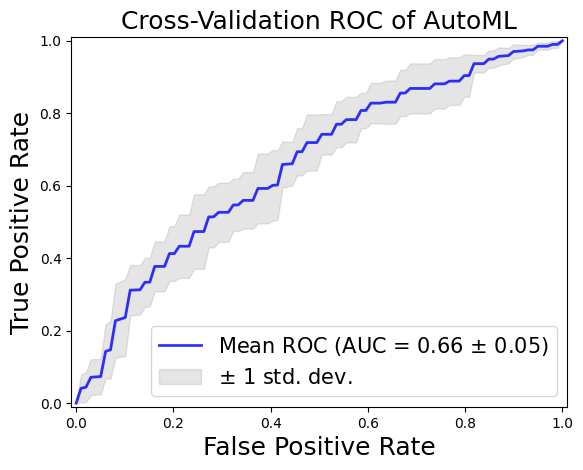

In [3]:
# Model training with PADEL Descriptors
import logging
logging.getLogger('flaml.automl').setLevel(logging.WARNING) # Suppress FLAML INFO logging

from sklearn.metrics import roc_curve, auc, classification_report

tprs = []
aucs = []
mean_fpr = np.linspace(0, 1, 100)
all_true_labels = []
all_predictions = []

df = pd.read_csv(os.path.join(DATAPATH, "training_set_padel.csv"))
#impute any missing values
for column in df.columns[3:]:
    column_mean = df[column].mean()
    df[column].fillna(column_mean, inplace=True)

#change infinity values
df.replace([np.inf, -np.inf], 1e6, inplace=True)

for i in range(5):
    train_file = f"train_{i}.csv"
    test_file = f"test_{i}.csv"
    train = pd.read_csv(os.path.join(DATAPATH, "train_test_splits", train_file))
    test = pd.read_csv(os.path.join(DATAPATH, "train_test_splits",test_file))
    train_descs = pd.merge(train, df, on=['inchikey', "smiles", "outcome"], how='left')
    test_descs = pd.merge(test, df, on =['inchikey', "smiles", "outcome"], how = "left")
    y_train = train["outcome"]
    y_test = test["outcome"]
    X_train = train_descs.iloc[:, 4:]
    X_test = test_descs.iloc[:, 4:]

    mdl = AutoML(task="classification", time_budget=600, logistic_max_iter=40000)
    mdl.fit(X_train, y_train)
    y_pred = mdl.predict_proba(X_test)[:,1]
    y_pred_bin = [1 if y > 0.5 else 0 for y in y_pred]
    fpr, tpr, thresholds = roc_curve(y_test, y_pred)
    tprs.append(np.interp(mean_fpr, fpr, tpr))
    tprs[-1][0] = 0.0
    roc_auc = auc(fpr, tpr)
    aucs.append(roc_auc)

    # Accumulate true labels and predictions
    all_true_labels.extend(y_test)
    all_predictions.extend(y_pred_bin)

# Calculate and print the average classification report
print("\nAverage Classification Report Across All Folds:\n")
print(classification_report(all_true_labels, all_predictions))

# Calculate mean ROC curve and AUC
mean_tpr = np.mean(tprs, axis=0)
mean_tpr[-1] = 1.0
mean_auc = auc(mean_fpr, mean_tpr)
std_auc = np.std(aucs)

# Plot mean ROC curve with boundaries
plt.plot(mean_fpr, mean_tpr, color='b', label=r'Mean ROC (AUC = %0.2f $\pm$ %0.2f)' % (mean_auc, std_auc), lw=2, alpha=.8)

std_tpr = np.std(tprs, axis=0)
tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
tprs_lower = np.maximum(mean_tpr - std_tpr, 0)

plt.fill_between(mean_fpr, tprs_lower, tprs_upper, color='grey', alpha=.2, label=r'$\pm$ 1 std. dev.')

plt.xlim([-0.01, 1.01])
plt.ylim([-0.01, 1.01])
plt.xlabel('False Positive Rate', fontsize=18)
plt.ylabel('True Positive Rate', fontsize=18)
plt.title('Cross-Validation ROC of AutoML', fontsize=18)
plt.legend(loc="lower right", prop={'size': 15})
plt.savefig(os.path.join(FIGUREPATH, "padel_automl.png"))
plt.show()

## Ersilia Embeddings

In [28]:
import pandas as pd
from eosce.models import ErsiliaCompoundEmbeddings

# Initialize the ErsiliaCompoundEmbeddings model
model = ErsiliaCompoundEmbeddings()



for i in range(5):
    # Load train split data
    train_file = f"train_{i}.csv"
    train_df = pd.read_csv(os.path.join(DATAPATH, "train_test_splits", train_file))
    test_set = pd.read_csv(os.path.join(DATAPATH, "train_test_splits", test_file))
    train_smiles = train_df['smiles'].tolist()  # Extract SMILES data from train split
    train_embeddings = [model.transform([smile])[0] for smile in train_smiles]  # Convert SMILES to embeddings
    train_df['embeddings'] = train_embeddings  # Add embeddings as a new column in train DataFrame

    # Load test split data
    test_file = f"test_{i}.csv"
    test_df = pd.read_csv(os.path.join(DATAPATH, "train_test_splits", test_file))
    test_smiles = test_df['smiles'].tolist()  # Extract SMILES data from test split
    test_embeddings = [model.transform([smile])[0] for smile in test_smiles]  # Convert SMILES to embeddings
    test_df['embeddings'] = test_embeddings  # Add embeddings as a new column in test DataFrame
    
    # Save train and test DataFrames with embeddings to new CSV files
    train_df.to_csv(os.path.join(DATAPATH, "train_test_splits", f"train_{i}_with_embeddings.csv"), index=False)
    test_df.to_csv(os.path.join(DATAPATH, "train_test_splits", f"test_{i}_with_embeddings.csv"), index=False)

    # Display the DataFrames with the new embeddings
    print(f"\nTrain split {i} with embeddings:")
    print(train_df.head())

    print(f"\nTest split {i} with embeddings:")
    print(test_df.head())



Train split 0 with embeddings:
   Unnamed: 0                                             smiles  \
0         345  CC=C(C)C(=O)OC1CC(C)(C)CC2C3=CCC4C5(C)CCC(O)C(...   
1         441                      O=C1NC(=O)C(Cl)(c2ccccc2)C1Cl   
2         188                                    Oc1cccc2cccnc12   
3         428                               CCOc1ccc(NC(C)=O)cc1   
4         149                   C[C@@H](c1cc2ccccc2s1)N(O)C(N)=O   

                      inchikey  outcome  \
0  BJFLQQFMBZHWKK-UHFFFAOYSA-N        1   
1  BTMJLNZQSOGJMI-UHFFFAOYSA-N        1   
2  MCJGNVYPOGVAJF-UHFFFAOYSA-N        1   
3  CPJSUEIXXCENMM-UHFFFAOYSA-N        1   
4  MWLSOWXNZPKENC-ZETCQYMHSA-N        1   

                                          embeddings  
0  [0.09524886, -0.23636627, -0.07086838, 0.07834...  
1  [0.09318846, 0.010003996, -0.12534925, 0.02258...  
2  [-0.02418994, -0.036325864, 0.13897535, 0.1226...  
3  [0.10194057, -0.00931686, 0.016004618, 0.12896...  
4  [0.068769634, -0.08370

In [47]:
%%capture
import lazyqsar as lq

tprs = []
aucs = []
mean_fpr = np.linspace(0, 1, 100)
all_true_labels = []
all_predictions = []

for i in range(5):
    train_file = f"train_{i}.csv"
    test_file = f"test_{i}.csv"
    train_set = pd.read_csv(os.path.join(DATAPATH, "train_test_splits", train_file))
    test_set = pd.read_csv(os.path.join(DATAPATH, "train_test_splits",test_file))
    X_train = train_set["smiles"]
    y_train = train_set["outcome"]
    X_test = test_set["smiles"]
    y_test = test_set["outcome"]


    # Fit the model on the training set for the current fold
    model = lq.ErsiliaBinaryClassifier(time_budget_sec=1200, estimator_list=["rf", "lgbm", "xgboost"])
    model.fit(X_train, y_train)

    # Obtain predictions and true labels for the current fold
    y_hat_proba = model.predict_proba(X_test)[:, 1]
    y_pred = model.predict(X_test)

    fpr, tpr, thresholds = roc_curve(y_test, y_hat_proba)
    tprs.append(np.interp(mean_fpr, fpr, tpr))
    tprs[-1][0] = 0.0
    roc_auc = auc(fpr, tpr)
    aucs.append(roc_auc)

    # Accumulate true labels and predictions
    all_true_labels.extend(y_test)
    all_predictions.extend(y_pred)

# Calculate and print the average classification report
print("\nAverage Classification Report Across All Folds:\n")
print(classification_report(all_true_labels, all_predictions))

# Calculate mean ROC curve and AUC
mean_tpr = np.mean(tprs, axis=0)
mean_tpr[-1] = 1.0
mean_auc = auc(mean_fpr, mean_tpr)
std_auc = np.std(aucs)

# Plot mean ROC curve with boundaries
plt.plot(mean_fpr, mean_tpr, color='b', label=r'Mean ROC (AUC = %0.2f $\pm$ %0.2f)' % (mean_auc, std_auc), lw=2, alpha=.8)

std_tpr = np.std(tprs, axis=0)
tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
tprs_lower = np.maximum(mean_tpr - std_tpr, 0)

plt.fill_between(mean_fpr, tprs_lower, tprs_upper, color='grey', alpha=.2, label=r'$\pm$ 1 std. dev.')

plt.xlim([-0.01, 1.01])
plt.ylim([-0.01, 1.01])
plt.xlabel('False Positive Rate', fontsize=18)
plt.ylabel('True Positive Rate', fontsize=18)
plt.title('Cross-Validation ROC of AutoML Morgan', fontsize=18)
plt.legend(loc="lower right", prop={'size': 15})
plt.savefig(os.path.join(FIGUREPATH, "Ersilia_AutoML_1200s.png"), dpi=300)
plt.show()

[flaml.automl.logger: 01-30 11:31:43] {1679} INFO - task = classification
[flaml.automl.logger: 01-30 11:31:43] {1690} INFO - Evaluation method: cv
[flaml.automl.logger: 01-30 11:31:43] {1788} INFO - Minimizing error metric: 1-roc_auc
[flaml.automl.logger: 01-30 11:31:43] {1900} INFO - List of ML learners in AutoML Run: ['rf', 'lgbm', 'xgboost']
[flaml.automl.logger: 01-30 11:31:43] {2218} INFO - iteration 0, current learner rf
[flaml.automl.logger: 01-30 11:31:45] {2345} INFO - Estimated sufficient time budget=12322s. Estimated necessary time budget=12s.
[flaml.automl.logger: 01-30 11:31:45] {2397} INFO -  at 1.2s,	estimator rf's best error=0.3496,	best estimator rf's best error=0.3496
[flaml.automl.logger: 01-30 11:31:45] {2218} INFO - iteration 1, current learner lgbm
[flaml.automl.logger: 01-30 11:31:45] {2397} INFO -  at 1.6s,	estimator lgbm's best error=0.3814,	best estimator rf's best error=0.3496
[flaml.automl.logger: 01-30 11:31:45] {2218} INFO - iteration 2, current learner l

[flaml.automl.logger: 01-30 11:32:29] {2218} INFO - iteration 35, current learner xgboost
[flaml.automl.logger: 01-30 11:32:32] {2397} INFO -  at 48.9s,	estimator xgboost's best error=0.3525,	best estimator rf's best error=0.3365
[flaml.automl.logger: 01-30 11:32:32] {2218} INFO - iteration 36, current learner rf
[flaml.automl.logger: 01-30 11:32:34] {2397} INFO -  at 50.1s,	estimator rf's best error=0.3365,	best estimator rf's best error=0.3365
[flaml.automl.logger: 01-30 11:32:34] {2218} INFO - iteration 37, current learner xgboost
[flaml.automl.logger: 01-30 11:32:35] {2397} INFO -  at 51.7s,	estimator xgboost's best error=0.3525,	best estimator rf's best error=0.3365
[flaml.automl.logger: 01-30 11:32:35] {2218} INFO - iteration 38, current learner rf
[flaml.automl.logger: 01-30 11:32:36] {2397} INFO -  at 53.1s,	estimator rf's best error=0.3365,	best estimator rf's best error=0.3365
[flaml.automl.logger: 01-30 11:32:36] {2218} INFO - iteration 39, current learner lgbm
[flaml.automl

[flaml.automl.logger: 01-30 11:33:30] {2218} INFO - iteration 72, current learner lgbm
[flaml.automl.logger: 01-30 11:33:31] {2397} INFO -  at 107.3s,	estimator lgbm's best error=0.3680,	best estimator rf's best error=0.3365
[flaml.automl.logger: 01-30 11:33:31] {2218} INFO - iteration 73, current learner lgbm
[flaml.automl.logger: 01-30 11:33:31] {2397} INFO -  at 107.9s,	estimator lgbm's best error=0.3680,	best estimator rf's best error=0.3365
[flaml.automl.logger: 01-30 11:33:31] {2218} INFO - iteration 74, current learner rf
[flaml.automl.logger: 01-30 11:33:33] {2397} INFO -  at 109.2s,	estimator rf's best error=0.3365,	best estimator rf's best error=0.3365
[flaml.automl.logger: 01-30 11:33:33] {2218} INFO - iteration 75, current learner rf
[flaml.automl.logger: 01-30 11:33:34] {2397} INFO -  at 110.6s,	estimator rf's best error=0.3365,	best estimator rf's best error=0.3365
[flaml.automl.logger: 01-30 11:33:34] {2218} INFO - iteration 76, current learner lgbm
[flaml.automl.logger:

[flaml.automl.logger: 01-30 11:34:01] {2218} INFO - iteration 109, current learner rf
[flaml.automl.logger: 01-30 11:34:03] {2397} INFO -  at 139.4s,	estimator rf's best error=0.3365,	best estimator rf's best error=0.3365
[flaml.automl.logger: 01-30 11:34:03] {2218} INFO - iteration 110, current learner lgbm
[flaml.automl.logger: 01-30 11:34:03] {2397} INFO -  at 139.9s,	estimator lgbm's best error=0.3429,	best estimator rf's best error=0.3365
[flaml.automl.logger: 01-30 11:34:03] {2218} INFO - iteration 111, current learner lgbm
[flaml.automl.logger: 01-30 11:34:03] {2397} INFO -  at 140.1s,	estimator lgbm's best error=0.3429,	best estimator rf's best error=0.3365
[flaml.automl.logger: 01-30 11:34:03] {2218} INFO - iteration 112, current learner xgboost
[flaml.automl.logger: 01-30 11:34:05] {2397} INFO -  at 141.5s,	estimator xgboost's best error=0.3525,	best estimator rf's best error=0.3365
[flaml.automl.logger: 01-30 11:34:05] {2218} INFO - iteration 113, current learner rf
[flaml.a

[flaml.automl.logger: 01-30 11:34:44] {2218} INFO - iteration 145, current learner rf
[flaml.automl.logger: 01-30 11:34:46] {2397} INFO -  at 182.2s,	estimator rf's best error=0.3365,	best estimator xgboost's best error=0.3239
[flaml.automl.logger: 01-30 11:34:46] {2218} INFO - iteration 146, current learner lgbm
[flaml.automl.logger: 01-30 11:34:46] {2397} INFO -  at 182.6s,	estimator lgbm's best error=0.3377,	best estimator xgboost's best error=0.3239
[flaml.automl.logger: 01-30 11:34:46] {2218} INFO - iteration 147, current learner rf
[flaml.automl.logger: 01-30 11:34:48] {2397} INFO -  at 184.3s,	estimator rf's best error=0.3365,	best estimator xgboost's best error=0.3239
[flaml.automl.logger: 01-30 11:34:48] {2218} INFO - iteration 148, current learner lgbm
[flaml.automl.logger: 01-30 11:34:49] {2397} INFO -  at 185.4s,	estimator lgbm's best error=0.3377,	best estimator xgboost's best error=0.3239
[flaml.automl.logger: 01-30 11:34:49] {2218} INFO - iteration 149, current learner l

[flaml.automl.logger: 01-30 11:35:31] {2397} INFO -  at 227.3s,	estimator lgbm's best error=0.3258,	best estimator xgboost's best error=0.3239
[flaml.automl.logger: 01-30 11:35:31] {2218} INFO - iteration 181, current learner lgbm
[flaml.automl.logger: 01-30 11:35:32] {2397} INFO -  at 229.0s,	estimator lgbm's best error=0.3258,	best estimator xgboost's best error=0.3239
[flaml.automl.logger: 01-30 11:35:32] {2218} INFO - iteration 182, current learner lgbm
[flaml.automl.logger: 01-30 11:35:33] {2397} INFO -  at 230.0s,	estimator lgbm's best error=0.3258,	best estimator xgboost's best error=0.3239
[flaml.automl.logger: 01-30 11:35:33] {2218} INFO - iteration 183, current learner lgbm
[flaml.automl.logger: 01-30 11:35:35] {2397} INFO -  at 231.5s,	estimator lgbm's best error=0.3258,	best estimator xgboost's best error=0.3239
[flaml.automl.logger: 01-30 11:35:35] {2218} INFO - iteration 184, current learner lgbm
[flaml.automl.logger: 01-30 11:35:36] {2397} INFO -  at 232.3s,	estimator lg

[flaml.automl.logger: 01-30 11:36:52] {2218} INFO - iteration 216, current learner lgbm
[flaml.automl.logger: 01-30 11:36:53] {2397} INFO -  at 309.2s,	estimator lgbm's best error=0.3225,	best estimator lgbm's best error=0.3225
[flaml.automl.logger: 01-30 11:36:53] {2218} INFO - iteration 217, current learner lgbm
[flaml.automl.logger: 01-30 11:36:53] {2397} INFO -  at 309.9s,	estimator lgbm's best error=0.3225,	best estimator lgbm's best error=0.3225
[flaml.automl.logger: 01-30 11:36:53] {2218} INFO - iteration 218, current learner lgbm
[flaml.automl.logger: 01-30 11:36:54] {2397} INFO -  at 310.4s,	estimator lgbm's best error=0.3225,	best estimator lgbm's best error=0.3225
[flaml.automl.logger: 01-30 11:36:54] {2218} INFO - iteration 219, current learner rf
[flaml.automl.logger: 01-30 11:36:55] {2397} INFO -  at 311.8s,	estimator rf's best error=0.3365,	best estimator lgbm's best error=0.3225
[flaml.automl.logger: 01-30 11:36:55] {2218} INFO - iteration 220, current learner xgboost
[

[flaml.automl.logger: 01-30 11:37:39] {2218} INFO - iteration 252, current learner xgboost
[flaml.automl.logger: 01-30 11:37:41] {2397} INFO -  at 357.7s,	estimator xgboost's best error=0.3239,	best estimator lgbm's best error=0.3225
[flaml.automl.logger: 01-30 11:37:41] {2218} INFO - iteration 253, current learner rf
[flaml.automl.logger: 01-30 11:37:43] {2397} INFO -  at 359.3s,	estimator rf's best error=0.3365,	best estimator lgbm's best error=0.3225
[flaml.automl.logger: 01-30 11:37:43] {2218} INFO - iteration 254, current learner xgboost
[flaml.automl.logger: 01-30 11:37:44] {2397} INFO -  at 361.1s,	estimator xgboost's best error=0.3239,	best estimator lgbm's best error=0.3225
[flaml.automl.logger: 01-30 11:37:44] {2218} INFO - iteration 255, current learner lgbm
[flaml.automl.logger: 01-30 11:37:45] {2397} INFO -  at 361.6s,	estimator lgbm's best error=0.3225,	best estimator lgbm's best error=0.3225
[flaml.automl.logger: 01-30 11:37:45] {2218} INFO - iteration 256, current learn

[flaml.automl.logger: 01-30 11:38:23] {2218} INFO - iteration 288, current learner xgboost
[flaml.automl.logger: 01-30 11:38:24] {2397} INFO -  at 400.5s,	estimator xgboost's best error=0.3239,	best estimator lgbm's best error=0.3225
[flaml.automl.logger: 01-30 11:38:24] {2218} INFO - iteration 289, current learner lgbm
[flaml.automl.logger: 01-30 11:38:24] {2397} INFO -  at 401.1s,	estimator lgbm's best error=0.3225,	best estimator lgbm's best error=0.3225
[flaml.automl.logger: 01-30 11:38:24] {2218} INFO - iteration 290, current learner xgboost
[flaml.automl.logger: 01-30 11:38:26] {2397} INFO -  at 402.8s,	estimator xgboost's best error=0.3239,	best estimator lgbm's best error=0.3225
[flaml.automl.logger: 01-30 11:38:26] {2218} INFO - iteration 291, current learner lgbm
[flaml.automl.logger: 01-30 11:38:27] {2397} INFO -  at 403.3s,	estimator lgbm's best error=0.3225,	best estimator lgbm's best error=0.3225
[flaml.automl.logger: 01-30 11:38:27] {2218} INFO - iteration 292, current l

[flaml.automl.logger: 01-30 11:39:03] {2218} INFO - iteration 324, current learner lgbm
[flaml.automl.logger: 01-30 11:39:03] {2397} INFO -  at 440.1s,	estimator lgbm's best error=0.3225,	best estimator lgbm's best error=0.3225
[flaml.automl.logger: 01-30 11:39:03] {2218} INFO - iteration 325, current learner lgbm
[flaml.automl.logger: 01-30 11:39:04] {2397} INFO -  at 441.0s,	estimator lgbm's best error=0.3225,	best estimator lgbm's best error=0.3225
[flaml.automl.logger: 01-30 11:39:04] {2218} INFO - iteration 326, current learner rf
[flaml.automl.logger: 01-30 11:39:06] {2397} INFO -  at 442.4s,	estimator rf's best error=0.3365,	best estimator lgbm's best error=0.3225
[flaml.automl.logger: 01-30 11:39:06] {2218} INFO - iteration 327, current learner lgbm
[flaml.automl.logger: 01-30 11:39:06] {2397} INFO -  at 442.8s,	estimator lgbm's best error=0.3225,	best estimator lgbm's best error=0.3225
[flaml.automl.logger: 01-30 11:39:06] {2218} INFO - iteration 328, current learner lgbm
[fla

[flaml.automl.logger: 01-30 11:39:56] {2218} INFO - iteration 360, current learner lgbm
[flaml.automl.logger: 01-30 11:39:57] {2397} INFO -  at 493.4s,	estimator lgbm's best error=0.3225,	best estimator lgbm's best error=0.3225
[flaml.automl.logger: 01-30 11:39:57] {2218} INFO - iteration 361, current learner xgboost
[flaml.automl.logger: 01-30 11:39:58] {2397} INFO -  at 495.0s,	estimator xgboost's best error=0.3239,	best estimator lgbm's best error=0.3225
[flaml.automl.logger: 01-30 11:39:58] {2218} INFO - iteration 362, current learner xgboost
[flaml.automl.logger: 01-30 11:40:01] {2397} INFO -  at 497.9s,	estimator xgboost's best error=0.3239,	best estimator lgbm's best error=0.3225
[flaml.automl.logger: 01-30 11:40:01] {2218} INFO - iteration 363, current learner lgbm
[flaml.automl.logger: 01-30 11:40:02] {2397} INFO -  at 498.6s,	estimator lgbm's best error=0.3225,	best estimator lgbm's best error=0.3225
[flaml.automl.logger: 01-30 11:40:02] {2218} INFO - iteration 364, current l

[flaml.automl.logger: 01-30 11:40:44] {2218} INFO - iteration 396, current learner rf
[flaml.automl.logger: 01-30 11:40:45] {2397} INFO -  at 541.9s,	estimator rf's best error=0.3365,	best estimator lgbm's best error=0.3098
[flaml.automl.logger: 01-30 11:40:45] {2218} INFO - iteration 397, current learner lgbm
[flaml.automl.logger: 01-30 11:40:47] {2397} INFO -  at 543.2s,	estimator lgbm's best error=0.3098,	best estimator lgbm's best error=0.3098
[flaml.automl.logger: 01-30 11:40:47] {2218} INFO - iteration 398, current learner xgboost
[flaml.automl.logger: 01-30 11:40:49] {2397} INFO -  at 546.0s,	estimator xgboost's best error=0.3239,	best estimator lgbm's best error=0.3098
[flaml.automl.logger: 01-30 11:40:49] {2218} INFO - iteration 399, current learner lgbm
[flaml.automl.logger: 01-30 11:40:50] {2397} INFO -  at 547.0s,	estimator lgbm's best error=0.3098,	best estimator lgbm's best error=0.3098
[flaml.automl.logger: 01-30 11:40:50] {2218} INFO - iteration 400, current learner lgb

[flaml.automl.logger: 01-30 11:41:31] {2218} INFO - iteration 432, current learner lgbm
[flaml.automl.logger: 01-30 11:41:31] {2397} INFO -  at 588.1s,	estimator lgbm's best error=0.3098,	best estimator lgbm's best error=0.3098
[flaml.automl.logger: 01-30 11:41:31] {2218} INFO - iteration 433, current learner lgbm
[flaml.automl.logger: 01-30 11:41:32] {2397} INFO -  at 588.5s,	estimator lgbm's best error=0.3098,	best estimator lgbm's best error=0.3098
[flaml.automl.logger: 01-30 11:41:32] {2218} INFO - iteration 434, current learner lgbm
[flaml.automl.logger: 01-30 11:41:32] {2397} INFO -  at 588.9s,	estimator lgbm's best error=0.3098,	best estimator lgbm's best error=0.3098
[flaml.automl.logger: 01-30 11:41:32] {2218} INFO - iteration 435, current learner lgbm
[flaml.automl.logger: 01-30 11:41:33] {2397} INFO -  at 589.4s,	estimator lgbm's best error=0.3098,	best estimator lgbm's best error=0.3098
[flaml.automl.logger: 01-30 11:41:33] {2218} INFO - iteration 436, current learner lgbm


[flaml.automl.logger: 01-30 11:42:29] {2218} INFO - iteration 468, current learner lgbm
[flaml.automl.logger: 01-30 11:42:30] {2397} INFO -  at 646.2s,	estimator lgbm's best error=0.3098,	best estimator lgbm's best error=0.3098
[flaml.automl.logger: 01-30 11:42:30] {2218} INFO - iteration 469, current learner xgboost
[flaml.automl.logger: 01-30 11:42:36] {2397} INFO -  at 652.6s,	estimator xgboost's best error=0.3239,	best estimator lgbm's best error=0.3098
[flaml.automl.logger: 01-30 11:42:36] {2218} INFO - iteration 470, current learner lgbm
[flaml.automl.logger: 01-30 11:42:38] {2397} INFO -  at 654.2s,	estimator lgbm's best error=0.3098,	best estimator lgbm's best error=0.3098
[flaml.automl.logger: 01-30 11:42:38] {2218} INFO - iteration 471, current learner lgbm
[flaml.automl.logger: 01-30 11:42:38] {2397} INFO -  at 654.9s,	estimator lgbm's best error=0.3098,	best estimator lgbm's best error=0.3098
[flaml.automl.logger: 01-30 11:42:38] {2218} INFO - iteration 472, current learner

[flaml.automl.logger: 01-30 11:43:08] {2218} INFO - iteration 504, current learner lgbm
[flaml.automl.logger: 01-30 11:43:09] {2397} INFO -  at 685.8s,	estimator lgbm's best error=0.3098,	best estimator lgbm's best error=0.3098
[flaml.automl.logger: 01-30 11:43:09] {2218} INFO - iteration 505, current learner lgbm
[flaml.automl.logger: 01-30 11:43:10] {2397} INFO -  at 686.2s,	estimator lgbm's best error=0.3098,	best estimator lgbm's best error=0.3098
[flaml.automl.logger: 01-30 11:43:10] {2218} INFO - iteration 506, current learner lgbm
[flaml.automl.logger: 01-30 11:43:10] {2397} INFO -  at 686.6s,	estimator lgbm's best error=0.3098,	best estimator lgbm's best error=0.3098
[flaml.automl.logger: 01-30 11:43:10] {2218} INFO - iteration 507, current learner lgbm
[flaml.automl.logger: 01-30 11:43:10] {2397} INFO -  at 687.1s,	estimator lgbm's best error=0.3098,	best estimator lgbm's best error=0.3098
[flaml.automl.logger: 01-30 11:43:10] {2218} INFO - iteration 508, current learner lgbm


[flaml.automl.logger: 01-30 11:43:47] {2218} INFO - iteration 540, current learner lgbm
[flaml.automl.logger: 01-30 11:43:48] {2397} INFO -  at 724.3s,	estimator lgbm's best error=0.3098,	best estimator lgbm's best error=0.3098
[flaml.automl.logger: 01-30 11:43:48] {2218} INFO - iteration 541, current learner rf
[flaml.automl.logger: 01-30 11:43:49] {2397} INFO -  at 725.7s,	estimator rf's best error=0.3365,	best estimator lgbm's best error=0.3098
[flaml.automl.logger: 01-30 11:43:49] {2218} INFO - iteration 542, current learner lgbm
[flaml.automl.logger: 01-30 11:43:49] {2397} INFO -  at 726.1s,	estimator lgbm's best error=0.3098,	best estimator lgbm's best error=0.3098
[flaml.automl.logger: 01-30 11:43:49] {2218} INFO - iteration 543, current learner lgbm
[flaml.automl.logger: 01-30 11:43:50] {2397} INFO -  at 727.1s,	estimator lgbm's best error=0.3098,	best estimator lgbm's best error=0.3098
[flaml.automl.logger: 01-30 11:43:50] {2218} INFO - iteration 544, current learner lgbm
[fla

[flaml.automl.logger: 01-30 11:44:19] {2218} INFO - iteration 576, current learner lgbm
[flaml.automl.logger: 01-30 11:44:20] {2397} INFO -  at 756.7s,	estimator lgbm's best error=0.3098,	best estimator lgbm's best error=0.3098
[flaml.automl.logger: 01-30 11:44:20] {2218} INFO - iteration 577, current learner lgbm
[flaml.automl.logger: 01-30 11:44:21] {2397} INFO -  at 757.2s,	estimator lgbm's best error=0.3098,	best estimator lgbm's best error=0.3098
[flaml.automl.logger: 01-30 11:44:21] {2218} INFO - iteration 578, current learner lgbm
[flaml.automl.logger: 01-30 11:44:21] {2397} INFO -  at 757.8s,	estimator lgbm's best error=0.3098,	best estimator lgbm's best error=0.3098
[flaml.automl.logger: 01-30 11:44:21] {2218} INFO - iteration 579, current learner lgbm
[flaml.automl.logger: 01-30 11:44:22] {2397} INFO -  at 758.4s,	estimator lgbm's best error=0.3098,	best estimator lgbm's best error=0.3098
[flaml.automl.logger: 01-30 11:44:22] {2218} INFO - iteration 580, current learner lgbm


[flaml.automl.logger: 01-30 11:44:52] {2218} INFO - iteration 612, current learner xgboost
[flaml.automl.logger: 01-30 11:44:55] {2397} INFO -  at 791.3s,	estimator xgboost's best error=0.3239,	best estimator lgbm's best error=0.3098
[flaml.automl.logger: 01-30 11:44:55] {2218} INFO - iteration 613, current learner lgbm
[flaml.automl.logger: 01-30 11:44:55] {2397} INFO -  at 791.7s,	estimator lgbm's best error=0.3098,	best estimator lgbm's best error=0.3098
[flaml.automl.logger: 01-30 11:44:55] {2218} INFO - iteration 614, current learner xgboost
[flaml.automl.logger: 01-30 11:44:56] {2397} INFO -  at 792.7s,	estimator xgboost's best error=0.3239,	best estimator lgbm's best error=0.3098
[flaml.automl.logger: 01-30 11:44:56] {2218} INFO - iteration 615, current learner lgbm
[flaml.automl.logger: 01-30 11:44:57] {2397} INFO -  at 793.3s,	estimator lgbm's best error=0.3098,	best estimator lgbm's best error=0.3098
[flaml.automl.logger: 01-30 11:44:57] {2218} INFO - iteration 616, current l

[flaml.automl.logger: 01-30 11:45:21] {2218} INFO - iteration 648, current learner lgbm
[flaml.automl.logger: 01-30 11:45:21] {2397} INFO -  at 818.1s,	estimator lgbm's best error=0.3098,	best estimator lgbm's best error=0.3098
[flaml.automl.logger: 01-30 11:45:21] {2218} INFO - iteration 649, current learner lgbm
[flaml.automl.logger: 01-30 11:45:23] {2397} INFO -  at 819.4s,	estimator lgbm's best error=0.3098,	best estimator lgbm's best error=0.3098
[flaml.automl.logger: 01-30 11:45:23] {2218} INFO - iteration 650, current learner rf
[flaml.automl.logger: 01-30 11:45:25] {2397} INFO -  at 821.3s,	estimator rf's best error=0.3365,	best estimator lgbm's best error=0.3098
[flaml.automl.logger: 01-30 11:45:25] {2218} INFO - iteration 651, current learner lgbm
[flaml.automl.logger: 01-30 11:45:25] {2397} INFO -  at 821.7s,	estimator lgbm's best error=0.3098,	best estimator lgbm's best error=0.3098
[flaml.automl.logger: 01-30 11:45:25] {2218} INFO - iteration 652, current learner lgbm
[fla

[flaml.automl.logger: 01-30 11:45:59] {2218} INFO - iteration 684, current learner lgbm
[flaml.automl.logger: 01-30 11:46:00] {2397} INFO -  at 856.6s,	estimator lgbm's best error=0.3098,	best estimator lgbm's best error=0.3098
[flaml.automl.logger: 01-30 11:46:00] {2218} INFO - iteration 685, current learner lgbm
[flaml.automl.logger: 01-30 11:46:00] {2397} INFO -  at 857.1s,	estimator lgbm's best error=0.3098,	best estimator lgbm's best error=0.3098
[flaml.automl.logger: 01-30 11:46:00] {2218} INFO - iteration 686, current learner xgboost
[flaml.automl.logger: 01-30 11:46:02] {2397} INFO -  at 858.4s,	estimator xgboost's best error=0.3239,	best estimator lgbm's best error=0.3098
[flaml.automl.logger: 01-30 11:46:02] {2218} INFO - iteration 687, current learner lgbm
[flaml.automl.logger: 01-30 11:46:02] {2397} INFO -  at 858.9s,	estimator lgbm's best error=0.3098,	best estimator lgbm's best error=0.3098
[flaml.automl.logger: 01-30 11:46:02] {2218} INFO - iteration 688, current learner

[flaml.automl.logger: 01-30 11:46:33] {2218} INFO - iteration 720, current learner lgbm
[flaml.automl.logger: 01-30 11:46:34] {2397} INFO -  at 890.5s,	estimator lgbm's best error=0.3098,	best estimator lgbm's best error=0.3098
[flaml.automl.logger: 01-30 11:46:34] {2218} INFO - iteration 721, current learner lgbm
[flaml.automl.logger: 01-30 11:46:34] {2397} INFO -  at 891.0s,	estimator lgbm's best error=0.3098,	best estimator lgbm's best error=0.3098
[flaml.automl.logger: 01-30 11:46:34] {2218} INFO - iteration 722, current learner lgbm
[flaml.automl.logger: 01-30 11:46:35] {2397} INFO -  at 891.6s,	estimator lgbm's best error=0.3098,	best estimator lgbm's best error=0.3098
[flaml.automl.logger: 01-30 11:46:35] {2218} INFO - iteration 723, current learner lgbm
[flaml.automl.logger: 01-30 11:46:36] {2397} INFO -  at 892.2s,	estimator lgbm's best error=0.3098,	best estimator lgbm's best error=0.3098
[flaml.automl.logger: 01-30 11:46:36] {2218} INFO - iteration 724, current learner xgboo

[flaml.automl.logger: 01-30 11:47:34] {2218} INFO - iteration 756, current learner xgboost
[flaml.automl.logger: 01-30 11:47:35] {2397} INFO -  at 951.6s,	estimator xgboost's best error=0.3239,	best estimator lgbm's best error=0.3098
[flaml.automl.logger: 01-30 11:47:35] {2218} INFO - iteration 757, current learner lgbm
[flaml.automl.logger: 01-30 11:47:36] {2397} INFO -  at 952.4s,	estimator lgbm's best error=0.3098,	best estimator lgbm's best error=0.3098
[flaml.automl.logger: 01-30 11:47:36] {2218} INFO - iteration 758, current learner xgboost
[flaml.automl.logger: 01-30 11:47:42] {2397} INFO -  at 958.2s,	estimator xgboost's best error=0.3239,	best estimator lgbm's best error=0.3098
[flaml.automl.logger: 01-30 11:47:42] {2218} INFO - iteration 759, current learner lgbm
[flaml.automl.logger: 01-30 11:47:42] {2397} INFO -  at 958.6s,	estimator lgbm's best error=0.3098,	best estimator lgbm's best error=0.3098
[flaml.automl.logger: 01-30 11:47:42] {2218} INFO - iteration 760, current l

[flaml.automl.logger: 01-30 11:48:15] {2218} INFO - iteration 792, current learner xgboost
[flaml.automl.logger: 01-30 11:48:16] {2397} INFO -  at 992.6s,	estimator xgboost's best error=0.3239,	best estimator lgbm's best error=0.3098
[flaml.automl.logger: 01-30 11:48:16] {2218} INFO - iteration 793, current learner lgbm
[flaml.automl.logger: 01-30 11:48:17] {2397} INFO -  at 993.5s,	estimator lgbm's best error=0.3098,	best estimator lgbm's best error=0.3098
[flaml.automl.logger: 01-30 11:48:17] {2218} INFO - iteration 794, current learner lgbm
[flaml.automl.logger: 01-30 11:48:18] {2397} INFO -  at 994.2s,	estimator lgbm's best error=0.3098,	best estimator lgbm's best error=0.3098
[flaml.automl.logger: 01-30 11:48:18] {2218} INFO - iteration 795, current learner lgbm
[flaml.automl.logger: 01-30 11:48:18] {2397} INFO -  at 994.8s,	estimator lgbm's best error=0.3098,	best estimator lgbm's best error=0.3098
[flaml.automl.logger: 01-30 11:48:18] {2218} INFO - iteration 796, current learner

[flaml.automl.logger: 01-30 11:48:47] {2218} INFO - iteration 828, current learner lgbm
[flaml.automl.logger: 01-30 11:48:47] {2397} INFO -  at 1024.1s,	estimator lgbm's best error=0.3098,	best estimator lgbm's best error=0.3098
[flaml.automl.logger: 01-30 11:48:47] {2218} INFO - iteration 829, current learner lgbm
[flaml.automl.logger: 01-30 11:48:48] {2397} INFO -  at 1024.5s,	estimator lgbm's best error=0.3098,	best estimator lgbm's best error=0.3098
[flaml.automl.logger: 01-30 11:48:48] {2218} INFO - iteration 830, current learner rf
[flaml.automl.logger: 01-30 11:48:50] {2397} INFO -  at 1026.6s,	estimator rf's best error=0.3365,	best estimator lgbm's best error=0.3098
[flaml.automl.logger: 01-30 11:48:50] {2218} INFO - iteration 831, current learner lgbm
[flaml.automl.logger: 01-30 11:48:51] {2397} INFO -  at 1027.2s,	estimator lgbm's best error=0.3098,	best estimator lgbm's best error=0.3098
[flaml.automl.logger: 01-30 11:48:51] {2218} INFO - iteration 832, current learner lgbm


[flaml.automl.logger: 01-30 11:49:15] {2218} INFO - iteration 864, current learner lgbm
[flaml.automl.logger: 01-30 11:49:15] {2397} INFO -  at 1051.9s,	estimator lgbm's best error=0.3098,	best estimator lgbm's best error=0.3098
[flaml.automl.logger: 01-30 11:49:15] {2218} INFO - iteration 865, current learner lgbm
[flaml.automl.logger: 01-30 11:49:16] {2397} INFO -  at 1052.4s,	estimator lgbm's best error=0.3098,	best estimator lgbm's best error=0.3098
[flaml.automl.logger: 01-30 11:49:16] {2218} INFO - iteration 866, current learner lgbm
[flaml.automl.logger: 01-30 11:49:16] {2397} INFO -  at 1052.8s,	estimator lgbm's best error=0.3098,	best estimator lgbm's best error=0.3098
[flaml.automl.logger: 01-30 11:49:16] {2218} INFO - iteration 867, current learner xgboost
[flaml.automl.logger: 01-30 11:49:18] {2397} INFO -  at 1054.4s,	estimator xgboost's best error=0.3239,	best estimator lgbm's best error=0.3098
[flaml.automl.logger: 01-30 11:49:18] {2218} INFO - iteration 868, current lea

[flaml.automl.logger: 01-30 11:49:51] {2218} INFO - iteration 900, current learner lgbm
[flaml.automl.logger: 01-30 11:49:52] {2397} INFO -  at 1088.1s,	estimator lgbm's best error=0.3098,	best estimator lgbm's best error=0.3098
[flaml.automl.logger: 01-30 11:49:52] {2218} INFO - iteration 901, current learner xgboost
[flaml.automl.logger: 01-30 11:49:53] {2397} INFO -  at 1089.2s,	estimator xgboost's best error=0.3239,	best estimator lgbm's best error=0.3098
[flaml.automl.logger: 01-30 11:49:53] {2218} INFO - iteration 902, current learner lgbm
[flaml.automl.logger: 01-30 11:49:53] {2397} INFO -  at 1089.6s,	estimator lgbm's best error=0.3098,	best estimator lgbm's best error=0.3098
[flaml.automl.logger: 01-30 11:49:53] {2218} INFO - iteration 903, current learner lgbm
[flaml.automl.logger: 01-30 11:49:53] {2397} INFO -  at 1090.1s,	estimator lgbm's best error=0.3098,	best estimator lgbm's best error=0.3098
[flaml.automl.logger: 01-30 11:49:53] {2218} INFO - iteration 904, current lea

[flaml.automl.logger: 01-30 11:50:28] {2218} INFO - iteration 936, current learner lgbm
[flaml.automl.logger: 01-30 11:50:28] {2397} INFO -  at 1124.6s,	estimator lgbm's best error=0.3098,	best estimator lgbm's best error=0.3098
[flaml.automl.logger: 01-30 11:50:28] {2218} INFO - iteration 937, current learner lgbm
[flaml.automl.logger: 01-30 11:50:28] {2397} INFO -  at 1125.0s,	estimator lgbm's best error=0.3098,	best estimator lgbm's best error=0.3098
[flaml.automl.logger: 01-30 11:50:28] {2218} INFO - iteration 938, current learner xgboost
[flaml.automl.logger: 01-30 11:50:31] {2397} INFO -  at 1128.0s,	estimator xgboost's best error=0.3239,	best estimator lgbm's best error=0.3098
[flaml.automl.logger: 01-30 11:50:31] {2218} INFO - iteration 939, current learner rf
[flaml.automl.logger: 01-30 11:50:33] {2397} INFO -  at 1129.4s,	estimator rf's best error=0.3365,	best estimator lgbm's best error=0.3098
[flaml.automl.logger: 01-30 11:50:33] {2218} INFO - iteration 940, current learner

[flaml.automl.logger: 01-30 11:51:01] {2218} INFO - iteration 972, current learner lgbm
[flaml.automl.logger: 01-30 11:51:01] {2397} INFO -  at 1158.0s,	estimator lgbm's best error=0.3098,	best estimator lgbm's best error=0.3098
[flaml.automl.logger: 01-30 11:51:01] {2218} INFO - iteration 973, current learner lgbm
[flaml.automl.logger: 01-30 11:51:02] {2397} INFO -  at 1158.3s,	estimator lgbm's best error=0.3098,	best estimator lgbm's best error=0.3098
[flaml.automl.logger: 01-30 11:51:02] {2218} INFO - iteration 974, current learner xgboost
[flaml.automl.logger: 01-30 11:51:04] {2397} INFO -  at 1160.2s,	estimator xgboost's best error=0.3239,	best estimator lgbm's best error=0.3098
[flaml.automl.logger: 01-30 11:51:04] {2218} INFO - iteration 975, current learner lgbm
[flaml.automl.logger: 01-30 11:51:04] {2397} INFO -  at 1160.7s,	estimator lgbm's best error=0.3098,	best estimator lgbm's best error=0.3098
[flaml.automl.logger: 01-30 11:51:04] {2218} INFO - iteration 976, current lea

[flaml.automl.logger: 01-30 11:51:33] {2218} INFO - iteration 1008, current learner lgbm
[flaml.automl.logger: 01-30 11:51:33] {2397} INFO -  at 1189.7s,	estimator lgbm's best error=0.3098,	best estimator lgbm's best error=0.3098
[flaml.automl.logger: 01-30 11:51:33] {2218} INFO - iteration 1009, current learner rf
[flaml.automl.logger: 01-30 11:51:34] {2397} INFO -  at 1190.9s,	estimator rf's best error=0.3365,	best estimator lgbm's best error=0.3098
[flaml.automl.logger: 01-30 11:51:34] {2218} INFO - iteration 1010, current learner lgbm
[flaml.automl.logger: 01-30 11:51:35] {2397} INFO -  at 1191.3s,	estimator lgbm's best error=0.3098,	best estimator lgbm's best error=0.3098
[flaml.automl.logger: 01-30 11:51:35] {2218} INFO - iteration 1011, current learner rf
[flaml.automl.logger: 01-30 11:51:37] {2397} INFO -  at 1193.5s,	estimator rf's best error=0.3365,	best estimator lgbm's best error=0.3098
[flaml.automl.logger: 01-30 11:51:37] {2218} INFO - iteration 1012, current learner lgbm

[flaml.automl.logger: 01-30 11:52:07] {2397} INFO -  at 23.9s,	estimator xgboost's best error=0.3065,	best estimator xgboost's best error=0.3065
[flaml.automl.logger: 01-30 11:52:07] {2218} INFO - iteration 21, current learner lgbm
[flaml.automl.logger: 01-30 11:52:08] {2397} INFO -  at 25.2s,	estimator lgbm's best error=0.3141,	best estimator xgboost's best error=0.3065
[flaml.automl.logger: 01-30 11:52:08] {2218} INFO - iteration 22, current learner lgbm
[flaml.automl.logger: 01-30 11:52:09] {2397} INFO -  at 25.9s,	estimator lgbm's best error=0.3141,	best estimator xgboost's best error=0.3065
[flaml.automl.logger: 01-30 11:52:09] {2218} INFO - iteration 23, current learner xgboost
[flaml.automl.logger: 01-30 11:52:11] {2397} INFO -  at 27.3s,	estimator xgboost's best error=0.3065,	best estimator xgboost's best error=0.3065
[flaml.automl.logger: 01-30 11:52:11] {2218} INFO - iteration 24, current learner xgboost
[flaml.automl.logger: 01-30 11:52:12] {2397} INFO -  at 28.7s,	estimator

[flaml.automl.logger: 01-30 11:52:58] {2397} INFO -  at 74.6s,	estimator lgbm's best error=0.2805,	best estimator lgbm's best error=0.2805
[flaml.automl.logger: 01-30 11:52:58] {2218} INFO - iteration 57, current learner lgbm
[flaml.automl.logger: 01-30 11:53:00] {2397} INFO -  at 76.3s,	estimator lgbm's best error=0.2805,	best estimator lgbm's best error=0.2805
[flaml.automl.logger: 01-30 11:53:00] {2218} INFO - iteration 58, current learner lgbm
[flaml.automl.logger: 01-30 11:53:01] {2397} INFO -  at 77.5s,	estimator lgbm's best error=0.2805,	best estimator lgbm's best error=0.2805
[flaml.automl.logger: 01-30 11:53:01] {2218} INFO - iteration 59, current learner lgbm
[flaml.automl.logger: 01-30 11:53:02] {2397} INFO -  at 79.1s,	estimator lgbm's best error=0.2805,	best estimator lgbm's best error=0.2805
[flaml.automl.logger: 01-30 11:53:02] {2218} INFO - iteration 60, current learner lgbm
[flaml.automl.logger: 01-30 11:53:03] {2397} INFO -  at 79.7s,	estimator lgbm's best error=0.280

[flaml.automl.logger: 01-30 11:53:39] {2218} INFO - iteration 93, current learner lgbm
[flaml.automl.logger: 01-30 11:53:39] {2397} INFO -  at 115.6s,	estimator lgbm's best error=0.2773,	best estimator lgbm's best error=0.2773
[flaml.automl.logger: 01-30 11:53:39] {2218} INFO - iteration 94, current learner xgboost
[flaml.automl.logger: 01-30 11:53:40] {2397} INFO -  at 116.8s,	estimator xgboost's best error=0.2944,	best estimator lgbm's best error=0.2773
[flaml.automl.logger: 01-30 11:53:40] {2218} INFO - iteration 95, current learner lgbm
[flaml.automl.logger: 01-30 11:53:40] {2397} INFO -  at 117.2s,	estimator lgbm's best error=0.2773,	best estimator lgbm's best error=0.2773
[flaml.automl.logger: 01-30 11:53:40] {2218} INFO - iteration 96, current learner lgbm
[flaml.automl.logger: 01-30 11:53:41] {2397} INFO -  at 118.0s,	estimator lgbm's best error=0.2773,	best estimator lgbm's best error=0.2773
[flaml.automl.logger: 01-30 11:53:41] {2218} INFO - iteration 97, current learner lgbm

[flaml.automl.logger: 01-30 11:54:12] {2218} INFO - iteration 129, current learner lgbm
[flaml.automl.logger: 01-30 11:54:13] {2397} INFO -  at 150.2s,	estimator lgbm's best error=0.2773,	best estimator lgbm's best error=0.2773
[flaml.automl.logger: 01-30 11:54:13] {2218} INFO - iteration 130, current learner lgbm
[flaml.automl.logger: 01-30 11:54:14] {2397} INFO -  at 150.6s,	estimator lgbm's best error=0.2773,	best estimator lgbm's best error=0.2773
[flaml.automl.logger: 01-30 11:54:14] {2218} INFO - iteration 131, current learner lgbm
[flaml.automl.logger: 01-30 11:54:14] {2397} INFO -  at 150.9s,	estimator lgbm's best error=0.2773,	best estimator lgbm's best error=0.2773
[flaml.automl.logger: 01-30 11:54:14] {2218} INFO - iteration 132, current learner lgbm
[flaml.automl.logger: 01-30 11:54:15] {2397} INFO -  at 151.3s,	estimator lgbm's best error=0.2773,	best estimator lgbm's best error=0.2773
[flaml.automl.logger: 01-30 11:54:15] {2218} INFO - iteration 133, current learner lgbm


[flaml.automl.logger: 01-30 11:54:45] {2218} INFO - iteration 165, current learner lgbm
[flaml.automl.logger: 01-30 11:54:45] {2397} INFO -  at 182.3s,	estimator lgbm's best error=0.2773,	best estimator lgbm's best error=0.2773
[flaml.automl.logger: 01-30 11:54:45] {2218} INFO - iteration 166, current learner lgbm
[flaml.automl.logger: 01-30 11:54:46] {2397} INFO -  at 182.5s,	estimator lgbm's best error=0.2773,	best estimator lgbm's best error=0.2773
[flaml.automl.logger: 01-30 11:54:46] {2218} INFO - iteration 167, current learner lgbm
[flaml.automl.logger: 01-30 11:54:46] {2397} INFO -  at 183.0s,	estimator lgbm's best error=0.2773,	best estimator lgbm's best error=0.2773
[flaml.automl.logger: 01-30 11:54:46] {2218} INFO - iteration 168, current learner lgbm
[flaml.automl.logger: 01-30 11:54:47] {2397} INFO -  at 183.4s,	estimator lgbm's best error=0.2773,	best estimator lgbm's best error=0.2773
[flaml.automl.logger: 01-30 11:54:47] {2218} INFO - iteration 169, current learner lgbm


[flaml.automl.logger: 01-30 11:55:03] {2218} INFO - iteration 201, current learner xgboost
[flaml.automl.logger: 01-30 11:55:04] {2397} INFO -  at 200.7s,	estimator xgboost's best error=0.2842,	best estimator lgbm's best error=0.2773
[flaml.automl.logger: 01-30 11:55:04] {2218} INFO - iteration 202, current learner xgboost
[flaml.automl.logger: 01-30 11:55:05] {2397} INFO -  at 201.5s,	estimator xgboost's best error=0.2842,	best estimator lgbm's best error=0.2773
[flaml.automl.logger: 01-30 11:55:05] {2218} INFO - iteration 203, current learner xgboost
[flaml.automl.logger: 01-30 11:55:05] {2397} INFO -  at 202.0s,	estimator xgboost's best error=0.2842,	best estimator lgbm's best error=0.2773
[flaml.automl.logger: 01-30 11:55:05] {2218} INFO - iteration 204, current learner xgboost
[flaml.automl.logger: 01-30 11:55:06] {2397} INFO -  at 202.7s,	estimator xgboost's best error=0.2842,	best estimator lgbm's best error=0.2773
[flaml.automl.logger: 01-30 11:55:06] {2218} INFO - iteration 20

[flaml.automl.logger: 01-30 11:55:29] {2397} INFO -  at 225.3s,	estimator lgbm's best error=0.2773,	best estimator lgbm's best error=0.2773
[flaml.automl.logger: 01-30 11:55:29] {2218} INFO - iteration 237, current learner lgbm
[flaml.automl.logger: 01-30 11:55:29] {2397} INFO -  at 225.6s,	estimator lgbm's best error=0.2773,	best estimator lgbm's best error=0.2773
[flaml.automl.logger: 01-30 11:55:29] {2218} INFO - iteration 238, current learner xgboost
[flaml.automl.logger: 01-30 11:55:30] {2397} INFO -  at 226.3s,	estimator xgboost's best error=0.2842,	best estimator lgbm's best error=0.2773
[flaml.automl.logger: 01-30 11:55:30] {2218} INFO - iteration 239, current learner lgbm
[flaml.automl.logger: 01-30 11:55:30] {2397} INFO -  at 226.8s,	estimator lgbm's best error=0.2773,	best estimator lgbm's best error=0.2773
[flaml.automl.logger: 01-30 11:55:30] {2218} INFO - iteration 240, current learner xgboost
[flaml.automl.logger: 01-30 11:55:31] {2397} INFO -  at 228.0s,	estimator xgboo

[flaml.automl.logger: 01-30 11:55:53] {2218} INFO - iteration 272, current learner lgbm
[flaml.automl.logger: 01-30 11:55:53] {2397} INFO -  at 249.8s,	estimator lgbm's best error=0.2773,	best estimator lgbm's best error=0.2773
[flaml.automl.logger: 01-30 11:55:53] {2218} INFO - iteration 273, current learner lgbm
[flaml.automl.logger: 01-30 11:55:53] {2397} INFO -  at 250.1s,	estimator lgbm's best error=0.2773,	best estimator lgbm's best error=0.2773
[flaml.automl.logger: 01-30 11:55:53] {2218} INFO - iteration 274, current learner lgbm
[flaml.automl.logger: 01-30 11:55:54] {2397} INFO -  at 250.5s,	estimator lgbm's best error=0.2773,	best estimator lgbm's best error=0.2773
[flaml.automl.logger: 01-30 11:55:54] {2218} INFO - iteration 275, current learner lgbm
[flaml.automl.logger: 01-30 11:55:54] {2397} INFO -  at 250.8s,	estimator lgbm's best error=0.2773,	best estimator lgbm's best error=0.2773
[flaml.automl.logger: 01-30 11:55:54] {2218} INFO - iteration 276, current learner lgbm


[flaml.automl.logger: 01-30 11:56:14] {2218} INFO - iteration 308, current learner lgbm
[flaml.automl.logger: 01-30 11:56:15] {2397} INFO -  at 271.4s,	estimator lgbm's best error=0.2773,	best estimator lgbm's best error=0.2773
[flaml.automl.logger: 01-30 11:56:15] {2218} INFO - iteration 309, current learner lgbm
[flaml.automl.logger: 01-30 11:56:15] {2397} INFO -  at 271.8s,	estimator lgbm's best error=0.2773,	best estimator lgbm's best error=0.2773
[flaml.automl.logger: 01-30 11:56:15] {2218} INFO - iteration 310, current learner lgbm
[flaml.automl.logger: 01-30 11:56:15] {2397} INFO -  at 272.1s,	estimator lgbm's best error=0.2773,	best estimator lgbm's best error=0.2773
[flaml.automl.logger: 01-30 11:56:15] {2218} INFO - iteration 311, current learner lgbm
[flaml.automl.logger: 01-30 11:56:16] {2397} INFO -  at 272.4s,	estimator lgbm's best error=0.2773,	best estimator lgbm's best error=0.2773
[flaml.automl.logger: 01-30 11:56:16] {2218} INFO - iteration 312, current learner lgbm


[flaml.automl.logger: 01-30 11:56:36] {2218} INFO - iteration 344, current learner xgboost
[flaml.automl.logger: 01-30 11:56:38] {2397} INFO -  at 294.7s,	estimator xgboost's best error=0.2842,	best estimator lgbm's best error=0.2773
[flaml.automl.logger: 01-30 11:56:38] {2218} INFO - iteration 345, current learner xgboost
[flaml.automl.logger: 01-30 11:56:39] {2397} INFO -  at 295.5s,	estimator xgboost's best error=0.2842,	best estimator lgbm's best error=0.2773
[flaml.automl.logger: 01-30 11:56:39] {2218} INFO - iteration 346, current learner xgboost
[flaml.automl.logger: 01-30 11:56:40] {2397} INFO -  at 296.6s,	estimator xgboost's best error=0.2842,	best estimator lgbm's best error=0.2773
[flaml.automl.logger: 01-30 11:56:40] {2218} INFO - iteration 347, current learner lgbm
[flaml.automl.logger: 01-30 11:56:40] {2397} INFO -  at 297.0s,	estimator lgbm's best error=0.2773,	best estimator lgbm's best error=0.2773
[flaml.automl.logger: 01-30 11:56:40] {2218} INFO - iteration 348, cur

[flaml.automl.logger: 01-30 11:57:01] {2218} INFO - iteration 380, current learner xgboost
[flaml.automl.logger: 01-30 11:57:03] {2397} INFO -  at 319.5s,	estimator xgboost's best error=0.2842,	best estimator lgbm's best error=0.2773
[flaml.automl.logger: 01-30 11:57:03] {2218} INFO - iteration 381, current learner xgboost
[flaml.automl.logger: 01-30 11:57:04] {2397} INFO -  at 320.3s,	estimator xgboost's best error=0.2842,	best estimator lgbm's best error=0.2773
[flaml.automl.logger: 01-30 11:57:04] {2218} INFO - iteration 382, current learner lgbm
[flaml.automl.logger: 01-30 11:57:04] {2397} INFO -  at 320.6s,	estimator lgbm's best error=0.2773,	best estimator lgbm's best error=0.2773
[flaml.automl.logger: 01-30 11:57:04] {2218} INFO - iteration 383, current learner lgbm
[flaml.automl.logger: 01-30 11:57:04] {2397} INFO -  at 321.0s,	estimator lgbm's best error=0.2773,	best estimator lgbm's best error=0.2773
[flaml.automl.logger: 01-30 11:57:04] {2218} INFO - iteration 384, current l

[flaml.automl.logger: 01-30 11:57:22] {2218} INFO - iteration 416, current learner xgboost
[flaml.automl.logger: 01-30 11:57:23] {2397} INFO -  at 339.9s,	estimator xgboost's best error=0.2842,	best estimator lgbm's best error=0.2773
[flaml.automl.logger: 01-30 11:57:23] {2218} INFO - iteration 417, current learner xgboost
[flaml.automl.logger: 01-30 11:57:24] {2397} INFO -  at 340.5s,	estimator xgboost's best error=0.2842,	best estimator lgbm's best error=0.2773
[flaml.automl.logger: 01-30 11:57:24] {2218} INFO - iteration 418, current learner lgbm
[flaml.automl.logger: 01-30 11:57:24] {2397} INFO -  at 340.9s,	estimator lgbm's best error=0.2773,	best estimator lgbm's best error=0.2773
[flaml.automl.logger: 01-30 11:57:24] {2218} INFO - iteration 419, current learner xgboost
[flaml.automl.logger: 01-30 11:57:26] {2397} INFO -  at 343.0s,	estimator xgboost's best error=0.2842,	best estimator lgbm's best error=0.2773
[flaml.automl.logger: 01-30 11:57:26] {2218} INFO - iteration 420, cur

[flaml.automl.logger: 01-30 11:57:42] {2218} INFO - iteration 452, current learner lgbm
[flaml.automl.logger: 01-30 11:57:42] {2397} INFO -  at 359.0s,	estimator lgbm's best error=0.2737,	best estimator lgbm's best error=0.2737
[flaml.automl.logger: 01-30 11:57:42] {2218} INFO - iteration 453, current learner lgbm
[flaml.automl.logger: 01-30 11:57:43] {2397} INFO -  at 359.4s,	estimator lgbm's best error=0.2737,	best estimator lgbm's best error=0.2737
[flaml.automl.logger: 01-30 11:57:43] {2218} INFO - iteration 454, current learner lgbm
[flaml.automl.logger: 01-30 11:57:43] {2397} INFO -  at 359.7s,	estimator lgbm's best error=0.2737,	best estimator lgbm's best error=0.2737
[flaml.automl.logger: 01-30 11:57:43] {2218} INFO - iteration 455, current learner lgbm
[flaml.automl.logger: 01-30 11:57:43] {2397} INFO -  at 360.1s,	estimator lgbm's best error=0.2737,	best estimator lgbm's best error=0.2737
[flaml.automl.logger: 01-30 11:57:43] {2218} INFO - iteration 456, current learner xgboo

[flaml.automl.logger: 01-30 11:57:57] {2218} INFO - iteration 488, current learner lgbm
[flaml.automl.logger: 01-30 11:57:57] {2397} INFO -  at 373.9s,	estimator lgbm's best error=0.2737,	best estimator lgbm's best error=0.2737
[flaml.automl.logger: 01-30 11:57:57] {2218} INFO - iteration 489, current learner lgbm
[flaml.automl.logger: 01-30 11:57:58] {2397} INFO -  at 374.4s,	estimator lgbm's best error=0.2737,	best estimator lgbm's best error=0.2737
[flaml.automl.logger: 01-30 11:57:58] {2218} INFO - iteration 490, current learner lgbm
[flaml.automl.logger: 01-30 11:57:58] {2397} INFO -  at 374.8s,	estimator lgbm's best error=0.2737,	best estimator lgbm's best error=0.2737
[flaml.automl.logger: 01-30 11:57:58] {2218} INFO - iteration 491, current learner lgbm
[flaml.automl.logger: 01-30 11:57:58] {2397} INFO -  at 375.2s,	estimator lgbm's best error=0.2737,	best estimator lgbm's best error=0.2737
[flaml.automl.logger: 01-30 11:57:58] {2218} INFO - iteration 492, current learner lgbm


[flaml.automl.logger: 01-30 11:58:17] {2218} INFO - iteration 524, current learner lgbm
[flaml.automl.logger: 01-30 11:58:18] {2397} INFO -  at 394.9s,	estimator lgbm's best error=0.2721,	best estimator lgbm's best error=0.2721
[flaml.automl.logger: 01-30 11:58:18] {2218} INFO - iteration 525, current learner lgbm
[flaml.automl.logger: 01-30 11:58:19] {2397} INFO -  at 395.4s,	estimator lgbm's best error=0.2721,	best estimator lgbm's best error=0.2721
[flaml.automl.logger: 01-30 11:58:19] {2218} INFO - iteration 526, current learner lgbm
[flaml.automl.logger: 01-30 11:58:19] {2397} INFO -  at 395.8s,	estimator lgbm's best error=0.2721,	best estimator lgbm's best error=0.2721
[flaml.automl.logger: 01-30 11:58:19] {2218} INFO - iteration 527, current learner lgbm
[flaml.automl.logger: 01-30 11:58:20] {2397} INFO -  at 396.4s,	estimator lgbm's best error=0.2721,	best estimator lgbm's best error=0.2721
[flaml.automl.logger: 01-30 11:58:20] {2218} INFO - iteration 528, current learner lgbm


[flaml.automl.logger: 01-30 11:58:36] {2218} INFO - iteration 560, current learner lgbm
[flaml.automl.logger: 01-30 11:58:36] {2397} INFO -  at 413.0s,	estimator lgbm's best error=0.2721,	best estimator lgbm's best error=0.2721
[flaml.automl.logger: 01-30 11:58:36] {2218} INFO - iteration 561, current learner lgbm
[flaml.automl.logger: 01-30 11:58:37] {2397} INFO -  at 413.4s,	estimator lgbm's best error=0.2721,	best estimator lgbm's best error=0.2721
[flaml.automl.logger: 01-30 11:58:37] {2218} INFO - iteration 562, current learner lgbm
[flaml.automl.logger: 01-30 11:58:37] {2397} INFO -  at 413.8s,	estimator lgbm's best error=0.2721,	best estimator lgbm's best error=0.2721
[flaml.automl.logger: 01-30 11:58:37] {2218} INFO - iteration 563, current learner lgbm
[flaml.automl.logger: 01-30 11:58:38] {2397} INFO -  at 414.3s,	estimator lgbm's best error=0.2721,	best estimator lgbm's best error=0.2721
[flaml.automl.logger: 01-30 11:58:38] {2218} INFO - iteration 564, current learner lgbm


[flaml.automl.logger: 01-30 11:58:51] {2218} INFO - iteration 596, current learner lgbm
[flaml.automl.logger: 01-30 11:58:51] {2397} INFO -  at 427.7s,	estimator lgbm's best error=0.2721,	best estimator lgbm's best error=0.2721
[flaml.automl.logger: 01-30 11:58:51] {2218} INFO - iteration 597, current learner lgbm
[flaml.automl.logger: 01-30 11:58:51] {2397} INFO -  at 428.0s,	estimator lgbm's best error=0.2721,	best estimator lgbm's best error=0.2721
[flaml.automl.logger: 01-30 11:58:51] {2218} INFO - iteration 598, current learner lgbm
[flaml.automl.logger: 01-30 11:58:52] {2397} INFO -  at 428.3s,	estimator lgbm's best error=0.2721,	best estimator lgbm's best error=0.2721
[flaml.automl.logger: 01-30 11:58:52] {2218} INFO - iteration 599, current learner lgbm
[flaml.automl.logger: 01-30 11:58:52] {2397} INFO -  at 428.7s,	estimator lgbm's best error=0.2721,	best estimator lgbm's best error=0.2721
[flaml.automl.logger: 01-30 11:58:52] {2218} INFO - iteration 600, current learner lgbm


[flaml.automl.logger: 01-30 11:59:06] {2218} INFO - iteration 632, current learner lgbm
[flaml.automl.logger: 01-30 11:59:06] {2397} INFO -  at 442.7s,	estimator lgbm's best error=0.2721,	best estimator lgbm's best error=0.2721
[flaml.automl.logger: 01-30 11:59:06] {2218} INFO - iteration 633, current learner lgbm
[flaml.automl.logger: 01-30 11:59:06] {2397} INFO -  at 443.1s,	estimator lgbm's best error=0.2721,	best estimator lgbm's best error=0.2721
[flaml.automl.logger: 01-30 11:59:06] {2218} INFO - iteration 634, current learner lgbm
[flaml.automl.logger: 01-30 11:59:07] {2397} INFO -  at 443.4s,	estimator lgbm's best error=0.2721,	best estimator lgbm's best error=0.2721
[flaml.automl.logger: 01-30 11:59:07] {2218} INFO - iteration 635, current learner lgbm
[flaml.automl.logger: 01-30 11:59:07] {2397} INFO -  at 443.7s,	estimator lgbm's best error=0.2721,	best estimator lgbm's best error=0.2721
[flaml.automl.logger: 01-30 11:59:07] {2218} INFO - iteration 636, current learner lgbm


[flaml.automl.logger: 01-30 11:59:20] {2218} INFO - iteration 668, current learner lgbm
[flaml.automl.logger: 01-30 11:59:21] {2397} INFO -  at 457.5s,	estimator lgbm's best error=0.2721,	best estimator lgbm's best error=0.2721
[flaml.automl.logger: 01-30 11:59:21] {2218} INFO - iteration 669, current learner lgbm
[flaml.automl.logger: 01-30 11:59:21] {2397} INFO -  at 457.9s,	estimator lgbm's best error=0.2721,	best estimator lgbm's best error=0.2721
[flaml.automl.logger: 01-30 11:59:21] {2218} INFO - iteration 670, current learner lgbm
[flaml.automl.logger: 01-30 11:59:21] {2397} INFO -  at 458.3s,	estimator lgbm's best error=0.2721,	best estimator lgbm's best error=0.2721
[flaml.automl.logger: 01-30 11:59:21] {2218} INFO - iteration 671, current learner lgbm
[flaml.automl.logger: 01-30 11:59:22] {2397} INFO -  at 458.7s,	estimator lgbm's best error=0.2721,	best estimator lgbm's best error=0.2721
[flaml.automl.logger: 01-30 11:59:22] {2218} INFO - iteration 672, current learner lgbm


[flaml.automl.logger: 01-30 11:59:36] {2218} INFO - iteration 704, current learner lgbm
[flaml.automl.logger: 01-30 11:59:36] {2397} INFO -  at 473.2s,	estimator lgbm's best error=0.2721,	best estimator lgbm's best error=0.2721
[flaml.automl.logger: 01-30 11:59:36] {2218} INFO - iteration 705, current learner lgbm
[flaml.automl.logger: 01-30 11:59:37] {2397} INFO -  at 473.6s,	estimator lgbm's best error=0.2721,	best estimator lgbm's best error=0.2721
[flaml.automl.logger: 01-30 11:59:37] {2218} INFO - iteration 706, current learner lgbm
[flaml.automl.logger: 01-30 11:59:38] {2397} INFO -  at 474.4s,	estimator lgbm's best error=0.2721,	best estimator lgbm's best error=0.2721
[flaml.automl.logger: 01-30 11:59:38] {2218} INFO - iteration 707, current learner lgbm
[flaml.automl.logger: 01-30 11:59:38] {2397} INFO -  at 474.9s,	estimator lgbm's best error=0.2721,	best estimator lgbm's best error=0.2721
[flaml.automl.logger: 01-30 11:59:38] {2218} INFO - iteration 708, current learner lgbm


[flaml.automl.logger: 01-30 11:59:50] {2218} INFO - iteration 740, current learner lgbm
[flaml.automl.logger: 01-30 11:59:51] {2397} INFO -  at 487.5s,	estimator lgbm's best error=0.2721,	best estimator lgbm's best error=0.2721
[flaml.automl.logger: 01-30 11:59:51] {2218} INFO - iteration 741, current learner lgbm
[flaml.automl.logger: 01-30 11:59:51] {2397} INFO -  at 487.9s,	estimator lgbm's best error=0.2721,	best estimator lgbm's best error=0.2721
[flaml.automl.logger: 01-30 11:59:51] {2218} INFO - iteration 742, current learner lgbm
[flaml.automl.logger: 01-30 11:59:52] {2397} INFO -  at 488.4s,	estimator lgbm's best error=0.2721,	best estimator lgbm's best error=0.2721
[flaml.automl.logger: 01-30 11:59:52] {2218} INFO - iteration 743, current learner xgboost
[flaml.automl.logger: 01-30 11:59:52] {2397} INFO -  at 489.2s,	estimator xgboost's best error=0.2826,	best estimator lgbm's best error=0.2721
[flaml.automl.logger: 01-30 11:59:52] {2218} INFO - iteration 744, current learner

[flaml.automl.logger: 01-30 12:00:08] {2218} INFO - iteration 776, current learner lgbm
[flaml.automl.logger: 01-30 12:00:08] {2397} INFO -  at 504.9s,	estimator lgbm's best error=0.2721,	best estimator lgbm's best error=0.2721
[flaml.automl.logger: 01-30 12:00:08] {2218} INFO - iteration 777, current learner lgbm
[flaml.automl.logger: 01-30 12:00:09] {2397} INFO -  at 505.3s,	estimator lgbm's best error=0.2721,	best estimator lgbm's best error=0.2721
[flaml.automl.logger: 01-30 12:00:09] {2218} INFO - iteration 778, current learner lgbm
[flaml.automl.logger: 01-30 12:00:09] {2397} INFO -  at 505.6s,	estimator lgbm's best error=0.2721,	best estimator lgbm's best error=0.2721
[flaml.automl.logger: 01-30 12:00:09] {2218} INFO - iteration 779, current learner lgbm
[flaml.automl.logger: 01-30 12:00:09] {2397} INFO -  at 506.0s,	estimator lgbm's best error=0.2721,	best estimator lgbm's best error=0.2721
[flaml.automl.logger: 01-30 12:00:09] {2218} INFO - iteration 780, current learner lgbm


[flaml.automl.logger: 01-30 12:00:24] {2218} INFO - iteration 812, current learner lgbm
[flaml.automl.logger: 01-30 12:00:24] {2397} INFO -  at 521.1s,	estimator lgbm's best error=0.2721,	best estimator lgbm's best error=0.2721
[flaml.automl.logger: 01-30 12:00:24] {2218} INFO - iteration 813, current learner lgbm
[flaml.automl.logger: 01-30 12:00:25] {2397} INFO -  at 521.4s,	estimator lgbm's best error=0.2721,	best estimator lgbm's best error=0.2721
[flaml.automl.logger: 01-30 12:00:25] {2218} INFO - iteration 814, current learner lgbm
[flaml.automl.logger: 01-30 12:00:25] {2397} INFO -  at 521.8s,	estimator lgbm's best error=0.2721,	best estimator lgbm's best error=0.2721
[flaml.automl.logger: 01-30 12:00:25] {2218} INFO - iteration 815, current learner xgboost
[flaml.automl.logger: 01-30 12:00:26] {2397} INFO -  at 522.6s,	estimator xgboost's best error=0.2826,	best estimator lgbm's best error=0.2721
[flaml.automl.logger: 01-30 12:00:26] {2218} INFO - iteration 816, current learner

[flaml.automl.logger: 01-30 12:00:38] {2218} INFO - iteration 848, current learner lgbm
[flaml.automl.logger: 01-30 12:00:39] {2397} INFO -  at 535.4s,	estimator lgbm's best error=0.2721,	best estimator lgbm's best error=0.2721
[flaml.automl.logger: 01-30 12:00:39] {2218} INFO - iteration 849, current learner lgbm
[flaml.automl.logger: 01-30 12:00:39] {2397} INFO -  at 535.8s,	estimator lgbm's best error=0.2721,	best estimator lgbm's best error=0.2721
[flaml.automl.logger: 01-30 12:00:39] {2218} INFO - iteration 850, current learner lgbm
[flaml.automl.logger: 01-30 12:00:39] {2397} INFO -  at 536.2s,	estimator lgbm's best error=0.2721,	best estimator lgbm's best error=0.2721
[flaml.automl.logger: 01-30 12:00:39] {2218} INFO - iteration 851, current learner lgbm
[flaml.automl.logger: 01-30 12:00:40] {2397} INFO -  at 536.6s,	estimator lgbm's best error=0.2721,	best estimator lgbm's best error=0.2721
[flaml.automl.logger: 01-30 12:00:40] {2218} INFO - iteration 852, current learner lgbm


[flaml.automl.logger: 01-30 12:00:56] {2218} INFO - iteration 884, current learner lgbm
[flaml.automl.logger: 01-30 12:00:56] {2397} INFO -  at 552.8s,	estimator lgbm's best error=0.2721,	best estimator lgbm's best error=0.2721
[flaml.automl.logger: 01-30 12:00:56] {2218} INFO - iteration 885, current learner lgbm
[flaml.automl.logger: 01-30 12:00:56] {2397} INFO -  at 553.2s,	estimator lgbm's best error=0.2721,	best estimator lgbm's best error=0.2721
[flaml.automl.logger: 01-30 12:00:56] {2218} INFO - iteration 886, current learner lgbm
[flaml.automl.logger: 01-30 12:00:57] {2397} INFO -  at 553.5s,	estimator lgbm's best error=0.2721,	best estimator lgbm's best error=0.2721
[flaml.automl.logger: 01-30 12:00:57] {2218} INFO - iteration 887, current learner lgbm
[flaml.automl.logger: 01-30 12:00:57] {2397} INFO -  at 553.9s,	estimator lgbm's best error=0.2721,	best estimator lgbm's best error=0.2721
[flaml.automl.logger: 01-30 12:00:57] {2218} INFO - iteration 888, current learner lgbm


[flaml.automl.logger: 01-30 12:01:13] {2218} INFO - iteration 920, current learner lgbm
[flaml.automl.logger: 01-30 12:01:14] {2397} INFO -  at 570.6s,	estimator lgbm's best error=0.2721,	best estimator lgbm's best error=0.2721
[flaml.automl.logger: 01-30 12:01:14] {2218} INFO - iteration 921, current learner lgbm
[flaml.automl.logger: 01-30 12:01:14] {2397} INFO -  at 570.9s,	estimator lgbm's best error=0.2721,	best estimator lgbm's best error=0.2721
[flaml.automl.logger: 01-30 12:01:14] {2218} INFO - iteration 922, current learner lgbm
[flaml.automl.logger: 01-30 12:01:15] {2397} INFO -  at 571.3s,	estimator lgbm's best error=0.2721,	best estimator lgbm's best error=0.2721
[flaml.automl.logger: 01-30 12:01:15] {2218} INFO - iteration 923, current learner lgbm
[flaml.automl.logger: 01-30 12:01:15] {2397} INFO -  at 571.7s,	estimator lgbm's best error=0.2721,	best estimator lgbm's best error=0.2721
[flaml.automl.logger: 01-30 12:01:15] {2218} INFO - iteration 924, current learner lgbm


[flaml.automl.logger: 01-30 12:01:33] {2218} INFO - iteration 956, current learner lgbm
[flaml.automl.logger: 01-30 12:01:34] {2397} INFO -  at 590.4s,	estimator lgbm's best error=0.2721,	best estimator lgbm's best error=0.2721
[flaml.automl.logger: 01-30 12:01:34] {2218} INFO - iteration 957, current learner lgbm
[flaml.automl.logger: 01-30 12:01:34] {2397} INFO -  at 590.7s,	estimator lgbm's best error=0.2721,	best estimator lgbm's best error=0.2721
[flaml.automl.logger: 01-30 12:01:34] {2218} INFO - iteration 958, current learner lgbm
[flaml.automl.logger: 01-30 12:01:34] {2397} INFO -  at 591.1s,	estimator lgbm's best error=0.2721,	best estimator lgbm's best error=0.2721
[flaml.automl.logger: 01-30 12:01:34] {2218} INFO - iteration 959, current learner lgbm
[flaml.automl.logger: 01-30 12:01:35] {2397} INFO -  at 591.4s,	estimator lgbm's best error=0.2721,	best estimator lgbm's best error=0.2721
[flaml.automl.logger: 01-30 12:01:35] {2218} INFO - iteration 960, current learner lgbm


[flaml.automl.logger: 01-30 12:01:48] {2218} INFO - iteration 992, current learner xgboost
[flaml.automl.logger: 01-30 12:01:49] {2397} INFO -  at 605.9s,	estimator xgboost's best error=0.2794,	best estimator lgbm's best error=0.2721
[flaml.automl.logger: 01-30 12:01:49] {2218} INFO - iteration 993, current learner xgboost
[flaml.automl.logger: 01-30 12:01:50] {2397} INFO -  at 607.1s,	estimator xgboost's best error=0.2794,	best estimator lgbm's best error=0.2721
[flaml.automl.logger: 01-30 12:01:50] {2218} INFO - iteration 994, current learner lgbm
[flaml.automl.logger: 01-30 12:01:51] {2397} INFO -  at 607.5s,	estimator lgbm's best error=0.2721,	best estimator lgbm's best error=0.2721
[flaml.automl.logger: 01-30 12:01:51] {2218} INFO - iteration 995, current learner xgboost
[flaml.automl.logger: 01-30 12:01:51] {2397} INFO -  at 607.9s,	estimator xgboost's best error=0.2794,	best estimator lgbm's best error=0.2721
[flaml.automl.logger: 01-30 12:01:51] {2218} INFO - iteration 996, cur

[flaml.automl.logger: 01-30 12:02:13] {2218} INFO - iteration 1028, current learner lgbm
[flaml.automl.logger: 01-30 12:02:13] {2397} INFO -  at 630.1s,	estimator lgbm's best error=0.2721,	best estimator lgbm's best error=0.2721
[flaml.automl.logger: 01-30 12:02:13] {2218} INFO - iteration 1029, current learner xgboost
[flaml.automl.logger: 01-30 12:02:14] {2397} INFO -  at 630.6s,	estimator xgboost's best error=0.2724,	best estimator lgbm's best error=0.2721
[flaml.automl.logger: 01-30 12:02:14] {2218} INFO - iteration 1030, current learner xgboost
[flaml.automl.logger: 01-30 12:02:15] {2397} INFO -  at 631.8s,	estimator xgboost's best error=0.2724,	best estimator lgbm's best error=0.2721
[flaml.automl.logger: 01-30 12:02:15] {2218} INFO - iteration 1031, current learner xgboost
[flaml.automl.logger: 01-30 12:02:16] {2397} INFO -  at 632.4s,	estimator xgboost's best error=0.2724,	best estimator lgbm's best error=0.2721
[flaml.automl.logger: 01-30 12:02:16] {2218} INFO - iteration 1032

[flaml.automl.logger: 01-30 12:02:33] {2218} INFO - iteration 1063, current learner xgboost
[flaml.automl.logger: 01-30 12:02:34] {2397} INFO -  at 650.5s,	estimator xgboost's best error=0.2724,	best estimator lgbm's best error=0.2721
[flaml.automl.logger: 01-30 12:02:34] {2218} INFO - iteration 1064, current learner lgbm
[flaml.automl.logger: 01-30 12:02:34] {2397} INFO -  at 650.9s,	estimator lgbm's best error=0.2721,	best estimator lgbm's best error=0.2721
[flaml.automl.logger: 01-30 12:02:34] {2218} INFO - iteration 1065, current learner xgboost
[flaml.automl.logger: 01-30 12:02:35] {2397} INFO -  at 651.3s,	estimator xgboost's best error=0.2724,	best estimator lgbm's best error=0.2721
[flaml.automl.logger: 01-30 12:02:35] {2218} INFO - iteration 1066, current learner xgboost
[flaml.automl.logger: 01-30 12:02:36] {2397} INFO -  at 652.7s,	estimator xgboost's best error=0.2724,	best estimator lgbm's best error=0.2721
[flaml.automl.logger: 01-30 12:02:36] {2218} INFO - iteration 1067

[flaml.automl.logger: 01-30 12:02:55] {2218} INFO - iteration 1098, current learner xgboost
[flaml.automl.logger: 01-30 12:02:55] {2397} INFO -  at 672.0s,	estimator xgboost's best error=0.2724,	best estimator lgbm's best error=0.2721
[flaml.automl.logger: 01-30 12:02:55] {2218} INFO - iteration 1099, current learner lgbm
[flaml.automl.logger: 01-30 12:02:56] {2397} INFO -  at 672.3s,	estimator lgbm's best error=0.2721,	best estimator lgbm's best error=0.2721
[flaml.automl.logger: 01-30 12:02:56] {2218} INFO - iteration 1100, current learner xgboost
[flaml.automl.logger: 01-30 12:02:56] {2397} INFO -  at 673.0s,	estimator xgboost's best error=0.2724,	best estimator lgbm's best error=0.2721
[flaml.automl.logger: 01-30 12:02:56] {2218} INFO - iteration 1101, current learner xgboost
[flaml.automl.logger: 01-30 12:02:57] {2397} INFO -  at 673.6s,	estimator xgboost's best error=0.2724,	best estimator lgbm's best error=0.2721
[flaml.automl.logger: 01-30 12:02:57] {2218} INFO - iteration 1102

[flaml.automl.logger: 01-30 12:03:15] {2397} INFO -  at 691.9s,	estimator xgboost's best error=0.2724,	best estimator lgbm's best error=0.2721
[flaml.automl.logger: 01-30 12:03:15] {2218} INFO - iteration 1134, current learner xgboost
[flaml.automl.logger: 01-30 12:03:16] {2397} INFO -  at 692.5s,	estimator xgboost's best error=0.2724,	best estimator lgbm's best error=0.2721
[flaml.automl.logger: 01-30 12:03:16] {2218} INFO - iteration 1135, current learner xgboost
[flaml.automl.logger: 01-30 12:03:17] {2397} INFO -  at 693.6s,	estimator xgboost's best error=0.2724,	best estimator lgbm's best error=0.2721
[flaml.automl.logger: 01-30 12:03:17] {2218} INFO - iteration 1136, current learner xgboost
[flaml.automl.logger: 01-30 12:03:17] {2397} INFO -  at 694.2s,	estimator xgboost's best error=0.2724,	best estimator lgbm's best error=0.2721
[flaml.automl.logger: 01-30 12:03:17] {2218} INFO - iteration 1137, current learner xgboost
[flaml.automl.logger: 01-30 12:03:18] {2397} INFO -  at 694.

[flaml.automl.logger: 01-30 12:03:38] {2218} INFO - iteration 1169, current learner xgboost
[flaml.automl.logger: 01-30 12:03:39] {2397} INFO -  at 715.4s,	estimator xgboost's best error=0.2724,	best estimator lgbm's best error=0.2721
[flaml.automl.logger: 01-30 12:03:39] {2218} INFO - iteration 1170, current learner xgboost
[flaml.automl.logger: 01-30 12:03:40] {2397} INFO -  at 717.1s,	estimator xgboost's best error=0.2724,	best estimator lgbm's best error=0.2721
[flaml.automl.logger: 01-30 12:03:40] {2218} INFO - iteration 1171, current learner xgboost
[flaml.automl.logger: 01-30 12:03:41] {2397} INFO -  at 717.7s,	estimator xgboost's best error=0.2724,	best estimator lgbm's best error=0.2721
[flaml.automl.logger: 01-30 12:03:41] {2218} INFO - iteration 1172, current learner lgbm
[flaml.automl.logger: 01-30 12:03:41] {2397} INFO -  at 718.2s,	estimator lgbm's best error=0.2721,	best estimator lgbm's best error=0.2721
[flaml.automl.logger: 01-30 12:03:41] {2218} INFO - iteration 1173

[flaml.automl.logger: 01-30 12:04:02] {2397} INFO -  at 739.1s,	estimator xgboost's best error=0.2724,	best estimator lgbm's best error=0.2721
[flaml.automl.logger: 01-30 12:04:02] {2218} INFO - iteration 1205, current learner xgboost
[flaml.automl.logger: 01-30 12:04:03] {2397} INFO -  at 739.6s,	estimator xgboost's best error=0.2724,	best estimator lgbm's best error=0.2721
[flaml.automl.logger: 01-30 12:04:03] {2218} INFO - iteration 1206, current learner xgboost
[flaml.automl.logger: 01-30 12:04:03] {2397} INFO -  at 740.2s,	estimator xgboost's best error=0.2724,	best estimator lgbm's best error=0.2721
[flaml.automl.logger: 01-30 12:04:03] {2218} INFO - iteration 1207, current learner lgbm
[flaml.automl.logger: 01-30 12:04:04] {2397} INFO -  at 740.6s,	estimator lgbm's best error=0.2721,	best estimator lgbm's best error=0.2721
[flaml.automl.logger: 01-30 12:04:04] {2218} INFO - iteration 1208, current learner xgboost
[flaml.automl.logger: 01-30 12:04:04] {2397} INFO -  at 741.1s,	es

[flaml.automl.logger: 01-30 12:04:23] {2218} INFO - iteration 1240, current learner xgboost
[flaml.automl.logger: 01-30 12:04:23] {2397} INFO -  at 760.1s,	estimator xgboost's best error=0.2724,	best estimator lgbm's best error=0.2721
[flaml.automl.logger: 01-30 12:04:23] {2218} INFO - iteration 1241, current learner lgbm
[flaml.automl.logger: 01-30 12:04:24] {2397} INFO -  at 760.5s,	estimator lgbm's best error=0.2721,	best estimator lgbm's best error=0.2721
[flaml.automl.logger: 01-30 12:04:24] {2218} INFO - iteration 1242, current learner lgbm
[flaml.automl.logger: 01-30 12:04:24] {2397} INFO -  at 760.9s,	estimator lgbm's best error=0.2721,	best estimator lgbm's best error=0.2721
[flaml.automl.logger: 01-30 12:04:24] {2218} INFO - iteration 1243, current learner lgbm
[flaml.automl.logger: 01-30 12:04:25] {2397} INFO -  at 761.3s,	estimator lgbm's best error=0.2721,	best estimator lgbm's best error=0.2721
[flaml.automl.logger: 01-30 12:04:25] {2218} INFO - iteration 1244, current le

[flaml.automl.logger: 01-30 12:04:44] {2397} INFO -  at 780.7s,	estimator lgbm's best error=0.2721,	best estimator lgbm's best error=0.2721
[flaml.automl.logger: 01-30 12:04:44] {2218} INFO - iteration 1276, current learner xgboost
[flaml.automl.logger: 01-30 12:04:45] {2397} INFO -  at 781.7s,	estimator xgboost's best error=0.2724,	best estimator lgbm's best error=0.2721
[flaml.automl.logger: 01-30 12:04:45] {2218} INFO - iteration 1277, current learner xgboost
[flaml.automl.logger: 01-30 12:04:45] {2397} INFO -  at 782.2s,	estimator xgboost's best error=0.2724,	best estimator lgbm's best error=0.2721
[flaml.automl.logger: 01-30 12:04:45] {2218} INFO - iteration 1278, current learner xgboost
[flaml.automl.logger: 01-30 12:04:46] {2397} INFO -  at 782.6s,	estimator xgboost's best error=0.2724,	best estimator lgbm's best error=0.2721
[flaml.automl.logger: 01-30 12:04:46] {2218} INFO - iteration 1279, current learner lgbm
[flaml.automl.logger: 01-30 12:04:46] {2397} INFO -  at 782.9s,	es

[flaml.automl.logger: 01-30 12:05:05] {2218} INFO - iteration 1311, current learner lgbm
[flaml.automl.logger: 01-30 12:05:06] {2397} INFO -  at 802.3s,	estimator lgbm's best error=0.2721,	best estimator lgbm's best error=0.2721
[flaml.automl.logger: 01-30 12:05:06] {2218} INFO - iteration 1312, current learner xgboost
[flaml.automl.logger: 01-30 12:05:06] {2397} INFO -  at 802.7s,	estimator xgboost's best error=0.2724,	best estimator lgbm's best error=0.2721
[flaml.automl.logger: 01-30 12:05:06] {2218} INFO - iteration 1313, current learner xgboost
[flaml.automl.logger: 01-30 12:05:07] {2397} INFO -  at 803.5s,	estimator xgboost's best error=0.2724,	best estimator lgbm's best error=0.2721
[flaml.automl.logger: 01-30 12:05:07] {2218} INFO - iteration 1314, current learner lgbm
[flaml.automl.logger: 01-30 12:05:07] {2397} INFO -  at 803.9s,	estimator lgbm's best error=0.2721,	best estimator lgbm's best error=0.2721
[flaml.automl.logger: 01-30 12:05:07] {2218} INFO - iteration 1315, curr

[flaml.automl.logger: 01-30 12:05:24] {2397} INFO -  at 821.0s,	estimator lgbm's best error=0.2721,	best estimator lgbm's best error=0.2721
[flaml.automl.logger: 01-30 12:05:24] {2218} INFO - iteration 1347, current learner xgboost
[flaml.automl.logger: 01-30 12:05:25] {2397} INFO -  at 821.7s,	estimator xgboost's best error=0.2724,	best estimator lgbm's best error=0.2721
[flaml.automl.logger: 01-30 12:05:25] {2218} INFO - iteration 1348, current learner xgboost
[flaml.automl.logger: 01-30 12:05:26] {2397} INFO -  at 822.3s,	estimator xgboost's best error=0.2724,	best estimator lgbm's best error=0.2721
[flaml.automl.logger: 01-30 12:05:26] {2218} INFO - iteration 1349, current learner xgboost
[flaml.automl.logger: 01-30 12:05:27] {2397} INFO -  at 823.6s,	estimator xgboost's best error=0.2724,	best estimator lgbm's best error=0.2721
[flaml.automl.logger: 01-30 12:05:27] {2218} INFO - iteration 1350, current learner xgboost
[flaml.automl.logger: 01-30 12:05:27] {2397} INFO -  at 824.1s,

[flaml.automl.logger: 01-30 12:05:46] {2218} INFO - iteration 1382, current learner xgboost
[flaml.automl.logger: 01-30 12:05:47] {2397} INFO -  at 843.5s,	estimator xgboost's best error=0.2724,	best estimator lgbm's best error=0.2721
[flaml.automl.logger: 01-30 12:05:47] {2218} INFO - iteration 1383, current learner lgbm
[flaml.automl.logger: 01-30 12:05:47] {2397} INFO -  at 843.9s,	estimator lgbm's best error=0.2721,	best estimator lgbm's best error=0.2721
[flaml.automl.logger: 01-30 12:05:47] {2218} INFO - iteration 1384, current learner lgbm
[flaml.automl.logger: 01-30 12:05:47] {2397} INFO -  at 844.2s,	estimator lgbm's best error=0.2721,	best estimator lgbm's best error=0.2721
[flaml.automl.logger: 01-30 12:05:47] {2218} INFO - iteration 1385, current learner lgbm
[flaml.automl.logger: 01-30 12:05:48] {2397} INFO -  at 844.6s,	estimator lgbm's best error=0.2721,	best estimator lgbm's best error=0.2721
[flaml.automl.logger: 01-30 12:05:48] {2218} INFO - iteration 1386, current le

[flaml.automl.logger: 01-30 12:06:06] {2397} INFO -  at 863.0s,	estimator lgbm's best error=0.2721,	best estimator lgbm's best error=0.2721
[flaml.automl.logger: 01-30 12:06:06] {2218} INFO - iteration 1418, current learner xgboost
[flaml.automl.logger: 01-30 12:06:07] {2397} INFO -  at 863.9s,	estimator xgboost's best error=0.2724,	best estimator lgbm's best error=0.2721
[flaml.automl.logger: 01-30 12:06:07] {2218} INFO - iteration 1419, current learner xgboost
[flaml.automl.logger: 01-30 12:06:08] {2397} INFO -  at 864.4s,	estimator xgboost's best error=0.2724,	best estimator lgbm's best error=0.2721
[flaml.automl.logger: 01-30 12:06:08] {2218} INFO - iteration 1420, current learner xgboost
[flaml.automl.logger: 01-30 12:06:08] {2397} INFO -  at 865.0s,	estimator xgboost's best error=0.2724,	best estimator lgbm's best error=0.2721
[flaml.automl.logger: 01-30 12:06:08] {2218} INFO - iteration 1421, current learner lgbm
[flaml.automl.logger: 01-30 12:06:09] {2397} INFO -  at 865.4s,	es

[flaml.automl.logger: 01-30 12:06:21] {2397} INFO -  at 877.6s,	estimator lgbm's best error=0.2721,	best estimator lgbm's best error=0.2721
[flaml.automl.logger: 01-30 12:06:21] {2218} INFO - iteration 1454, current learner lgbm
[flaml.automl.logger: 01-30 12:06:21] {2397} INFO -  at 878.1s,	estimator lgbm's best error=0.2721,	best estimator lgbm's best error=0.2721
[flaml.automl.logger: 01-30 12:06:21] {2218} INFO - iteration 1455, current learner lgbm
[flaml.automl.logger: 01-30 12:06:22] {2397} INFO -  at 878.4s,	estimator lgbm's best error=0.2721,	best estimator lgbm's best error=0.2721
[flaml.automl.logger: 01-30 12:06:22] {2218} INFO - iteration 1456, current learner lgbm
[flaml.automl.logger: 01-30 12:06:22] {2397} INFO -  at 878.8s,	estimator lgbm's best error=0.2721,	best estimator lgbm's best error=0.2721
[flaml.automl.logger: 01-30 12:06:22] {2218} INFO - iteration 1457, current learner lgbm
[flaml.automl.logger: 01-30 12:06:22] {2397} INFO -  at 879.2s,	estimator lgbm's bes

[flaml.automl.logger: 01-30 12:06:35] {2397} INFO -  at 891.4s,	estimator lgbm's best error=0.2721,	best estimator lgbm's best error=0.2721
[flaml.automl.logger: 01-30 12:06:35] {2218} INFO - iteration 1490, current learner lgbm
[flaml.automl.logger: 01-30 12:06:35] {2397} INFO -  at 891.8s,	estimator lgbm's best error=0.2721,	best estimator lgbm's best error=0.2721
[flaml.automl.logger: 01-30 12:06:35] {2218} INFO - iteration 1491, current learner lgbm
[flaml.automl.logger: 01-30 12:06:35] {2397} INFO -  at 892.1s,	estimator lgbm's best error=0.2721,	best estimator lgbm's best error=0.2721
[flaml.automl.logger: 01-30 12:06:35] {2218} INFO - iteration 1492, current learner lgbm
[flaml.automl.logger: 01-30 12:06:36] {2397} INFO -  at 892.5s,	estimator lgbm's best error=0.2721,	best estimator lgbm's best error=0.2721
[flaml.automl.logger: 01-30 12:06:36] {2218} INFO - iteration 1493, current learner lgbm
[flaml.automl.logger: 01-30 12:06:36] {2397} INFO -  at 892.8s,	estimator lgbm's bes

[flaml.automl.logger: 01-30 12:06:48] {2397} INFO -  at 905.3s,	estimator lgbm's best error=0.2721,	best estimator lgbm's best error=0.2721
[flaml.automl.logger: 01-30 12:06:49] {2218} INFO - iteration 1526, current learner lgbm
[flaml.automl.logger: 01-30 12:06:49] {2397} INFO -  at 905.6s,	estimator lgbm's best error=0.2721,	best estimator lgbm's best error=0.2721
[flaml.automl.logger: 01-30 12:06:49] {2218} INFO - iteration 1527, current learner lgbm
[flaml.automl.logger: 01-30 12:06:49] {2397} INFO -  at 905.9s,	estimator lgbm's best error=0.2721,	best estimator lgbm's best error=0.2721
[flaml.automl.logger: 01-30 12:06:49] {2218} INFO - iteration 1528, current learner lgbm
[flaml.automl.logger: 01-30 12:06:50] {2397} INFO -  at 906.3s,	estimator lgbm's best error=0.2721,	best estimator lgbm's best error=0.2721
[flaml.automl.logger: 01-30 12:06:50] {2218} INFO - iteration 1529, current learner lgbm
[flaml.automl.logger: 01-30 12:06:50] {2397} INFO -  at 906.7s,	estimator lgbm's bes

[flaml.automl.logger: 01-30 12:07:04] {2397} INFO -  at 921.1s,	estimator lgbm's best error=0.2721,	best estimator lgbm's best error=0.2721
[flaml.automl.logger: 01-30 12:07:04] {2218} INFO - iteration 1562, current learner lgbm
[flaml.automl.logger: 01-30 12:07:07] {2397} INFO -  at 923.8s,	estimator lgbm's best error=0.2721,	best estimator lgbm's best error=0.2721
[flaml.automl.logger: 01-30 12:07:07] {2218} INFO - iteration 1563, current learner lgbm
[flaml.automl.logger: 01-30 12:07:07] {2397} INFO -  at 924.1s,	estimator lgbm's best error=0.2721,	best estimator lgbm's best error=0.2721
[flaml.automl.logger: 01-30 12:07:07] {2218} INFO - iteration 1564, current learner lgbm
[flaml.automl.logger: 01-30 12:07:08] {2397} INFO -  at 924.7s,	estimator lgbm's best error=0.2721,	best estimator lgbm's best error=0.2721
[flaml.automl.logger: 01-30 12:07:08] {2218} INFO - iteration 1565, current learner lgbm
[flaml.automl.logger: 01-30 12:07:08] {2397} INFO -  at 925.0s,	estimator lgbm's bes

[flaml.automl.logger: 01-30 12:07:22] {2397} INFO -  at 938.9s,	estimator lgbm's best error=0.2721,	best estimator lgbm's best error=0.2721
[flaml.automl.logger: 01-30 12:07:22] {2218} INFO - iteration 1598, current learner lgbm
[flaml.automl.logger: 01-30 12:07:23] {2397} INFO -  at 939.4s,	estimator lgbm's best error=0.2721,	best estimator lgbm's best error=0.2721
[flaml.automl.logger: 01-30 12:07:23] {2218} INFO - iteration 1599, current learner lgbm
[flaml.automl.logger: 01-30 12:07:23] {2397} INFO -  at 939.8s,	estimator lgbm's best error=0.2721,	best estimator lgbm's best error=0.2721
[flaml.automl.logger: 01-30 12:07:23] {2218} INFO - iteration 1600, current learner lgbm
[flaml.automl.logger: 01-30 12:07:23] {2397} INFO -  at 940.2s,	estimator lgbm's best error=0.2721,	best estimator lgbm's best error=0.2721
[flaml.automl.logger: 01-30 12:07:23] {2218} INFO - iteration 1601, current learner lgbm
[flaml.automl.logger: 01-30 12:07:24] {2397} INFO -  at 940.6s,	estimator lgbm's bes

[flaml.automl.logger: 01-30 12:07:51] {2397} INFO -  at 968.2s,	estimator lgbm's best error=0.2721,	best estimator lgbm's best error=0.2721
[flaml.automl.logger: 01-30 12:07:51] {2218} INFO - iteration 1634, current learner lgbm
[flaml.automl.logger: 01-30 12:07:52] {2397} INFO -  at 968.5s,	estimator lgbm's best error=0.2721,	best estimator lgbm's best error=0.2721
[flaml.automl.logger: 01-30 12:07:52] {2218} INFO - iteration 1635, current learner lgbm
[flaml.automl.logger: 01-30 12:07:52] {2397} INFO -  at 968.9s,	estimator lgbm's best error=0.2721,	best estimator lgbm's best error=0.2721
[flaml.automl.logger: 01-30 12:07:52] {2218} INFO - iteration 1636, current learner lgbm
[flaml.automl.logger: 01-30 12:07:52] {2397} INFO -  at 969.2s,	estimator lgbm's best error=0.2721,	best estimator lgbm's best error=0.2721
[flaml.automl.logger: 01-30 12:07:52] {2218} INFO - iteration 1637, current learner lgbm
[flaml.automl.logger: 01-30 12:07:53] {2397} INFO -  at 969.5s,	estimator lgbm's bes

[flaml.automl.logger: 01-30 12:08:08] {2397} INFO -  at 984.8s,	estimator lgbm's best error=0.2721,	best estimator lgbm's best error=0.2721
[flaml.automl.logger: 01-30 12:08:08] {2218} INFO - iteration 1670, current learner lgbm
[flaml.automl.logger: 01-30 12:08:08] {2397} INFO -  at 985.2s,	estimator lgbm's best error=0.2721,	best estimator lgbm's best error=0.2721
[flaml.automl.logger: 01-30 12:08:08] {2218} INFO - iteration 1671, current learner lgbm
[flaml.automl.logger: 01-30 12:08:09] {2397} INFO -  at 985.6s,	estimator lgbm's best error=0.2721,	best estimator lgbm's best error=0.2721
[flaml.automl.logger: 01-30 12:08:09] {2218} INFO - iteration 1672, current learner lgbm
[flaml.automl.logger: 01-30 12:08:09] {2397} INFO -  at 986.1s,	estimator lgbm's best error=0.2721,	best estimator lgbm's best error=0.2721
[flaml.automl.logger: 01-30 12:08:09] {2218} INFO - iteration 1673, current learner lgbm
[flaml.automl.logger: 01-30 12:08:10] {2397} INFO -  at 986.5s,	estimator lgbm's bes

[flaml.automl.logger: 01-30 12:08:28] {2397} INFO -  at 1004.4s,	estimator lgbm's best error=0.2721,	best estimator lgbm's best error=0.2721
[flaml.automl.logger: 01-30 12:08:28] {2218} INFO - iteration 1706, current learner lgbm
[flaml.automl.logger: 01-30 12:08:28] {2397} INFO -  at 1004.7s,	estimator lgbm's best error=0.2721,	best estimator lgbm's best error=0.2721
[flaml.automl.logger: 01-30 12:08:28] {2218} INFO - iteration 1707, current learner rf
[flaml.automl.logger: 01-30 12:08:30] {2397} INFO -  at 1007.0s,	estimator rf's best error=0.3219,	best estimator lgbm's best error=0.2721
[flaml.automl.logger: 01-30 12:08:30] {2218} INFO - iteration 1708, current learner lgbm
[flaml.automl.logger: 01-30 12:08:31] {2397} INFO -  at 1007.3s,	estimator lgbm's best error=0.2721,	best estimator lgbm's best error=0.2721
[flaml.automl.logger: 01-30 12:08:31] {2218} INFO - iteration 1709, current learner lgbm
[flaml.automl.logger: 01-30 12:08:31] {2397} INFO -  at 1007.6s,	estimator lgbm's be

[flaml.automl.logger: 01-30 12:09:17] {2218} INFO - iteration 1742, current learner rf
[flaml.automl.logger: 01-30 12:09:19] {2397} INFO -  at 1055.6s,	estimator rf's best error=0.2882,	best estimator lgbm's best error=0.2721
[flaml.automl.logger: 01-30 12:09:19] {2218} INFO - iteration 1743, current learner lgbm
[flaml.automl.logger: 01-30 12:09:19] {2397} INFO -  at 1055.9s,	estimator lgbm's best error=0.2721,	best estimator lgbm's best error=0.2721
[flaml.automl.logger: 01-30 12:09:19] {2218} INFO - iteration 1744, current learner rf
[flaml.automl.logger: 01-30 12:09:20] {2397} INFO -  at 1057.2s,	estimator rf's best error=0.2882,	best estimator lgbm's best error=0.2721
[flaml.automl.logger: 01-30 12:09:20] {2218} INFO - iteration 1745, current learner rf
[flaml.automl.logger: 01-30 12:09:22] {2397} INFO -  at 1058.6s,	estimator rf's best error=0.2882,	best estimator lgbm's best error=0.2721
[flaml.automl.logger: 01-30 12:09:22] {2218} INFO - iteration 1746, current learner rf
[flam

[flaml.automl.logger: 01-30 12:10:11] {2397} INFO -  at 1107.4s,	estimator lgbm's best error=0.2721,	best estimator lgbm's best error=0.2721
[flaml.automl.logger: 01-30 12:10:11] {2218} INFO - iteration 1779, current learner rf
[flaml.automl.logger: 01-30 12:10:13] {2397} INFO -  at 1109.3s,	estimator rf's best error=0.2882,	best estimator lgbm's best error=0.2721
[flaml.automl.logger: 01-30 12:10:13] {2218} INFO - iteration 1780, current learner rf
[flaml.automl.logger: 01-30 12:10:14] {2397} INFO -  at 1110.9s,	estimator rf's best error=0.2882,	best estimator lgbm's best error=0.2721
[flaml.automl.logger: 01-30 12:10:14] {2218} INFO - iteration 1781, current learner rf
[flaml.automl.logger: 01-30 12:10:16] {2397} INFO -  at 1112.9s,	estimator rf's best error=0.2882,	best estimator lgbm's best error=0.2721
[flaml.automl.logger: 01-30 12:10:16] {2218} INFO - iteration 1782, current learner rf
[flaml.automl.logger: 01-30 12:10:17] {2397} INFO -  at 1114.3s,	estimator rf's best error=0.2

[flaml.automl.logger: 01-30 12:10:46] {2397} INFO -  at 1143.2s,	estimator lgbm's best error=0.2721,	best estimator lgbm's best error=0.2721
[flaml.automl.logger: 01-30 12:10:46] {2218} INFO - iteration 1815, current learner rf
[flaml.automl.logger: 01-30 12:10:48] {2397} INFO -  at 1144.7s,	estimator rf's best error=0.2882,	best estimator lgbm's best error=0.2721
[flaml.automl.logger: 01-30 12:10:48] {2218} INFO - iteration 1816, current learner rf
[flaml.automl.logger: 01-30 12:10:50] {2397} INFO -  at 1146.4s,	estimator rf's best error=0.2882,	best estimator lgbm's best error=0.2721
[flaml.automl.logger: 01-30 12:10:50] {2218} INFO - iteration 1817, current learner rf
[flaml.automl.logger: 01-30 12:10:51] {2397} INFO -  at 1147.7s,	estimator rf's best error=0.2882,	best estimator lgbm's best error=0.2721
[flaml.automl.logger: 01-30 12:10:51] {2218} INFO - iteration 1818, current learner rf
[flaml.automl.logger: 01-30 12:10:53] {2397} INFO -  at 1149.7s,	estimator rf's best error=0.2

[flaml.automl.logger: 01-30 12:11:24] {2397} INFO -  at 1181.2s,	estimator lgbm's best error=0.2721,	best estimator lgbm's best error=0.2721
[flaml.automl.logger: 01-30 12:11:24] {2218} INFO - iteration 1851, current learner lgbm
[flaml.automl.logger: 01-30 12:11:25] {2397} INFO -  at 1181.5s,	estimator lgbm's best error=0.2721,	best estimator lgbm's best error=0.2721
[flaml.automl.logger: 01-30 12:11:25] {2218} INFO - iteration 1852, current learner rf
[flaml.automl.logger: 01-30 12:11:27] {2397} INFO -  at 1183.7s,	estimator rf's best error=0.2851,	best estimator lgbm's best error=0.2721
[flaml.automl.logger: 01-30 12:11:27] {2218} INFO - iteration 1853, current learner lgbm
[flaml.automl.logger: 01-30 12:11:27] {2397} INFO -  at 1184.0s,	estimator lgbm's best error=0.2721,	best estimator lgbm's best error=0.2721
[flaml.automl.logger: 01-30 12:11:27] {2218} INFO - iteration 1854, current learner lgbm
[flaml.automl.logger: 01-30 12:11:28] {2397} INFO -  at 1184.4s,	estimator lgbm's be

[flaml.automl.logger: 01-30 12:11:47] {2218} INFO - iteration 5, current learner lgbm
[flaml.automl.logger: 01-30 12:11:48] {2397} INFO -  at 4.1s,	estimator lgbm's best error=0.3366,	best estimator lgbm's best error=0.3366
[flaml.automl.logger: 01-30 12:11:48] {2218} INFO - iteration 6, current learner lgbm
[flaml.automl.logger: 01-30 12:11:48] {2397} INFO -  at 4.4s,	estimator lgbm's best error=0.3366,	best estimator lgbm's best error=0.3366
[flaml.automl.logger: 01-30 12:11:48] {2218} INFO - iteration 7, current learner lgbm
[flaml.automl.logger: 01-30 12:11:48] {2397} INFO -  at 4.6s,	estimator lgbm's best error=0.3243,	best estimator lgbm's best error=0.3243
[flaml.automl.logger: 01-30 12:11:48] {2218} INFO - iteration 8, current learner lgbm
[flaml.automl.logger: 01-30 12:11:49] {2397} INFO -  at 4.9s,	estimator lgbm's best error=0.3243,	best estimator lgbm's best error=0.3243
[flaml.automl.logger: 01-30 12:11:49] {2218} INFO - iteration 9, current learner lgbm
[flaml.automl.logg

[flaml.automl.logger: 01-30 12:12:14] {2218} INFO - iteration 41, current learner rf
[flaml.automl.logger: 01-30 12:12:16] {2397} INFO -  at 31.9s,	estimator rf's best error=0.3720,	best estimator lgbm's best error=0.3243
[flaml.automl.logger: 01-30 12:12:16] {2218} INFO - iteration 42, current learner xgboost
[flaml.automl.logger: 01-30 12:12:18] {2397} INFO -  at 33.9s,	estimator xgboost's best error=0.3233,	best estimator xgboost's best error=0.3233
[flaml.automl.logger: 01-30 12:12:18] {2218} INFO - iteration 43, current learner xgboost
[flaml.automl.logger: 01-30 12:12:19] {2397} INFO -  at 35.3s,	estimator xgboost's best error=0.3233,	best estimator xgboost's best error=0.3233
[flaml.automl.logger: 01-30 12:12:19] {2218} INFO - iteration 44, current learner lgbm
[flaml.automl.logger: 01-30 12:12:19] {2397} INFO -  at 35.6s,	estimator lgbm's best error=0.3243,	best estimator xgboost's best error=0.3233
[flaml.automl.logger: 01-30 12:12:19] {2218} INFO - iteration 45, current learn

[flaml.automl.logger: 01-30 12:13:04] {2218} INFO - iteration 78, current learner rf
[flaml.automl.logger: 01-30 12:13:06] {2397} INFO -  at 82.1s,	estimator rf's best error=0.2958,	best estimator rf's best error=0.2958
[flaml.automl.logger: 01-30 12:13:06] {2218} INFO - iteration 79, current learner lgbm
[flaml.automl.logger: 01-30 12:13:06] {2397} INFO -  at 82.4s,	estimator lgbm's best error=0.3091,	best estimator rf's best error=0.2958
[flaml.automl.logger: 01-30 12:13:06] {2218} INFO - iteration 80, current learner rf
[flaml.automl.logger: 01-30 12:13:08] {2397} INFO -  at 84.0s,	estimator rf's best error=0.2958,	best estimator rf's best error=0.2958
[flaml.automl.logger: 01-30 12:13:08] {2218} INFO - iteration 81, current learner lgbm
[flaml.automl.logger: 01-30 12:13:08] {2397} INFO -  at 84.3s,	estimator lgbm's best error=0.3091,	best estimator rf's best error=0.2958
[flaml.automl.logger: 01-30 12:13:08] {2218} INFO - iteration 82, current learner lgbm
[flaml.automl.logger: 01-

[flaml.automl.logger: 01-30 12:13:40] {2218} INFO - iteration 115, current learner lgbm
[flaml.automl.logger: 01-30 12:13:41] {2397} INFO -  at 116.9s,	estimator lgbm's best error=0.3091,	best estimator rf's best error=0.2958
[flaml.automl.logger: 01-30 12:13:41] {2218} INFO - iteration 116, current learner lgbm
[flaml.automl.logger: 01-30 12:13:41] {2397} INFO -  at 117.2s,	estimator lgbm's best error=0.3091,	best estimator rf's best error=0.2958
[flaml.automl.logger: 01-30 12:13:41] {2218} INFO - iteration 117, current learner rf
[flaml.automl.logger: 01-30 12:13:42] {2397} INFO -  at 118.6s,	estimator rf's best error=0.2958,	best estimator rf's best error=0.2958
[flaml.automl.logger: 01-30 12:13:42] {2218} INFO - iteration 118, current learner lgbm
[flaml.automl.logger: 01-30 12:13:43] {2397} INFO -  at 119.0s,	estimator lgbm's best error=0.3091,	best estimator rf's best error=0.2958
[flaml.automl.logger: 01-30 12:13:43] {2218} INFO - iteration 119, current learner lgbm
[flaml.autom

[flaml.automl.logger: 01-30 12:14:23] {2218} INFO - iteration 152, current learner rf
[flaml.automl.logger: 01-30 12:14:25] {2397} INFO -  at 161.5s,	estimator rf's best error=0.2780,	best estimator rf's best error=0.2780
[flaml.automl.logger: 01-30 12:14:25] {2218} INFO - iteration 153, current learner rf
[flaml.automl.logger: 01-30 12:14:27] {2397} INFO -  at 163.8s,	estimator rf's best error=0.2780,	best estimator rf's best error=0.2780
[flaml.automl.logger: 01-30 12:14:27] {2218} INFO - iteration 154, current learner lgbm
[flaml.automl.logger: 01-30 12:14:28] {2397} INFO -  at 164.0s,	estimator lgbm's best error=0.3091,	best estimator rf's best error=0.2780
[flaml.automl.logger: 01-30 12:14:28] {2218} INFO - iteration 155, current learner rf
[flaml.automl.logger: 01-30 12:14:31] {2397} INFO -  at 166.9s,	estimator rf's best error=0.2780,	best estimator rf's best error=0.2780
[flaml.automl.logger: 01-30 12:14:31] {2218} INFO - iteration 156, current learner rf
[flaml.automl.logger: 

[flaml.automl.logger: 01-30 12:15:30] {2218} INFO - iteration 189, current learner rf
[flaml.automl.logger: 01-30 12:15:32] {2397} INFO -  at 227.9s,	estimator rf's best error=0.2780,	best estimator rf's best error=0.2780
[flaml.automl.logger: 01-30 12:15:32] {2218} INFO - iteration 190, current learner lgbm
[flaml.automl.logger: 01-30 12:15:32] {2397} INFO -  at 228.3s,	estimator lgbm's best error=0.3091,	best estimator rf's best error=0.2780
[flaml.automl.logger: 01-30 12:15:32] {2218} INFO - iteration 191, current learner rf
[flaml.automl.logger: 01-30 12:15:34] {2397} INFO -  at 230.0s,	estimator rf's best error=0.2780,	best estimator rf's best error=0.2780
[flaml.automl.logger: 01-30 12:15:34] {2218} INFO - iteration 192, current learner lgbm
[flaml.automl.logger: 01-30 12:15:34] {2397} INFO -  at 230.3s,	estimator lgbm's best error=0.3091,	best estimator rf's best error=0.2780
[flaml.automl.logger: 01-30 12:15:34] {2218} INFO - iteration 193, current learner rf
[flaml.automl.logg

[flaml.automl.logger: 01-30 12:16:22] {2218} INFO - iteration 226, current learner lgbm
[flaml.automl.logger: 01-30 12:16:22] {2397} INFO -  at 278.4s,	estimator lgbm's best error=0.3091,	best estimator rf's best error=0.2780
[flaml.automl.logger: 01-30 12:16:22] {2218} INFO - iteration 227, current learner rf
[flaml.automl.logger: 01-30 12:16:24] {2397} INFO -  at 280.3s,	estimator rf's best error=0.2780,	best estimator rf's best error=0.2780
[flaml.automl.logger: 01-30 12:16:24] {2218} INFO - iteration 228, current learner lgbm
[flaml.automl.logger: 01-30 12:16:24] {2397} INFO -  at 280.7s,	estimator lgbm's best error=0.3091,	best estimator rf's best error=0.2780
[flaml.automl.logger: 01-30 12:16:24] {2218} INFO - iteration 229, current learner lgbm
[flaml.automl.logger: 01-30 12:16:25] {2397} INFO -  at 281.0s,	estimator lgbm's best error=0.3091,	best estimator rf's best error=0.2780
[flaml.automl.logger: 01-30 12:16:25] {2218} INFO - iteration 230, current learner lgbm
[flaml.autom

[flaml.automl.logger: 01-30 12:17:01] {2218} INFO - iteration 263, current learner lgbm
[flaml.automl.logger: 01-30 12:17:01] {2397} INFO -  at 317.4s,	estimator lgbm's best error=0.3091,	best estimator rf's best error=0.2780
[flaml.automl.logger: 01-30 12:17:01] {2218} INFO - iteration 264, current learner lgbm
[flaml.automl.logger: 01-30 12:17:01] {2397} INFO -  at 317.8s,	estimator lgbm's best error=0.3091,	best estimator rf's best error=0.2780
[flaml.automl.logger: 01-30 12:17:01] {2218} INFO - iteration 265, current learner lgbm
[flaml.automl.logger: 01-30 12:17:02] {2397} INFO -  at 318.5s,	estimator lgbm's best error=0.3091,	best estimator rf's best error=0.2780
[flaml.automl.logger: 01-30 12:17:02] {2218} INFO - iteration 266, current learner lgbm
[flaml.automl.logger: 01-30 12:17:02] {2397} INFO -  at 318.8s,	estimator lgbm's best error=0.3091,	best estimator rf's best error=0.2780
[flaml.automl.logger: 01-30 12:17:02] {2218} INFO - iteration 267, current learner lgbm
[flaml.a

[flaml.automl.logger: 01-30 12:17:41] {2218} INFO - iteration 300, current learner rf
[flaml.automl.logger: 01-30 12:17:43] {2397} INFO -  at 359.1s,	estimator rf's best error=0.2780,	best estimator rf's best error=0.2780
[flaml.automl.logger: 01-30 12:17:43] {2218} INFO - iteration 301, current learner xgboost
[flaml.automl.logger: 01-30 12:17:47] {2397} INFO -  at 363.6s,	estimator xgboost's best error=0.3067,	best estimator rf's best error=0.2780
[flaml.automl.logger: 01-30 12:17:47] {2218} INFO - iteration 302, current learner rf
[flaml.automl.logger: 01-30 12:17:49] {2397} INFO -  at 365.5s,	estimator rf's best error=0.2780,	best estimator rf's best error=0.2780
[flaml.automl.logger: 01-30 12:17:49] {2218} INFO - iteration 303, current learner xgboost
[flaml.automl.logger: 01-30 12:17:57] {2397} INFO -  at 373.6s,	estimator xgboost's best error=0.3067,	best estimator rf's best error=0.2780
[flaml.automl.logger: 01-30 12:17:57] {2218} INFO - iteration 304, current learner xgboost
[

[flaml.automl.logger: 01-30 12:19:05] {2397} INFO -  at 441.6s,	estimator lgbm's best error=0.3091,	best estimator rf's best error=0.2780
[flaml.automl.logger: 01-30 12:19:05] {2218} INFO - iteration 337, current learner xgboost
[flaml.automl.logger: 01-30 12:19:08] {2397} INFO -  at 444.6s,	estimator xgboost's best error=0.3067,	best estimator rf's best error=0.2780
[flaml.automl.logger: 01-30 12:19:08] {2218} INFO - iteration 338, current learner rf
[flaml.automl.logger: 01-30 12:19:10] {2397} INFO -  at 446.7s,	estimator rf's best error=0.2780,	best estimator rf's best error=0.2780
[flaml.automl.logger: 01-30 12:19:10] {2218} INFO - iteration 339, current learner rf
[flaml.automl.logger: 01-30 12:19:13] {2397} INFO -  at 449.0s,	estimator rf's best error=0.2780,	best estimator rf's best error=0.2780
[flaml.automl.logger: 01-30 12:19:13] {2218} INFO - iteration 340, current learner xgboost
[flaml.automl.logger: 01-30 12:19:19] {2397} INFO -  at 455.2s,	estimator xgboost's best error=

[flaml.automl.logger: 01-30 12:20:41] {2218} INFO - iteration 373, current learner rf
[flaml.automl.logger: 01-30 12:20:43] {2397} INFO -  at 539.8s,	estimator rf's best error=0.2780,	best estimator rf's best error=0.2780
[flaml.automl.logger: 01-30 12:20:43] {2218} INFO - iteration 374, current learner rf
[flaml.automl.logger: 01-30 12:20:46] {2397} INFO -  at 542.4s,	estimator rf's best error=0.2780,	best estimator rf's best error=0.2780
[flaml.automl.logger: 01-30 12:20:46] {2218} INFO - iteration 375, current learner rf
[flaml.automl.logger: 01-30 12:20:48] {2397} INFO -  at 544.7s,	estimator rf's best error=0.2780,	best estimator rf's best error=0.2780
[flaml.automl.logger: 01-30 12:20:48] {2218} INFO - iteration 376, current learner lgbm
[flaml.automl.logger: 01-30 12:20:49] {2397} INFO -  at 545.0s,	estimator lgbm's best error=0.3091,	best estimator rf's best error=0.2780
[flaml.automl.logger: 01-30 12:20:49] {2218} INFO - iteration 377, current learner rf
[flaml.automl.logger: 

[flaml.automl.logger: 01-30 12:21:55] {2218} INFO - iteration 410, current learner rf
[flaml.automl.logger: 01-30 12:21:57] {2397} INFO -  at 613.3s,	estimator rf's best error=0.2780,	best estimator rf's best error=0.2780
[flaml.automl.logger: 01-30 12:21:57] {2218} INFO - iteration 411, current learner rf
[flaml.automl.logger: 01-30 12:21:59] {2397} INFO -  at 615.9s,	estimator rf's best error=0.2780,	best estimator rf's best error=0.2780
[flaml.automl.logger: 01-30 12:21:59] {2218} INFO - iteration 412, current learner lgbm
[flaml.automl.logger: 01-30 12:22:00] {2397} INFO -  at 616.2s,	estimator lgbm's best error=0.3091,	best estimator rf's best error=0.2780
[flaml.automl.logger: 01-30 12:22:00] {2218} INFO - iteration 413, current learner rf
[flaml.automl.logger: 01-30 12:22:02] {2397} INFO -  at 618.5s,	estimator rf's best error=0.2780,	best estimator rf's best error=0.2780
[flaml.automl.logger: 01-30 12:22:02] {2218} INFO - iteration 414, current learner lgbm
[flaml.automl.logger

[flaml.automl.logger: 01-30 12:22:48] {2218} INFO - iteration 447, current learner xgboost
[flaml.automl.logger: 01-30 12:22:53] {2397} INFO -  at 668.9s,	estimator xgboost's best error=0.3067,	best estimator rf's best error=0.2780
[flaml.automl.logger: 01-30 12:22:53] {2218} INFO - iteration 448, current learner xgboost
[flaml.automl.logger: 01-30 12:23:05] {2397} INFO -  at 681.3s,	estimator xgboost's best error=0.3067,	best estimator rf's best error=0.2780
[flaml.automl.logger: 01-30 12:23:05] {2218} INFO - iteration 449, current learner lgbm
[flaml.automl.logger: 01-30 12:23:05] {2397} INFO -  at 681.7s,	estimator lgbm's best error=0.3091,	best estimator rf's best error=0.2780
[flaml.automl.logger: 01-30 12:23:05] {2218} INFO - iteration 450, current learner xgboost
[flaml.automl.logger: 01-30 12:23:08] {2397} INFO -  at 684.5s,	estimator xgboost's best error=0.3067,	best estimator rf's best error=0.2780
[flaml.automl.logger: 01-30 12:23:08] {2218} INFO - iteration 451, current lea

[flaml.automl.logger: 01-30 12:24:18] {2397} INFO -  at 754.8s,	estimator rf's best error=0.2780,	best estimator rf's best error=0.2780
[flaml.automl.logger: 01-30 12:24:18] {2218} INFO - iteration 484, current learner xgboost
[flaml.automl.logger: 01-30 12:24:38] {2397} INFO -  at 774.5s,	estimator xgboost's best error=0.3067,	best estimator rf's best error=0.2780
[flaml.automl.logger: 01-30 12:24:38] {2218} INFO - iteration 485, current learner lgbm
[flaml.automl.logger: 01-30 12:24:38] {2397} INFO -  at 774.9s,	estimator lgbm's best error=0.3091,	best estimator rf's best error=0.2780
[flaml.automl.logger: 01-30 12:24:38] {2218} INFO - iteration 486, current learner lgbm
[flaml.automl.logger: 01-30 12:24:39] {2397} INFO -  at 775.3s,	estimator lgbm's best error=0.3091,	best estimator rf's best error=0.2780
[flaml.automl.logger: 01-30 12:24:39] {2218} INFO - iteration 487, current learner lgbm
[flaml.automl.logger: 01-30 12:24:39] {2397} INFO -  at 775.7s,	estimator lgbm's best error=

[flaml.automl.logger: 01-30 12:25:44] {2218} INFO - iteration 520, current learner rf
[flaml.automl.logger: 01-30 12:25:46] {2397} INFO -  at 842.4s,	estimator rf's best error=0.2780,	best estimator rf's best error=0.2780
[flaml.automl.logger: 01-30 12:25:46] {2218} INFO - iteration 521, current learner lgbm
[flaml.automl.logger: 01-30 12:25:46] {2397} INFO -  at 842.7s,	estimator lgbm's best error=0.3091,	best estimator rf's best error=0.2780
[flaml.automl.logger: 01-30 12:25:46] {2218} INFO - iteration 522, current learner xgboost
[flaml.automl.logger: 01-30 12:25:50] {2397} INFO -  at 846.7s,	estimator xgboost's best error=0.3067,	best estimator rf's best error=0.2780
[flaml.automl.logger: 01-30 12:25:50] {2218} INFO - iteration 523, current learner lgbm
[flaml.automl.logger: 01-30 12:25:51] {2397} INFO -  at 847.0s,	estimator lgbm's best error=0.3091,	best estimator rf's best error=0.2780
[flaml.automl.logger: 01-30 12:25:51] {2218} INFO - iteration 524, current learner lgbm
[flaml

[flaml.automl.logger: 01-30 12:26:41] {2397} INFO -  at 897.0s,	estimator lgbm's best error=0.3091,	best estimator rf's best error=0.2780
[flaml.automl.logger: 01-30 12:26:41] {2218} INFO - iteration 557, current learner rf
[flaml.automl.logger: 01-30 12:26:42] {2397} INFO -  at 898.7s,	estimator rf's best error=0.2780,	best estimator rf's best error=0.2780
[flaml.automl.logger: 01-30 12:26:42] {2218} INFO - iteration 558, current learner rf
[flaml.automl.logger: 01-30 12:26:44] {2397} INFO -  at 900.6s,	estimator rf's best error=0.2780,	best estimator rf's best error=0.2780
[flaml.automl.logger: 01-30 12:26:44] {2218} INFO - iteration 559, current learner lgbm
[flaml.automl.logger: 01-30 12:26:45] {2397} INFO -  at 901.0s,	estimator lgbm's best error=0.3091,	best estimator rf's best error=0.2780
[flaml.automl.logger: 01-30 12:26:45] {2218} INFO - iteration 560, current learner lgbm
[flaml.automl.logger: 01-30 12:26:45] {2397} INFO -  at 901.3s,	estimator lgbm's best error=0.3091,	best

[flaml.automl.logger: 01-30 12:27:23] {2218} INFO - iteration 593, current learner rf
[flaml.automl.logger: 01-30 12:27:26] {2397} INFO -  at 942.2s,	estimator rf's best error=0.2780,	best estimator rf's best error=0.2780
[flaml.automl.logger: 01-30 12:27:26] {2218} INFO - iteration 594, current learner lgbm
[flaml.automl.logger: 01-30 12:27:26] {2397} INFO -  at 942.5s,	estimator lgbm's best error=0.3091,	best estimator rf's best error=0.2780
[flaml.automl.logger: 01-30 12:27:26] {2218} INFO - iteration 595, current learner lgbm
[flaml.automl.logger: 01-30 12:27:26] {2397} INFO -  at 942.8s,	estimator lgbm's best error=0.3091,	best estimator rf's best error=0.2780
[flaml.automl.logger: 01-30 12:27:26] {2218} INFO - iteration 596, current learner rf
[flaml.automl.logger: 01-30 12:27:29] {2397} INFO -  at 945.4s,	estimator rf's best error=0.2780,	best estimator rf's best error=0.2780
[flaml.automl.logger: 01-30 12:27:29] {2218} INFO - iteration 597, current learner rf
[flaml.automl.logg

[flaml.automl.logger: 01-30 12:28:20] {2218} INFO - iteration 630, current learner lgbm
[flaml.automl.logger: 01-30 12:28:20] {2397} INFO -  at 996.5s,	estimator lgbm's best error=0.3091,	best estimator rf's best error=0.2780
[flaml.automl.logger: 01-30 12:28:20] {2218} INFO - iteration 631, current learner lgbm
[flaml.automl.logger: 01-30 12:28:20] {2397} INFO -  at 996.8s,	estimator lgbm's best error=0.3091,	best estimator rf's best error=0.2780
[flaml.automl.logger: 01-30 12:28:20] {2218} INFO - iteration 632, current learner lgbm
[flaml.automl.logger: 01-30 12:28:21] {2397} INFO -  at 997.2s,	estimator lgbm's best error=0.3091,	best estimator rf's best error=0.2780
[flaml.automl.logger: 01-30 12:28:21] {2218} INFO - iteration 633, current learner rf
[flaml.automl.logger: 01-30 12:28:22] {2397} INFO -  at 998.6s,	estimator rf's best error=0.2780,	best estimator rf's best error=0.2780
[flaml.automl.logger: 01-30 12:28:22] {2218} INFO - iteration 634, current learner lgbm
[flaml.autom

[flaml.automl.logger: 01-30 12:29:21] {2397} INFO -  at 1057.4s,	estimator lgbm's best error=0.3091,	best estimator rf's best error=0.2780
[flaml.automl.logger: 01-30 12:29:21] {2218} INFO - iteration 667, current learner rf
[flaml.automl.logger: 01-30 12:29:24] {2397} INFO -  at 1060.2s,	estimator rf's best error=0.2780,	best estimator rf's best error=0.2780
[flaml.automl.logger: 01-30 12:29:24] {2218} INFO - iteration 668, current learner lgbm
[flaml.automl.logger: 01-30 12:29:24] {2397} INFO -  at 1060.5s,	estimator lgbm's best error=0.3091,	best estimator rf's best error=0.2780
[flaml.automl.logger: 01-30 12:29:24] {2218} INFO - iteration 669, current learner lgbm
[flaml.automl.logger: 01-30 12:29:24] {2397} INFO -  at 1060.7s,	estimator lgbm's best error=0.3091,	best estimator rf's best error=0.2780
[flaml.automl.logger: 01-30 12:29:24] {2218} INFO - iteration 670, current learner rf
[flaml.automl.logger: 01-30 12:29:26] {2397} INFO -  at 1062.6s,	estimator rf's best error=0.2780,

[flaml.automl.logger: 01-30 12:30:32] {2218} INFO - iteration 703, current learner rf
[flaml.automl.logger: 01-30 12:30:34] {2397} INFO -  at 1130.4s,	estimator rf's best error=0.2732,	best estimator rf's best error=0.2732
[flaml.automl.logger: 01-30 12:30:34] {2218} INFO - iteration 704, current learner rf
[flaml.automl.logger: 01-30 12:30:36] {2397} INFO -  at 1132.0s,	estimator rf's best error=0.2732,	best estimator rf's best error=0.2732
[flaml.automl.logger: 01-30 12:30:36] {2218} INFO - iteration 705, current learner lgbm
[flaml.automl.logger: 01-30 12:30:36] {2397} INFO -  at 1132.3s,	estimator lgbm's best error=0.3091,	best estimator rf's best error=0.2732
[flaml.automl.logger: 01-30 12:30:36] {2218} INFO - iteration 706, current learner rf
[flaml.automl.logger: 01-30 12:30:38] {2397} INFO -  at 1134.2s,	estimator rf's best error=0.2732,	best estimator rf's best error=0.2732
[flaml.automl.logger: 01-30 12:30:38] {2218} INFO - iteration 707, current learner lgbm
[flaml.automl.lo

[flaml.automl.logger: 01-30 12:31:23] {2397} INFO -  at 1179.2s,	estimator xgboost's best error=0.3067,	best estimator rf's best error=0.2732
[flaml.automl.logger: 01-30 12:31:23] {2218} INFO - iteration 740, current learner lgbm
[flaml.automl.logger: 01-30 12:31:23] {2397} INFO -  at 1179.6s,	estimator lgbm's best error=0.3091,	best estimator rf's best error=0.2732
[flaml.automl.logger: 01-30 12:31:23] {2218} INFO - iteration 741, current learner lgbm
[flaml.automl.logger: 01-30 12:31:24] {2397} INFO -  at 1179.9s,	estimator lgbm's best error=0.3091,	best estimator rf's best error=0.2732
[flaml.automl.logger: 01-30 12:31:24] {2218} INFO - iteration 742, current learner rf
[flaml.automl.logger: 01-30 12:31:25] {2397} INFO -  at 1181.4s,	estimator rf's best error=0.2732,	best estimator rf's best error=0.2732
[flaml.automl.logger: 01-30 12:31:25] {2218} INFO - iteration 743, current learner xgboost
[flaml.automl.logger: 01-30 12:31:28] {2397} INFO -  at 1184.9s,	estimator xgboost's best 

[flaml.automl.logger: 01-30 12:31:57] {2218} INFO - iteration 17, current learner rf
[flaml.automl.logger: 01-30 12:31:59] {2397} INFO -  at 14.5s,	estimator rf's best error=0.3807,	best estimator lgbm's best error=0.3510
[flaml.automl.logger: 01-30 12:31:59] {2218} INFO - iteration 18, current learner lgbm
[flaml.automl.logger: 01-30 12:32:00] {2397} INFO -  at 14.8s,	estimator lgbm's best error=0.3510,	best estimator lgbm's best error=0.3510
[flaml.automl.logger: 01-30 12:32:00] {2218} INFO - iteration 19, current learner lgbm
[flaml.automl.logger: 01-30 12:32:00] {2397} INFO -  at 15.2s,	estimator lgbm's best error=0.3510,	best estimator lgbm's best error=0.3510
[flaml.automl.logger: 01-30 12:32:00] {2218} INFO - iteration 20, current learner lgbm
[flaml.automl.logger: 01-30 12:32:00] {2397} INFO -  at 15.6s,	estimator lgbm's best error=0.3510,	best estimator lgbm's best error=0.3510
[flaml.automl.logger: 01-30 12:32:00] {2218} INFO - iteration 21, current learner lgbm
[flaml.automl

[flaml.automl.logger: 01-30 12:32:36] {2218} INFO - iteration 53, current learner rf
[flaml.automl.logger: 01-30 12:32:38] {2397} INFO -  at 53.0s,	estimator rf's best error=0.3626,	best estimator lgbm's best error=0.3196
[flaml.automl.logger: 01-30 12:32:38] {2218} INFO - iteration 54, current learner lgbm
[flaml.automl.logger: 01-30 12:32:38] {2397} INFO -  at 53.4s,	estimator lgbm's best error=0.3196,	best estimator lgbm's best error=0.3196
[flaml.automl.logger: 01-30 12:32:38] {2218} INFO - iteration 55, current learner rf
[flaml.automl.logger: 01-30 12:32:40] {2397} INFO -  at 55.0s,	estimator rf's best error=0.3626,	best estimator lgbm's best error=0.3196
[flaml.automl.logger: 01-30 12:32:40] {2218} INFO - iteration 56, current learner lgbm
[flaml.automl.logger: 01-30 12:32:41] {2397} INFO -  at 55.8s,	estimator lgbm's best error=0.3196,	best estimator lgbm's best error=0.3196
[flaml.automl.logger: 01-30 12:32:41] {2218} INFO - iteration 57, current learner lgbm
[flaml.automl.log

[flaml.automl.logger: 01-30 12:33:25] {2218} INFO - iteration 90, current learner xgboost
[flaml.automl.logger: 01-30 12:33:26] {2397} INFO -  at 101.3s,	estimator xgboost's best error=0.3483,	best estimator rf's best error=0.3123
[flaml.automl.logger: 01-30 12:33:26] {2218} INFO - iteration 91, current learner lgbm
[flaml.automl.logger: 01-30 12:33:27] {2397} INFO -  at 102.0s,	estimator lgbm's best error=0.3160,	best estimator rf's best error=0.3123
[flaml.automl.logger: 01-30 12:33:27] {2218} INFO - iteration 92, current learner lgbm
[flaml.automl.logger: 01-30 12:33:31] {2397} INFO -  at 106.3s,	estimator lgbm's best error=0.3160,	best estimator rf's best error=0.3123
[flaml.automl.logger: 01-30 12:33:31] {2218} INFO - iteration 93, current learner rf
[flaml.automl.logger: 01-30 12:33:32] {2397} INFO -  at 107.6s,	estimator rf's best error=0.3123,	best estimator rf's best error=0.3123
[flaml.automl.logger: 01-30 12:33:32] {2218} INFO - iteration 94, current learner xgboost
[flaml.a

[flaml.automl.logger: 01-30 12:34:23] {2397} INFO -  at 157.9s,	estimator lgbm's best error=0.3160,	best estimator xgboost's best error=0.3081
[flaml.automl.logger: 01-30 12:34:23] {2218} INFO - iteration 127, current learner xgboost
[flaml.automl.logger: 01-30 12:34:24] {2397} INFO -  at 159.3s,	estimator xgboost's best error=0.3081,	best estimator xgboost's best error=0.3081
[flaml.automl.logger: 01-30 12:34:24] {2218} INFO - iteration 128, current learner xgboost
[flaml.automl.logger: 01-30 12:34:25] {2397} INFO -  at 160.2s,	estimator xgboost's best error=0.3081,	best estimator xgboost's best error=0.3081
[flaml.automl.logger: 01-30 12:34:25] {2218} INFO - iteration 129, current learner xgboost
[flaml.automl.logger: 01-30 12:34:26] {2397} INFO -  at 161.4s,	estimator xgboost's best error=0.3081,	best estimator xgboost's best error=0.3081
[flaml.automl.logger: 01-30 12:34:26] {2218} INFO - iteration 130, current learner xgboost
[flaml.automl.logger: 01-30 12:34:27] {2397} INFO -  at

[flaml.automl.logger: 01-30 12:35:08] {2218} INFO - iteration 162, current learner xgboost
[flaml.automl.logger: 01-30 12:35:09] {2397} INFO -  at 204.1s,	estimator xgboost's best error=0.3081,	best estimator rf's best error=0.3027
[flaml.automl.logger: 01-30 12:35:09] {2218} INFO - iteration 163, current learner rf
[flaml.automl.logger: 01-30 12:35:11] {2397} INFO -  at 206.2s,	estimator rf's best error=0.3027,	best estimator rf's best error=0.3027
[flaml.automl.logger: 01-30 12:35:11] {2218} INFO - iteration 164, current learner xgboost
[flaml.automl.logger: 01-30 12:35:12] {2397} INFO -  at 207.3s,	estimator xgboost's best error=0.3081,	best estimator rf's best error=0.3027
[flaml.automl.logger: 01-30 12:35:12] {2218} INFO - iteration 165, current learner xgboost
[flaml.automl.logger: 01-30 12:35:13] {2397} INFO -  at 208.0s,	estimator xgboost's best error=0.3081,	best estimator rf's best error=0.3027
[flaml.automl.logger: 01-30 12:35:13] {2218} INFO - iteration 166, current learner

[flaml.automl.logger: 01-30 12:35:55] {2218} INFO - iteration 198, current learner xgboost
[flaml.automl.logger: 01-30 12:35:55] {2397} INFO -  at 250.4s,	estimator xgboost's best error=0.3081,	best estimator rf's best error=0.3027
[flaml.automl.logger: 01-30 12:35:55] {2218} INFO - iteration 199, current learner rf
[flaml.automl.logger: 01-30 12:35:57] {2397} INFO -  at 251.7s,	estimator rf's best error=0.3027,	best estimator rf's best error=0.3027
[flaml.automl.logger: 01-30 12:35:57] {2218} INFO - iteration 200, current learner rf
[flaml.automl.logger: 01-30 12:35:58] {2397} INFO -  at 253.6s,	estimator rf's best error=0.3027,	best estimator rf's best error=0.3027
[flaml.automl.logger: 01-30 12:35:58] {2218} INFO - iteration 201, current learner xgboost
[flaml.automl.logger: 01-30 12:35:59] {2397} INFO -  at 254.6s,	estimator xgboost's best error=0.3081,	best estimator rf's best error=0.3027
[flaml.automl.logger: 01-30 12:35:59] {2218} INFO - iteration 202, current learner xgboost
[

[flaml.automl.logger: 01-30 12:36:40] {2397} INFO -  at 294.9s,	estimator lgbm's best error=0.3160,	best estimator rf's best error=0.3023
[flaml.automl.logger: 01-30 12:36:40] {2218} INFO - iteration 235, current learner xgboost
[flaml.automl.logger: 01-30 12:36:41] {2397} INFO -  at 296.1s,	estimator xgboost's best error=0.3081,	best estimator rf's best error=0.3023
[flaml.automl.logger: 01-30 12:36:41] {2218} INFO - iteration 236, current learner rf
[flaml.automl.logger: 01-30 12:36:42] {2397} INFO -  at 297.5s,	estimator rf's best error=0.3023,	best estimator rf's best error=0.3023
[flaml.automl.logger: 01-30 12:36:42] {2218} INFO - iteration 237, current learner rf
[flaml.automl.logger: 01-30 12:36:44] {2397} INFO -  at 299.6s,	estimator rf's best error=0.3023,	best estimator rf's best error=0.3023
[flaml.automl.logger: 01-30 12:36:44] {2218} INFO - iteration 238, current learner lgbm
[flaml.automl.logger: 01-30 12:36:45] {2397} INFO -  at 300.4s,	estimator lgbm's best error=0.3160

[flaml.automl.logger: 01-30 12:37:29] {2218} INFO - iteration 271, current learner rf
[flaml.automl.logger: 01-30 12:37:30] {2397} INFO -  at 345.4s,	estimator rf's best error=0.2986,	best estimator rf's best error=0.2986
[flaml.automl.logger: 01-30 12:37:30] {2218} INFO - iteration 272, current learner rf
[flaml.automl.logger: 01-30 12:37:32] {2397} INFO -  at 346.7s,	estimator rf's best error=0.2986,	best estimator rf's best error=0.2986
[flaml.automl.logger: 01-30 12:37:32] {2218} INFO - iteration 273, current learner rf
[flaml.automl.logger: 01-30 12:37:34] {2397} INFO -  at 348.9s,	estimator rf's best error=0.2986,	best estimator rf's best error=0.2986
[flaml.automl.logger: 01-30 12:37:34] {2218} INFO - iteration 274, current learner rf
[flaml.automl.logger: 01-30 12:37:36] {2397} INFO -  at 351.2s,	estimator rf's best error=0.2986,	best estimator rf's best error=0.2986
[flaml.automl.logger: 01-30 12:37:36] {2218} INFO - iteration 275, current learner rf
[flaml.automl.logger: 01-3

[flaml.automl.logger: 01-30 12:38:24] {2397} INFO -  at 398.9s,	estimator rf's best error=0.2986,	best estimator rf's best error=0.2986
[flaml.automl.logger: 01-30 12:38:24] {2218} INFO - iteration 308, current learner rf
[flaml.automl.logger: 01-30 12:38:26] {2397} INFO -  at 401.0s,	estimator rf's best error=0.2986,	best estimator rf's best error=0.2986
[flaml.automl.logger: 01-30 12:38:26] {2218} INFO - iteration 309, current learner rf
[flaml.automl.logger: 01-30 12:38:27] {2397} INFO -  at 402.6s,	estimator rf's best error=0.2986,	best estimator rf's best error=0.2986
[flaml.automl.logger: 01-30 12:38:27] {2218} INFO - iteration 310, current learner rf
[flaml.automl.logger: 01-30 12:38:30] {2397} INFO -  at 404.8s,	estimator rf's best error=0.2986,	best estimator rf's best error=0.2986
[flaml.automl.logger: 01-30 12:38:30] {2218} INFO - iteration 311, current learner lgbm
[flaml.automl.logger: 01-30 12:38:31] {2397} INFO -  at 406.1s,	estimator lgbm's best error=0.3160,	best estim

[flaml.automl.logger: 01-30 12:39:16] {2218} INFO - iteration 344, current learner xgboost
[flaml.automl.logger: 01-30 12:39:16] {2397} INFO -  at 451.6s,	estimator xgboost's best error=0.3081,	best estimator rf's best error=0.2986
[flaml.automl.logger: 01-30 12:39:16] {2218} INFO - iteration 345, current learner xgboost
[flaml.automl.logger: 01-30 12:39:17] {2397} INFO -  at 452.4s,	estimator xgboost's best error=0.3081,	best estimator rf's best error=0.2986
[flaml.automl.logger: 01-30 12:39:17] {2218} INFO - iteration 346, current learner xgboost
[flaml.automl.logger: 01-30 12:39:18] {2397} INFO -  at 453.2s,	estimator xgboost's best error=0.3081,	best estimator rf's best error=0.2986
[flaml.automl.logger: 01-30 12:39:18] {2218} INFO - iteration 347, current learner rf
[flaml.automl.logger: 01-30 12:39:20] {2397} INFO -  at 455.5s,	estimator rf's best error=0.2986,	best estimator rf's best error=0.2986
[flaml.automl.logger: 01-30 12:39:20] {2218} INFO - iteration 348, current learner

[flaml.automl.logger: 01-30 12:40:02] {2218} INFO - iteration 380, current learner xgboost
[flaml.automl.logger: 01-30 12:40:02] {2397} INFO -  at 497.4s,	estimator xgboost's best error=0.3081,	best estimator rf's best error=0.2986
[flaml.automl.logger: 01-30 12:40:02] {2218} INFO - iteration 381, current learner xgboost
[flaml.automl.logger: 01-30 12:40:03] {2397} INFO -  at 498.3s,	estimator xgboost's best error=0.3081,	best estimator rf's best error=0.2986
[flaml.automl.logger: 01-30 12:40:03] {2218} INFO - iteration 382, current learner rf
[flaml.automl.logger: 01-30 12:40:05] {2397} INFO -  at 499.7s,	estimator rf's best error=0.2986,	best estimator rf's best error=0.2986
[flaml.automl.logger: 01-30 12:40:05] {2218} INFO - iteration 383, current learner lgbm
[flaml.automl.logger: 01-30 12:40:05] {2397} INFO -  at 500.6s,	estimator lgbm's best error=0.3160,	best estimator rf's best error=0.2986
[flaml.automl.logger: 01-30 12:40:05] {2218} INFO - iteration 384, current learner xgboo

[flaml.automl.logger: 01-30 12:40:48] {2397} INFO -  at 542.8s,	estimator lgbm's best error=0.3077,	best estimator rf's best error=0.2986
[flaml.automl.logger: 01-30 12:40:48] {2218} INFO - iteration 417, current learner xgboost
[flaml.automl.logger: 01-30 12:40:48] {2397} INFO -  at 543.6s,	estimator xgboost's best error=0.3081,	best estimator rf's best error=0.2986
[flaml.automl.logger: 01-30 12:40:48] {2218} INFO - iteration 418, current learner lgbm
[flaml.automl.logger: 01-30 12:40:49] {2397} INFO -  at 544.1s,	estimator lgbm's best error=0.3077,	best estimator rf's best error=0.2986
[flaml.automl.logger: 01-30 12:40:49] {2218} INFO - iteration 419, current learner xgboost
[flaml.automl.logger: 01-30 12:40:51] {2397} INFO -  at 545.9s,	estimator xgboost's best error=0.3081,	best estimator rf's best error=0.2986
[flaml.automl.logger: 01-30 12:40:51] {2218} INFO - iteration 420, current learner lgbm
[flaml.automl.logger: 01-30 12:40:51] {2397} INFO -  at 546.3s,	estimator lgbm's bes

[flaml.automl.logger: 01-30 12:41:40] {2218} INFO - iteration 453, current learner rf
[flaml.automl.logger: 01-30 12:41:42] {2397} INFO -  at 597.2s,	estimator rf's best error=0.2986,	best estimator rf's best error=0.2986
[flaml.automl.logger: 01-30 12:41:42] {2218} INFO - iteration 454, current learner lgbm
[flaml.automl.logger: 01-30 12:41:42] {2397} INFO -  at 597.6s,	estimator lgbm's best error=0.3057,	best estimator rf's best error=0.2986
[flaml.automl.logger: 01-30 12:41:42] {2218} INFO - iteration 455, current learner xgboost
[flaml.automl.logger: 01-30 12:41:44] {2397} INFO -  at 598.7s,	estimator xgboost's best error=0.3081,	best estimator rf's best error=0.2986
[flaml.automl.logger: 01-30 12:41:44] {2218} INFO - iteration 456, current learner xgboost
[flaml.automl.logger: 01-30 12:41:44] {2397} INFO -  at 599.1s,	estimator xgboost's best error=0.3081,	best estimator rf's best error=0.2986
[flaml.automl.logger: 01-30 12:41:44] {2218} INFO - iteration 457, current learner xgboo

[flaml.automl.logger: 01-30 12:42:23] {2397} INFO -  at 637.7s,	estimator rf's best error=0.2986,	best estimator rf's best error=0.2986
[flaml.automl.logger: 01-30 12:42:23] {2218} INFO - iteration 490, current learner rf
[flaml.automl.logger: 01-30 12:42:24] {2397} INFO -  at 639.0s,	estimator rf's best error=0.2986,	best estimator rf's best error=0.2986
[flaml.automl.logger: 01-30 12:42:24] {2218} INFO - iteration 491, current learner lgbm
[flaml.automl.logger: 01-30 12:42:25] {2397} INFO -  at 640.1s,	estimator lgbm's best error=0.3057,	best estimator rf's best error=0.2986
[flaml.automl.logger: 01-30 12:42:25] {2218} INFO - iteration 492, current learner rf
[flaml.automl.logger: 01-30 12:42:26] {2397} INFO -  at 641.5s,	estimator rf's best error=0.2986,	best estimator rf's best error=0.2986
[flaml.automl.logger: 01-30 12:42:26] {2218} INFO - iteration 493, current learner lgbm
[flaml.automl.logger: 01-30 12:42:28] {2397} INFO -  at 643.3s,	estimator lgbm's best error=0.3057,	best e

[flaml.automl.logger: 01-30 12:43:09] {2218} INFO - iteration 526, current learner xgboost
[flaml.automl.logger: 01-30 12:43:10] {2397} INFO -  at 685.4s,	estimator xgboost's best error=0.3081,	best estimator rf's best error=0.2970
[flaml.automl.logger: 01-30 12:43:10] {2218} INFO - iteration 527, current learner xgboost
[flaml.automl.logger: 01-30 12:43:11] {2397} INFO -  at 686.3s,	estimator xgboost's best error=0.3081,	best estimator rf's best error=0.2970
[flaml.automl.logger: 01-30 12:43:11] {2218} INFO - iteration 528, current learner rf
[flaml.automl.logger: 01-30 12:43:13] {2397} INFO -  at 687.7s,	estimator rf's best error=0.2970,	best estimator rf's best error=0.2970
[flaml.automl.logger: 01-30 12:43:13] {2218} INFO - iteration 529, current learner rf
[flaml.automl.logger: 01-30 12:43:14] {2397} INFO -  at 689.0s,	estimator rf's best error=0.2970,	best estimator rf's best error=0.2970
[flaml.automl.logger: 01-30 12:43:14] {2218} INFO - iteration 530, current learner rf
[flaml

[flaml.automl.logger: 01-30 12:43:58] {2397} INFO -  at 732.8s,	estimator rf's best error=0.2970,	best estimator rf's best error=0.2970
[flaml.automl.logger: 01-30 12:43:58] {2218} INFO - iteration 563, current learner rf
[flaml.automl.logger: 01-30 12:43:59] {2397} INFO -  at 734.2s,	estimator rf's best error=0.2970,	best estimator rf's best error=0.2970
[flaml.automl.logger: 01-30 12:43:59] {2218} INFO - iteration 564, current learner lgbm
[flaml.automl.logger: 01-30 12:44:01] {2397} INFO -  at 735.8s,	estimator lgbm's best error=0.3057,	best estimator rf's best error=0.2970
[flaml.automl.logger: 01-30 12:44:01] {2218} INFO - iteration 565, current learner xgboost
[flaml.automl.logger: 01-30 12:44:01] {2397} INFO -  at 736.5s,	estimator xgboost's best error=0.3081,	best estimator rf's best error=0.2970
[flaml.automl.logger: 01-30 12:44:01] {2218} INFO - iteration 566, current learner rf
[flaml.automl.logger: 01-30 12:44:03] {2397} INFO -  at 737.9s,	estimator rf's best error=0.2970,	

[flaml.automl.logger: 01-30 12:44:45] {2218} INFO - iteration 599, current learner rf
[flaml.automl.logger: 01-30 12:44:46] {2397} INFO -  at 781.5s,	estimator rf's best error=0.2969,	best estimator rf's best error=0.2969
[flaml.automl.logger: 01-30 12:44:46] {2218} INFO - iteration 600, current learner rf
[flaml.automl.logger: 01-30 12:44:48] {2397} INFO -  at 783.5s,	estimator rf's best error=0.2969,	best estimator rf's best error=0.2969
[flaml.automl.logger: 01-30 12:44:48] {2218} INFO - iteration 601, current learner rf
[flaml.automl.logger: 01-30 12:44:50] {2397} INFO -  at 785.1s,	estimator rf's best error=0.2969,	best estimator rf's best error=0.2969
[flaml.automl.logger: 01-30 12:44:50] {2218} INFO - iteration 602, current learner rf
[flaml.automl.logger: 01-30 12:44:52] {2397} INFO -  at 786.7s,	estimator rf's best error=0.2969,	best estimator rf's best error=0.2969
[flaml.automl.logger: 01-30 12:44:52] {2218} INFO - iteration 603, current learner rf
[flaml.automl.logger: 01-3

[flaml.automl.logger: 01-30 12:45:40] {2218} INFO - iteration 636, current learner rf
[flaml.automl.logger: 01-30 12:45:41] {2397} INFO -  at 836.5s,	estimator rf's best error=0.2969,	best estimator rf's best error=0.2969
[flaml.automl.logger: 01-30 12:45:41] {2218} INFO - iteration 637, current learner lgbm
[flaml.automl.logger: 01-30 12:45:42] {2397} INFO -  at 837.0s,	estimator lgbm's best error=0.3057,	best estimator rf's best error=0.2969
[flaml.automl.logger: 01-30 12:45:42] {2218} INFO - iteration 638, current learner rf
[flaml.automl.logger: 01-30 12:45:43] {2397} INFO -  at 838.4s,	estimator rf's best error=0.2969,	best estimator rf's best error=0.2969
[flaml.automl.logger: 01-30 12:45:43] {2218} INFO - iteration 639, current learner xgboost
[flaml.automl.logger: 01-30 12:45:45] {2397} INFO -  at 839.7s,	estimator xgboost's best error=0.3081,	best estimator rf's best error=0.2969
[flaml.automl.logger: 01-30 12:45:45] {2218} INFO - iteration 640, current learner rf
[flaml.autom

[flaml.automl.logger: 01-30 12:46:28] {2218} INFO - iteration 673, current learner xgboost
[flaml.automl.logger: 01-30 12:46:29] {2397} INFO -  at 884.1s,	estimator xgboost's best error=0.3081,	best estimator rf's best error=0.2914
[flaml.automl.logger: 01-30 12:46:29] {2218} INFO - iteration 674, current learner rf
[flaml.automl.logger: 01-30 12:46:30] {2397} INFO -  at 885.4s,	estimator rf's best error=0.2914,	best estimator rf's best error=0.2914
[flaml.automl.logger: 01-30 12:46:30] {2218} INFO - iteration 675, current learner rf
[flaml.automl.logger: 01-30 12:46:32] {2397} INFO -  at 887.1s,	estimator rf's best error=0.2914,	best estimator rf's best error=0.2914
[flaml.automl.logger: 01-30 12:46:32] {2218} INFO - iteration 676, current learner xgboost
[flaml.automl.logger: 01-30 12:46:32] {2397} INFO -  at 887.5s,	estimator xgboost's best error=0.3081,	best estimator rf's best error=0.2914
[flaml.automl.logger: 01-30 12:46:32] {2218} INFO - iteration 677, current learner lgbm
[fla

[flaml.automl.logger: 01-30 12:47:19] {2397} INFO -  at 934.1s,	estimator rf's best error=0.2894,	best estimator rf's best error=0.2894
[flaml.automl.logger: 01-30 12:47:19] {2218} INFO - iteration 710, current learner rf
[flaml.automl.logger: 01-30 12:47:20] {2397} INFO -  at 935.5s,	estimator rf's best error=0.2894,	best estimator rf's best error=0.2894
[flaml.automl.logger: 01-30 12:47:20] {2218} INFO - iteration 711, current learner rf
[flaml.automl.logger: 01-30 12:47:22] {2397} INFO -  at 936.9s,	estimator rf's best error=0.2894,	best estimator rf's best error=0.2894
[flaml.automl.logger: 01-30 12:47:22] {2218} INFO - iteration 712, current learner rf
[flaml.automl.logger: 01-30 12:47:23] {2397} INFO -  at 938.2s,	estimator rf's best error=0.2894,	best estimator rf's best error=0.2894
[flaml.automl.logger: 01-30 12:47:23] {2218} INFO - iteration 713, current learner rf
[flaml.automl.logger: 01-30 12:47:25] {2397} INFO -  at 940.1s,	estimator rf's best error=0.2894,	best estimator

[flaml.automl.logger: 01-30 12:48:12] {2397} INFO -  at 987.0s,	estimator xgboost's best error=0.3081,	best estimator rf's best error=0.2894
[flaml.automl.logger: 01-30 12:48:12] {2218} INFO - iteration 747, current learner rf
[flaml.automl.logger: 01-30 12:48:14] {2397} INFO -  at 988.9s,	estimator rf's best error=0.2894,	best estimator rf's best error=0.2894
[flaml.automl.logger: 01-30 12:48:14] {2218} INFO - iteration 748, current learner lgbm
[flaml.automl.logger: 01-30 12:48:14] {2397} INFO -  at 989.3s,	estimator lgbm's best error=0.3057,	best estimator rf's best error=0.2894
[flaml.automl.logger: 01-30 12:48:14] {2218} INFO - iteration 749, current learner xgboost
[flaml.automl.logger: 01-30 12:48:15] {2397} INFO -  at 990.6s,	estimator xgboost's best error=0.3081,	best estimator rf's best error=0.2894
[flaml.automl.logger: 01-30 12:48:15] {2218} INFO - iteration 750, current learner rf
[flaml.automl.logger: 01-30 12:48:17] {2397} INFO -  at 992.0s,	estimator rf's best error=0.2

[flaml.automl.logger: 01-30 12:49:00] {2218} INFO - iteration 783, current learner rf
[flaml.automl.logger: 01-30 12:49:01] {2397} INFO -  at 1036.3s,	estimator rf's best error=0.2865,	best estimator rf's best error=0.2865
[flaml.automl.logger: 01-30 12:49:01] {2218} INFO - iteration 784, current learner xgboost
[flaml.automl.logger: 01-30 12:49:02] {2397} INFO -  at 1037.3s,	estimator xgboost's best error=0.3081,	best estimator rf's best error=0.2865
[flaml.automl.logger: 01-30 12:49:02] {2218} INFO - iteration 785, current learner rf
[flaml.automl.logger: 01-30 12:49:04] {2397} INFO -  at 1038.9s,	estimator rf's best error=0.2865,	best estimator rf's best error=0.2865
[flaml.automl.logger: 01-30 12:49:04] {2218} INFO - iteration 786, current learner xgboost
[flaml.automl.logger: 01-30 12:49:05] {2397} INFO -  at 1040.0s,	estimator xgboost's best error=0.3081,	best estimator rf's best error=0.2865
[flaml.automl.logger: 01-30 12:49:05] {2218} INFO - iteration 787, current learner rf
[f

[flaml.automl.logger: 01-30 12:49:53] {2397} INFO -  at 1087.9s,	estimator rf's best error=0.2865,	best estimator rf's best error=0.2865
[flaml.automl.logger: 01-30 12:49:53] {2218} INFO - iteration 820, current learner rf
[flaml.automl.logger: 01-30 12:49:55] {2397} INFO -  at 1089.7s,	estimator rf's best error=0.2865,	best estimator rf's best error=0.2865
[flaml.automl.logger: 01-30 12:49:55] {2218} INFO - iteration 821, current learner rf
[flaml.automl.logger: 01-30 12:49:57] {2397} INFO -  at 1091.8s,	estimator rf's best error=0.2865,	best estimator rf's best error=0.2865
[flaml.automl.logger: 01-30 12:49:57] {2218} INFO - iteration 822, current learner rf
[flaml.automl.logger: 01-30 12:49:58] {2397} INFO -  at 1093.3s,	estimator rf's best error=0.2865,	best estimator rf's best error=0.2865
[flaml.automl.logger: 01-30 12:49:58] {2218} INFO - iteration 823, current learner rf
[flaml.automl.logger: 01-30 12:50:00] {2397} INFO -  at 1094.7s,	estimator rf's best error=0.2865,	best esti

[flaml.automl.logger: 01-30 12:50:51] {2218} INFO - iteration 856, current learner rf
[flaml.automl.logger: 01-30 12:50:52] {2397} INFO -  at 1147.1s,	estimator rf's best error=0.2865,	best estimator rf's best error=0.2865
[flaml.automl.logger: 01-30 12:50:52] {2218} INFO - iteration 857, current learner rf
[flaml.automl.logger: 01-30 12:50:53] {2397} INFO -  at 1148.4s,	estimator rf's best error=0.2865,	best estimator rf's best error=0.2865
[flaml.automl.logger: 01-30 12:50:53] {2218} INFO - iteration 858, current learner xgboost
[flaml.automl.logger: 01-30 12:50:54] {2397} INFO -  at 1149.2s,	estimator xgboost's best error=0.3081,	best estimator rf's best error=0.2865
[flaml.automl.logger: 01-30 12:50:54] {2218} INFO - iteration 859, current learner xgboost
[flaml.automl.logger: 01-30 12:50:56] {2397} INFO -  at 1151.2s,	estimator xgboost's best error=0.3081,	best estimator rf's best error=0.2865
[flaml.automl.logger: 01-30 12:50:56] {2218} INFO - iteration 860, current learner rf
[f

[flaml.automl.logger: 01-30 12:51:45] {1930} INFO - fit succeeded
[flaml.automl.logger: 01-30 12:51:45] {1931} INFO - Time taken to find the best model: 1007.9661195278168
[flaml.automl.logger: 01-30 12:51:46] {1679} INFO - task = classification
[flaml.automl.logger: 01-30 12:51:46] {1690} INFO - Evaluation method: cv
[flaml.automl.logger: 01-30 12:51:46] {1788} INFO - Minimizing error metric: 1-roc_auc
[flaml.automl.logger: 01-30 12:51:46] {1900} INFO - List of ML learners in AutoML Run: ['rf', 'lgbm', 'xgboost']
[flaml.automl.logger: 01-30 12:51:46] {2218} INFO - iteration 0, current learner rf
[flaml.automl.logger: 01-30 12:51:47] {2345} INFO - Estimated sufficient time budget=12426s. Estimated necessary time budget=12s.
[flaml.automl.logger: 01-30 12:51:47] {2397} INFO -  at 1.2s,	estimator rf's best error=0.4175,	best estimator rf's best error=0.4175
[flaml.automl.logger: 01-30 12:51:47] {2218} INFO - iteration 1, current learner lgbm
[flaml.automl.logger: 01-30 12:51:47] {2397} I

[flaml.automl.logger: 01-30 12:52:11] {2218} INFO - iteration 33, current learner lgbm
[flaml.automl.logger: 01-30 12:52:11] {2397} INFO -  at 25.8s,	estimator lgbm's best error=0.3313,	best estimator lgbm's best error=0.3313
[flaml.automl.logger: 01-30 12:52:11] {2218} INFO - iteration 34, current learner lgbm
[flaml.automl.logger: 01-30 12:52:12] {2397} INFO -  at 26.4s,	estimator lgbm's best error=0.3313,	best estimator lgbm's best error=0.3313
[flaml.automl.logger: 01-30 12:52:12] {2218} INFO - iteration 35, current learner lgbm
[flaml.automl.logger: 01-30 12:52:13] {2397} INFO -  at 27.0s,	estimator lgbm's best error=0.3313,	best estimator lgbm's best error=0.3313
[flaml.automl.logger: 01-30 12:52:13] {2218} INFO - iteration 36, current learner lgbm
[flaml.automl.logger: 01-30 12:52:13] {2397} INFO -  at 27.5s,	estimator lgbm's best error=0.3210,	best estimator lgbm's best error=0.3210
[flaml.automl.logger: 01-30 12:52:13] {2218} INFO - iteration 37, current learner lgbm
[flaml.au

[flaml.automl.logger: 01-30 12:52:41] {2397} INFO -  at 55.6s,	estimator lgbm's best error=0.2902,	best estimator lgbm's best error=0.2902
[flaml.automl.logger: 01-30 12:52:41] {2218} INFO - iteration 70, current learner lgbm
[flaml.automl.logger: 01-30 12:52:42] {2397} INFO -  at 56.0s,	estimator lgbm's best error=0.2902,	best estimator lgbm's best error=0.2902
[flaml.automl.logger: 01-30 12:52:42] {2218} INFO - iteration 71, current learner lgbm
[flaml.automl.logger: 01-30 12:52:43] {2397} INFO -  at 57.1s,	estimator lgbm's best error=0.2902,	best estimator lgbm's best error=0.2902
[flaml.automl.logger: 01-30 12:52:43] {2218} INFO - iteration 72, current learner lgbm
[flaml.automl.logger: 01-30 12:52:43] {2397} INFO -  at 57.6s,	estimator lgbm's best error=0.2902,	best estimator lgbm's best error=0.2902
[flaml.automl.logger: 01-30 12:52:43] {2218} INFO - iteration 73, current learner lgbm
[flaml.automl.logger: 01-30 12:52:44] {2397} INFO -  at 58.6s,	estimator lgbm's best error=0.290

[flaml.automl.logger: 01-30 12:53:11] {2218} INFO - iteration 106, current learner lgbm
[flaml.automl.logger: 01-30 12:53:12] {2397} INFO -  at 86.2s,	estimator lgbm's best error=0.2902,	best estimator lgbm's best error=0.2902
[flaml.automl.logger: 01-30 12:53:12] {2218} INFO - iteration 107, current learner lgbm
[flaml.automl.logger: 01-30 12:53:13] {2397} INFO -  at 87.1s,	estimator lgbm's best error=0.2902,	best estimator lgbm's best error=0.2902
[flaml.automl.logger: 01-30 12:53:13] {2218} INFO - iteration 108, current learner lgbm
[flaml.automl.logger: 01-30 12:53:13] {2397} INFO -  at 87.5s,	estimator lgbm's best error=0.2902,	best estimator lgbm's best error=0.2902
[flaml.automl.logger: 01-30 12:53:13] {2218} INFO - iteration 109, current learner rf
[flaml.automl.logger: 01-30 12:53:15] {2397} INFO -  at 89.1s,	estimator rf's best error=0.4110,	best estimator lgbm's best error=0.2902
[flaml.automl.logger: 01-30 12:53:15] {2218} INFO - iteration 110, current learner lgbm
[flaml.a

[flaml.automl.logger: 01-30 12:53:46] {2397} INFO -  at 120.6s,	estimator lgbm's best error=0.2827,	best estimator lgbm's best error=0.2827
[flaml.automl.logger: 01-30 12:53:46] {2218} INFO - iteration 143, current learner lgbm
[flaml.automl.logger: 01-30 12:53:47] {2397} INFO -  at 121.2s,	estimator lgbm's best error=0.2827,	best estimator lgbm's best error=0.2827
[flaml.automl.logger: 01-30 12:53:47] {2218} INFO - iteration 144, current learner rf
[flaml.automl.logger: 01-30 12:53:48] {2397} INFO -  at 122.7s,	estimator rf's best error=0.3703,	best estimator lgbm's best error=0.2827
[flaml.automl.logger: 01-30 12:53:48] {2218} INFO - iteration 145, current learner rf
[flaml.automl.logger: 01-30 12:53:50] {2397} INFO -  at 124.3s,	estimator rf's best error=0.3696,	best estimator lgbm's best error=0.2827
[flaml.automl.logger: 01-30 12:53:50] {2218} INFO - iteration 146, current learner lgbm
[flaml.automl.logger: 01-30 12:53:50] {2397} INFO -  at 124.6s,	estimator lgbm's best error=0.28

[flaml.automl.logger: 01-30 12:54:21] {2397} INFO -  at 154.9s,	estimator lgbm's best error=0.2827,	best estimator lgbm's best error=0.2827
[flaml.automl.logger: 01-30 12:54:21] {2218} INFO - iteration 179, current learner lgbm
[flaml.automl.logger: 01-30 12:54:22] {2397} INFO -  at 155.9s,	estimator lgbm's best error=0.2827,	best estimator lgbm's best error=0.2827
[flaml.automl.logger: 01-30 12:54:22] {2218} INFO - iteration 180, current learner lgbm
[flaml.automl.logger: 01-30 12:54:22] {2397} INFO -  at 156.3s,	estimator lgbm's best error=0.2827,	best estimator lgbm's best error=0.2827
[flaml.automl.logger: 01-30 12:54:22] {2218} INFO - iteration 181, current learner lgbm
[flaml.automl.logger: 01-30 12:54:23] {2397} INFO -  at 156.8s,	estimator lgbm's best error=0.2827,	best estimator lgbm's best error=0.2827
[flaml.automl.logger: 01-30 12:54:23] {2218} INFO - iteration 182, current learner lgbm
[flaml.automl.logger: 01-30 12:54:23] {2397} INFO -  at 157.4s,	estimator lgbm's best er

[flaml.automl.logger: 01-30 12:55:04] {2397} INFO -  at 197.8s,	estimator xgboost's best error=0.3318,	best estimator lgbm's best error=0.2827
[flaml.automl.logger: 01-30 12:55:04] {2218} INFO - iteration 215, current learner lgbm
[flaml.automl.logger: 01-30 12:55:04] {2397} INFO -  at 198.3s,	estimator lgbm's best error=0.2827,	best estimator lgbm's best error=0.2827
[flaml.automl.logger: 01-30 12:55:04] {2218} INFO - iteration 216, current learner lgbm
[flaml.automl.logger: 01-30 12:55:06] {2397} INFO -  at 200.7s,	estimator lgbm's best error=0.2827,	best estimator lgbm's best error=0.2827
[flaml.automl.logger: 01-30 12:55:06] {2218} INFO - iteration 217, current learner lgbm
[flaml.automl.logger: 01-30 12:55:07] {2397} INFO -  at 201.2s,	estimator lgbm's best error=0.2827,	best estimator lgbm's best error=0.2827
[flaml.automl.logger: 01-30 12:55:07] {2218} INFO - iteration 218, current learner lgbm
[flaml.automl.logger: 01-30 12:55:07] {2397} INFO -  at 201.6s,	estimator lgbm's best

[flaml.automl.logger: 01-30 12:55:38] {2397} INFO -  at 232.2s,	estimator lgbm's best error=0.2827,	best estimator lgbm's best error=0.2827
[flaml.automl.logger: 01-30 12:55:38] {2218} INFO - iteration 251, current learner lgbm
[flaml.automl.logger: 01-30 12:55:39] {2397} INFO -  at 233.8s,	estimator lgbm's best error=0.2827,	best estimator lgbm's best error=0.2827
[flaml.automl.logger: 01-30 12:55:39] {2218} INFO - iteration 252, current learner lgbm
[flaml.automl.logger: 01-30 12:55:40] {2397} INFO -  at 234.3s,	estimator lgbm's best error=0.2827,	best estimator lgbm's best error=0.2827
[flaml.automl.logger: 01-30 12:55:40] {2218} INFO - iteration 253, current learner rf
[flaml.automl.logger: 01-30 12:55:41] {2397} INFO -  at 235.7s,	estimator rf's best error=0.3696,	best estimator lgbm's best error=0.2827
[flaml.automl.logger: 01-30 12:55:41] {2218} INFO - iteration 254, current learner xgboost
[flaml.automl.logger: 01-30 12:55:44] {2397} INFO -  at 238.5s,	estimator xgboost's best 

[flaml.automl.logger: 01-30 12:56:22] {2397} INFO -  at 276.0s,	estimator lgbm's best error=0.2827,	best estimator lgbm's best error=0.2827
[flaml.automl.logger: 01-30 12:56:22] {2218} INFO - iteration 287, current learner lgbm
[flaml.automl.logger: 01-30 12:56:22] {2397} INFO -  at 276.6s,	estimator lgbm's best error=0.2827,	best estimator lgbm's best error=0.2827
[flaml.automl.logger: 01-30 12:56:22] {2218} INFO - iteration 288, current learner lgbm
[flaml.automl.logger: 01-30 12:56:23] {2397} INFO -  at 277.1s,	estimator lgbm's best error=0.2827,	best estimator lgbm's best error=0.2827
[flaml.automl.logger: 01-30 12:56:23] {2218} INFO - iteration 289, current learner lgbm
[flaml.automl.logger: 01-30 12:56:23] {2397} INFO -  at 277.6s,	estimator lgbm's best error=0.2827,	best estimator lgbm's best error=0.2827
[flaml.automl.logger: 01-30 12:56:23] {2218} INFO - iteration 290, current learner lgbm
[flaml.automl.logger: 01-30 12:56:24] {2397} INFO -  at 278.3s,	estimator lgbm's best er

[flaml.automl.logger: 01-30 12:57:00] {2397} INFO -  at 314.8s,	estimator lgbm's best error=0.2827,	best estimator lgbm's best error=0.2827
[flaml.automl.logger: 01-30 12:57:00] {2218} INFO - iteration 323, current learner lgbm
[flaml.automl.logger: 01-30 12:57:01] {2397} INFO -  at 315.6s,	estimator lgbm's best error=0.2827,	best estimator lgbm's best error=0.2827
[flaml.automl.logger: 01-30 12:57:01] {2218} INFO - iteration 324, current learner lgbm
[flaml.automl.logger: 01-30 12:57:03] {2397} INFO -  at 316.8s,	estimator lgbm's best error=0.2827,	best estimator lgbm's best error=0.2827
[flaml.automl.logger: 01-30 12:57:03] {2218} INFO - iteration 325, current learner lgbm
[flaml.automl.logger: 01-30 12:57:03] {2397} INFO -  at 317.5s,	estimator lgbm's best error=0.2827,	best estimator lgbm's best error=0.2827
[flaml.automl.logger: 01-30 12:57:03] {2218} INFO - iteration 326, current learner lgbm
[flaml.automl.logger: 01-30 12:57:04] {2397} INFO -  at 318.3s,	estimator lgbm's best er

[flaml.automl.logger: 01-30 12:57:31] {2397} INFO -  at 345.3s,	estimator lgbm's best error=0.2827,	best estimator lgbm's best error=0.2827
[flaml.automl.logger: 01-30 12:57:31] {2218} INFO - iteration 359, current learner lgbm
[flaml.automl.logger: 01-30 12:57:31] {2397} INFO -  at 345.8s,	estimator lgbm's best error=0.2827,	best estimator lgbm's best error=0.2827
[flaml.automl.logger: 01-30 12:57:31] {2218} INFO - iteration 360, current learner lgbm
[flaml.automl.logger: 01-30 12:57:33] {2397} INFO -  at 347.1s,	estimator lgbm's best error=0.2827,	best estimator lgbm's best error=0.2827
[flaml.automl.logger: 01-30 12:57:33] {2218} INFO - iteration 361, current learner lgbm
[flaml.automl.logger: 01-30 12:57:33] {2397} INFO -  at 347.5s,	estimator lgbm's best error=0.2827,	best estimator lgbm's best error=0.2827
[flaml.automl.logger: 01-30 12:57:33] {2218} INFO - iteration 362, current learner xgboost
[flaml.automl.logger: 01-30 12:57:39] {2397} INFO -  at 353.2s,	estimator xgboost's b

[flaml.automl.logger: 01-30 12:58:27] {2397} INFO -  at 400.8s,	estimator lgbm's best error=0.2827,	best estimator lgbm's best error=0.2827
[flaml.automl.logger: 01-30 12:58:27] {2218} INFO - iteration 395, current learner lgbm
[flaml.automl.logger: 01-30 12:58:27] {2397} INFO -  at 401.7s,	estimator lgbm's best error=0.2827,	best estimator lgbm's best error=0.2827
[flaml.automl.logger: 01-30 12:58:27] {2218} INFO - iteration 396, current learner rf
[flaml.automl.logger: 01-30 12:58:29] {2397} INFO -  at 403.8s,	estimator rf's best error=0.3673,	best estimator lgbm's best error=0.2827
[flaml.automl.logger: 01-30 12:58:29] {2218} INFO - iteration 397, current learner lgbm
[flaml.automl.logger: 01-30 12:58:30] {2397} INFO -  at 404.1s,	estimator lgbm's best error=0.2827,	best estimator lgbm's best error=0.2827
[flaml.automl.logger: 01-30 12:58:30] {2218} INFO - iteration 398, current learner lgbm
[flaml.automl.logger: 01-30 12:58:30] {2397} INFO -  at 404.5s,	estimator lgbm's best error=

[flaml.automl.logger: 01-30 12:59:14] {2218} INFO - iteration 431, current learner rf
[flaml.automl.logger: 01-30 12:59:17] {2397} INFO -  at 451.2s,	estimator rf's best error=0.3250,	best estimator lgbm's best error=0.2827
[flaml.automl.logger: 01-30 12:59:17] {2218} INFO - iteration 432, current learner lgbm
[flaml.automl.logger: 01-30 12:59:17] {2397} INFO -  at 451.5s,	estimator lgbm's best error=0.2827,	best estimator lgbm's best error=0.2827
[flaml.automl.logger: 01-30 12:59:17] {2218} INFO - iteration 433, current learner rf
[flaml.automl.logger: 01-30 12:59:19] {2397} INFO -  at 452.9s,	estimator rf's best error=0.3250,	best estimator lgbm's best error=0.2827
[flaml.automl.logger: 01-30 12:59:19] {2218} INFO - iteration 434, current learner rf
[flaml.automl.logger: 01-30 12:59:21] {2397} INFO -  at 455.4s,	estimator rf's best error=0.3250,	best estimator lgbm's best error=0.2827
[flaml.automl.logger: 01-30 12:59:21] {2218} INFO - iteration 435, current learner rf
[flaml.automl.

[flaml.automl.logger: 01-30 13:00:09] {2397} INFO -  at 503.2s,	estimator lgbm's best error=0.2827,	best estimator lgbm's best error=0.2827
[flaml.automl.logger: 01-30 13:00:09] {2218} INFO - iteration 468, current learner lgbm
[flaml.automl.logger: 01-30 13:00:09] {2397} INFO -  at 503.6s,	estimator lgbm's best error=0.2827,	best estimator lgbm's best error=0.2827
[flaml.automl.logger: 01-30 13:00:09] {2218} INFO - iteration 469, current learner xgboost
[flaml.automl.logger: 01-30 13:00:13] {2397} INFO -  at 507.6s,	estimator xgboost's best error=0.3274,	best estimator lgbm's best error=0.2827
[flaml.automl.logger: 01-30 13:00:13] {2218} INFO - iteration 470, current learner lgbm
[flaml.automl.logger: 01-30 13:00:14] {2397} INFO -  at 508.5s,	estimator lgbm's best error=0.2827,	best estimator lgbm's best error=0.2827
[flaml.automl.logger: 01-30 13:00:14] {2218} INFO - iteration 471, current learner lgbm
[flaml.automl.logger: 01-30 13:00:15] {2397} INFO -  at 509.2s,	estimator lgbm's b

[flaml.automl.logger: 01-30 13:00:55] {2397} INFO -  at 549.2s,	estimator rf's best error=0.3188,	best estimator lgbm's best error=0.2827
[flaml.automl.logger: 01-30 13:00:55] {2218} INFO - iteration 504, current learner rf
[flaml.automl.logger: 01-30 13:00:57] {2397} INFO -  at 551.5s,	estimator rf's best error=0.3188,	best estimator lgbm's best error=0.2827
[flaml.automl.logger: 01-30 13:00:57] {2218} INFO - iteration 505, current learner lgbm
[flaml.automl.logger: 01-30 13:00:58] {2397} INFO -  at 552.0s,	estimator lgbm's best error=0.2827,	best estimator lgbm's best error=0.2827
[flaml.automl.logger: 01-30 13:00:58] {2218} INFO - iteration 506, current learner rf
[flaml.automl.logger: 01-30 13:01:00] {2397} INFO -  at 554.2s,	estimator rf's best error=0.3188,	best estimator lgbm's best error=0.2827
[flaml.automl.logger: 01-30 13:01:00] {2218} INFO - iteration 507, current learner lgbm
[flaml.automl.logger: 01-30 13:01:00] {2397} INFO -  at 554.7s,	estimator lgbm's best error=0.2827

[flaml.automl.logger: 01-30 13:01:40] {2397} INFO -  at 594.5s,	estimator lgbm's best error=0.2791,	best estimator lgbm's best error=0.2791
[flaml.automl.logger: 01-30 13:01:40] {2218} INFO - iteration 540, current learner lgbm
[flaml.automl.logger: 01-30 13:01:41] {2397} INFO -  at 595.1s,	estimator lgbm's best error=0.2791,	best estimator lgbm's best error=0.2791
[flaml.automl.logger: 01-30 13:01:41] {2218} INFO - iteration 541, current learner rf
[flaml.automl.logger: 01-30 13:01:42] {2397} INFO -  at 596.5s,	estimator rf's best error=0.3188,	best estimator lgbm's best error=0.2791
[flaml.automl.logger: 01-30 13:01:42] {2218} INFO - iteration 542, current learner lgbm
[flaml.automl.logger: 01-30 13:01:43] {2397} INFO -  at 597.0s,	estimator lgbm's best error=0.2791,	best estimator lgbm's best error=0.2791
[flaml.automl.logger: 01-30 13:01:43] {2218} INFO - iteration 543, current learner lgbm
[flaml.automl.logger: 01-30 13:01:43] {2397} INFO -  at 597.4s,	estimator lgbm's best error=

[flaml.automl.logger: 01-30 13:02:20] {2218} INFO - iteration 576, current learner lgbm
[flaml.automl.logger: 01-30 13:02:21] {2397} INFO -  at 635.2s,	estimator lgbm's best error=0.2791,	best estimator lgbm's best error=0.2791
[flaml.automl.logger: 01-30 13:02:21] {2218} INFO - iteration 577, current learner lgbm
[flaml.automl.logger: 01-30 13:02:22] {2397} INFO -  at 635.8s,	estimator lgbm's best error=0.2791,	best estimator lgbm's best error=0.2791
[flaml.automl.logger: 01-30 13:02:22] {2218} INFO - iteration 578, current learner lgbm
[flaml.automl.logger: 01-30 13:02:22] {2397} INFO -  at 636.4s,	estimator lgbm's best error=0.2791,	best estimator lgbm's best error=0.2791
[flaml.automl.logger: 01-30 13:02:22] {2218} INFO - iteration 579, current learner lgbm
[flaml.automl.logger: 01-30 13:02:23] {2397} INFO -  at 637.1s,	estimator lgbm's best error=0.2791,	best estimator lgbm's best error=0.2791
[flaml.automl.logger: 01-30 13:02:23] {2218} INFO - iteration 580, current learner lgbm


[flaml.automl.logger: 01-30 13:02:51] {2218} INFO - iteration 612, current learner lgbm
[flaml.automl.logger: 01-30 13:02:51] {2397} INFO -  at 665.7s,	estimator lgbm's best error=0.2791,	best estimator lgbm's best error=0.2791
[flaml.automl.logger: 01-30 13:02:51] {2218} INFO - iteration 613, current learner lgbm
[flaml.automl.logger: 01-30 13:02:52] {2397} INFO -  at 666.5s,	estimator lgbm's best error=0.2791,	best estimator lgbm's best error=0.2791
[flaml.automl.logger: 01-30 13:02:52] {2218} INFO - iteration 614, current learner xgboost
[flaml.automl.logger: 01-30 13:02:55] {2397} INFO -  at 669.3s,	estimator xgboost's best error=0.3236,	best estimator lgbm's best error=0.2791
[flaml.automl.logger: 01-30 13:02:55] {2218} INFO - iteration 615, current learner lgbm
[flaml.automl.logger: 01-30 13:02:56] {2397} INFO -  at 669.9s,	estimator lgbm's best error=0.2791,	best estimator lgbm's best error=0.2791
[flaml.automl.logger: 01-30 13:02:56] {2218} INFO - iteration 616, current learner

[flaml.automl.logger: 01-30 13:03:23] {2218} INFO - iteration 648, current learner lgbm
[flaml.automl.logger: 01-30 13:03:24] {2397} INFO -  at 698.1s,	estimator lgbm's best error=0.2791,	best estimator lgbm's best error=0.2791
[flaml.automl.logger: 01-30 13:03:24] {2218} INFO - iteration 649, current learner lgbm
[flaml.automl.logger: 01-30 13:03:24] {2397} INFO -  at 698.6s,	estimator lgbm's best error=0.2791,	best estimator lgbm's best error=0.2791
[flaml.automl.logger: 01-30 13:03:24] {2218} INFO - iteration 650, current learner rf
[flaml.automl.logger: 01-30 13:03:27] {2397} INFO -  at 701.1s,	estimator rf's best error=0.3188,	best estimator lgbm's best error=0.2791
[flaml.automl.logger: 01-30 13:03:27] {2218} INFO - iteration 651, current learner lgbm
[flaml.automl.logger: 01-30 13:03:28] {2397} INFO -  at 701.9s,	estimator lgbm's best error=0.2791,	best estimator lgbm's best error=0.2791
[flaml.automl.logger: 01-30 13:03:28] {2218} INFO - iteration 652, current learner lgbm
[fla

[flaml.automl.logger: 01-30 13:05:31] {2218} INFO - iteration 684, current learner lgbm
[flaml.automl.logger: 01-30 13:05:32] {2397} INFO -  at 826.1s,	estimator lgbm's best error=0.2791,	best estimator lgbm's best error=0.2791
[flaml.automl.logger: 01-30 13:05:32] {2218} INFO - iteration 685, current learner lgbm
[flaml.automl.logger: 01-30 13:05:33] {2397} INFO -  at 827.0s,	estimator lgbm's best error=0.2791,	best estimator lgbm's best error=0.2791
[flaml.automl.logger: 01-30 13:05:33] {2218} INFO - iteration 686, current learner xgboost
[flaml.automl.logger: 01-30 13:06:10] {2397} INFO -  at 864.1s,	estimator xgboost's best error=0.3109,	best estimator lgbm's best error=0.2791
[flaml.automl.logger: 01-30 13:06:10] {2218} INFO - iteration 687, current learner lgbm
[flaml.automl.logger: 01-30 13:06:11] {2397} INFO -  at 865.5s,	estimator lgbm's best error=0.2791,	best estimator lgbm's best error=0.2791
[flaml.automl.logger: 01-30 13:06:11] {2218} INFO - iteration 688, current learner

[flaml.automl.logger: 01-30 13:07:44] {2218} INFO - iteration 720, current learner lgbm
[flaml.automl.logger: 01-30 13:07:44] {2397} INFO -  at 958.5s,	estimator lgbm's best error=0.2791,	best estimator lgbm's best error=0.2791
[flaml.automl.logger: 01-30 13:07:44] {2218} INFO - iteration 721, current learner lgbm
[flaml.automl.logger: 01-30 13:07:45] {2397} INFO -  at 959.2s,	estimator lgbm's best error=0.2791,	best estimator lgbm's best error=0.2791
[flaml.automl.logger: 01-30 13:07:45] {2218} INFO - iteration 722, current learner lgbm
[flaml.automl.logger: 01-30 13:07:46] {2397} INFO -  at 960.0s,	estimator lgbm's best error=0.2791,	best estimator lgbm's best error=0.2791
[flaml.automl.logger: 01-30 13:07:46] {2218} INFO - iteration 723, current learner lgbm
[flaml.automl.logger: 01-30 13:07:46] {2397} INFO -  at 960.6s,	estimator lgbm's best error=0.2791,	best estimator lgbm's best error=0.2791
[flaml.automl.logger: 01-30 13:07:46] {2218} INFO - iteration 724, current learner xgboo

[flaml.automl.logger: 01-30 13:11:22] {2218} INFO - iteration 756, current learner lgbm
[flaml.automl.logger: 01-30 13:11:23] {2397} INFO -  at 1177.2s,	estimator lgbm's best error=0.2791,	best estimator lgbm's best error=0.2791
[flaml.automl.logger: 01-30 13:11:23] {2218} INFO - iteration 757, current learner lgbm
[flaml.automl.logger: 01-30 13:11:23] {2397} INFO -  at 1177.6s,	estimator lgbm's best error=0.2791,	best estimator lgbm's best error=0.2791
[flaml.automl.logger: 01-30 13:11:23] {2218} INFO - iteration 758, current learner lgbm
[flaml.automl.logger: 01-30 13:11:24] {2397} INFO -  at 1178.5s,	estimator lgbm's best error=0.2791,	best estimator lgbm's best error=0.2791
[flaml.automl.logger: 01-30 13:11:24] {2218} INFO - iteration 759, current learner lgbm
[flaml.automl.logger: 01-30 13:11:25] {2397} INFO -  at 1179.8s,	estimator lgbm's best error=0.2791,	best estimator lgbm's best error=0.2791
[flaml.automl.logger: 01-30 13:11:25] {2218} INFO - iteration 760, current learner l

[flaml.automl.logger: 01-30 13:11:46] {1930} INFO - fit succeeded
[flaml.automl.logger: 01-30 13:11:46] {1931} INFO - Time taken to find the best model: 563.9839828014374


## Morgan Fingerprints

In [42]:
%%capture

tprs = []
aucs = []
mean_fpr = np.linspace(0, 1, 100)
all_true_labels = []
all_predictions = []

for i in range(5):
    train_file = f"train_{i}.csv"
    test_file = f"test_{i}.csv"
    train_set = pd.read_csv(os.path.join(DATAPATH, "train_test_splits", train_file))
    test_set = pd.read_csv(os.path.join(DATAPATH, "train_test_splits",test_file))
    X_train = train_set["smiles"]
    y_train = train_set["outcome"]
    X_test = test_set["smiles"]
    y_test = test_set["outcome"]


    # Fit the model on the training set for the current fold
    model = lq.MorganBinaryClassifier(time_budget_sec=600, estimator_list=["rf", "lgbm", "xgboost"])
    model.fit(X_train, y_train)

    # Obtain predictions and true labels for the current fold
    y_hat_proba = model.predict_proba(X_test)[:, 1]
    y_pred = model.predict(X_test)

    fpr, tpr, thresholds = roc_curve(y_test, y_hat_proba)
    tprs.append(np.interp(mean_fpr, fpr, tpr))
    tprs[-1][0] = 0.0
    roc_auc = auc(fpr, tpr)
    aucs.append(roc_auc)

    # Accumulate true labels and predictions
    all_true_labels.extend(y_test)
    all_predictions.extend(y_pred)

# Calculate and print the average classification report
print("\nAverage Classification Report Across All Folds:\n")
print(classification_report(all_true_labels, all_predictions))

# Calculate mean ROC curve and AUC
mean_tpr = np.mean(tprs, axis=0)
mean_tpr[-1] = 1.0
mean_auc = auc(mean_fpr, mean_tpr)
std_auc = np.std(aucs)

# Plot mean ROC curve with boundaries
plt.plot(mean_fpr, mean_tpr, color='b', label=r'Mean ROC (AUC = %0.2f $\pm$ %0.2f)' % (mean_auc, std_auc), lw=2, alpha=.8)

std_tpr = np.std(tprs, axis=0)
tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
tprs_lower = np.maximum(mean_tpr - std_tpr, 0)

plt.fill_between(mean_fpr, tprs_lower, tprs_upper, color='grey', alpha=.2, label=r'$\pm$ 1 std. dev.')

plt.xlim([-0.01, 1.01])
plt.ylim([-0.01, 1.01])
plt.xlabel('False Positive Rate', fontsize=18)
plt.ylabel('True Positive Rate', fontsize=18)
plt.title('Cross-Validation ROC of AutoML Morgan', fontsize=18)
plt.legend(loc="lower right", prop={'size': 15})
plt.savefig(os.path.join(FIGUREPATH, "Morgan_AutoML_600s.png"), dpi=300)
plt.show()

[flaml.automl.logger: 01-30 10:37:23] {1679} INFO - task = classification
[flaml.automl.logger: 01-30 10:37:23] {1690} INFO - Evaluation method: cv
[flaml.automl.logger: 01-30 10:37:24] {1788} INFO - Minimizing error metric: 1-roc_auc
[flaml.automl.logger: 01-30 10:37:24] {1900} INFO - List of ML learners in AutoML Run: ['rf', 'lgbm', 'xgboost']
[flaml.automl.logger: 01-30 10:37:24] {2218} INFO - iteration 0, current learner rf
[flaml.automl.logger: 01-30 10:37:25] {2345} INFO - Estimated sufficient time budget=15000s. Estimated necessary time budget=15s.
[flaml.automl.logger: 01-30 10:37:25] {2397} INFO -  at 1.8s,	estimator rf's best error=0.4721,	best estimator rf's best error=0.4721
[flaml.automl.logger: 01-30 10:37:25] {2218} INFO - iteration 1, current learner lgbm
[flaml.automl.logger: 01-30 10:37:31] {2397} INFO -  at 7.6s,	estimator lgbm's best error=0.3915,	best estimator lgbm's best error=0.3915
[flaml.automl.logger: 01-30 10:37:31] {2218} INFO - iteration 2, current learner

[flaml.automl.logger: 01-30 10:38:05] {2397} INFO -  at 41.4s,	estimator lgbm's best error=0.2970,	best estimator lgbm's best error=0.2970
[flaml.automl.logger: 01-30 10:38:05] {2218} INFO - iteration 35, current learner xgboost
[flaml.automl.logger: 01-30 10:38:06] {2397} INFO -  at 42.6s,	estimator xgboost's best error=0.3580,	best estimator lgbm's best error=0.2970
[flaml.automl.logger: 01-30 10:38:06] {2218} INFO - iteration 36, current learner lgbm
[flaml.automl.logger: 01-30 10:38:20] {2397} INFO -  at 56.6s,	estimator lgbm's best error=0.2970,	best estimator lgbm's best error=0.2970
[flaml.automl.logger: 01-30 10:38:20] {2218} INFO - iteration 37, current learner lgbm
[flaml.automl.logger: 01-30 10:38:28] {2397} INFO -  at 64.9s,	estimator lgbm's best error=0.2970,	best estimator lgbm's best error=0.2970
[flaml.automl.logger: 01-30 10:38:28] {2218} INFO - iteration 38, current learner lgbm
[flaml.automl.logger: 01-30 10:38:40] {2397} INFO -  at 76.4s,	estimator lgbm's best error

[flaml.automl.logger: 01-30 10:39:12] {2218} INFO - iteration 71, current learner xgboost
[flaml.automl.logger: 01-30 10:39:13] {2397} INFO -  at 109.5s,	estimator xgboost's best error=0.3453,	best estimator lgbm's best error=0.2755
[flaml.automl.logger: 01-30 10:39:13] {2218} INFO - iteration 72, current learner lgbm
[flaml.automl.logger: 01-30 10:39:13] {2397} INFO -  at 109.8s,	estimator lgbm's best error=0.2755,	best estimator lgbm's best error=0.2755
[flaml.automl.logger: 01-30 10:39:13] {2218} INFO - iteration 73, current learner lgbm
[flaml.automl.logger: 01-30 10:39:13] {2397} INFO -  at 110.0s,	estimator lgbm's best error=0.2755,	best estimator lgbm's best error=0.2755
[flaml.automl.logger: 01-30 10:39:13] {2218} INFO - iteration 74, current learner lgbm
[flaml.automl.logger: 01-30 10:39:14] {2397} INFO -  at 110.3s,	estimator lgbm's best error=0.2755,	best estimator lgbm's best error=0.2755
[flaml.automl.logger: 01-30 10:39:14] {2218} INFO - iteration 75, current learner lgbm

[flaml.automl.logger: 01-30 10:39:31] {2218} INFO - iteration 107, current learner lgbm
[flaml.automl.logger: 01-30 10:39:32] {2397} INFO -  at 128.5s,	estimator lgbm's best error=0.2626,	best estimator lgbm's best error=0.2626
[flaml.automl.logger: 01-30 10:39:32] {2218} INFO - iteration 108, current learner lgbm
[flaml.automl.logger: 01-30 10:39:32] {2397} INFO -  at 128.7s,	estimator lgbm's best error=0.2626,	best estimator lgbm's best error=0.2626
[flaml.automl.logger: 01-30 10:39:32] {2218} INFO - iteration 109, current learner lgbm
[flaml.automl.logger: 01-30 10:39:33] {2397} INFO -  at 129.3s,	estimator lgbm's best error=0.2626,	best estimator lgbm's best error=0.2626
[flaml.automl.logger: 01-30 10:39:33] {2218} INFO - iteration 110, current learner lgbm
[flaml.automl.logger: 01-30 10:39:33] {2397} INFO -  at 129.9s,	estimator lgbm's best error=0.2626,	best estimator lgbm's best error=0.2626
[flaml.automl.logger: 01-30 10:39:33] {2218} INFO - iteration 111, current learner lgbm


[flaml.automl.logger: 01-30 10:39:51] {2218} INFO - iteration 143, current learner lgbm
[flaml.automl.logger: 01-30 10:39:51] {2397} INFO -  at 148.0s,	estimator lgbm's best error=0.2626,	best estimator lgbm's best error=0.2626
[flaml.automl.logger: 01-30 10:39:51] {2218} INFO - iteration 144, current learner lgbm
[flaml.automl.logger: 01-30 10:39:52] {2397} INFO -  at 148.3s,	estimator lgbm's best error=0.2626,	best estimator lgbm's best error=0.2626
[flaml.automl.logger: 01-30 10:39:52] {2218} INFO - iteration 145, current learner lgbm
[flaml.automl.logger: 01-30 10:39:52] {2397} INFO -  at 148.9s,	estimator lgbm's best error=0.2626,	best estimator lgbm's best error=0.2626
[flaml.automl.logger: 01-30 10:39:52] {2218} INFO - iteration 146, current learner lgbm
[flaml.automl.logger: 01-30 10:39:53] {2397} INFO -  at 149.3s,	estimator lgbm's best error=0.2626,	best estimator lgbm's best error=0.2626
[flaml.automl.logger: 01-30 10:39:53] {2218} INFO - iteration 147, current learner lgbm


[flaml.automl.logger: 01-30 10:40:30] {2218} INFO - iteration 179, current learner xgboost
[flaml.automl.logger: 01-30 10:40:31] {2397} INFO -  at 188.0s,	estimator xgboost's best error=0.2716,	best estimator lgbm's best error=0.2626
[flaml.automl.logger: 01-30 10:40:31] {2218} INFO - iteration 180, current learner lgbm
[flaml.automl.logger: 01-30 10:40:32] {2397} INFO -  at 188.5s,	estimator lgbm's best error=0.2626,	best estimator lgbm's best error=0.2626
[flaml.automl.logger: 01-30 10:40:32] {2218} INFO - iteration 181, current learner lgbm
[flaml.automl.logger: 01-30 10:40:32] {2397} INFO -  at 189.0s,	estimator lgbm's best error=0.2626,	best estimator lgbm's best error=0.2626
[flaml.automl.logger: 01-30 10:40:32] {2218} INFO - iteration 182, current learner lgbm
[flaml.automl.logger: 01-30 10:40:33] {2397} INFO -  at 189.3s,	estimator lgbm's best error=0.2626,	best estimator lgbm's best error=0.2626
[flaml.automl.logger: 01-30 10:40:33] {2218} INFO - iteration 183, current learner

[flaml.automl.logger: 01-30 10:41:10] {2218} INFO - iteration 215, current learner lgbm
[flaml.automl.logger: 01-30 10:41:10] {2397} INFO -  at 226.8s,	estimator lgbm's best error=0.2626,	best estimator lgbm's best error=0.2626
[flaml.automl.logger: 01-30 10:41:10] {2218} INFO - iteration 216, current learner lgbm
[flaml.automl.logger: 01-30 10:41:10] {2397} INFO -  at 227.1s,	estimator lgbm's best error=0.2626,	best estimator lgbm's best error=0.2626
[flaml.automl.logger: 01-30 10:41:10] {2218} INFO - iteration 217, current learner lgbm
[flaml.automl.logger: 01-30 10:41:11] {2397} INFO -  at 227.6s,	estimator lgbm's best error=0.2626,	best estimator lgbm's best error=0.2626
[flaml.automl.logger: 01-30 10:41:11] {2218} INFO - iteration 218, current learner lgbm
[flaml.automl.logger: 01-30 10:41:11] {2397} INFO -  at 227.8s,	estimator lgbm's best error=0.2626,	best estimator lgbm's best error=0.2626
[flaml.automl.logger: 01-30 10:41:11] {2218} INFO - iteration 219, current learner lgbm


[flaml.automl.logger: 01-30 10:41:40] {2218} INFO - iteration 251, current learner xgboost
[flaml.automl.logger: 01-30 10:41:42] {2397} INFO -  at 258.9s,	estimator xgboost's best error=0.2716,	best estimator lgbm's best error=0.2626
[flaml.automl.logger: 01-30 10:41:42] {2218} INFO - iteration 252, current learner xgboost
[flaml.automl.logger: 01-30 10:41:43] {2397} INFO -  at 259.9s,	estimator xgboost's best error=0.2716,	best estimator lgbm's best error=0.2626
[flaml.automl.logger: 01-30 10:41:43] {2218} INFO - iteration 253, current learner rf
[flaml.automl.logger: 01-30 10:41:45] {2397} INFO -  at 261.5s,	estimator rf's best error=0.3807,	best estimator lgbm's best error=0.2626
[flaml.automl.logger: 01-30 10:41:45] {2218} INFO - iteration 254, current learner xgboost
[flaml.automl.logger: 01-30 10:41:47] {2397} INFO -  at 263.3s,	estimator xgboost's best error=0.2716,	best estimator lgbm's best error=0.2626
[flaml.automl.logger: 01-30 10:41:47] {2218} INFO - iteration 255, current

[flaml.automl.logger: 01-30 10:42:41] {2218} INFO - iteration 287, current learner lgbm
[flaml.automl.logger: 01-30 10:42:41] {2397} INFO -  at 317.8s,	estimator lgbm's best error=0.2626,	best estimator lgbm's best error=0.2626
[flaml.automl.logger: 01-30 10:42:41] {2218} INFO - iteration 288, current learner xgboost
[flaml.automl.logger: 01-30 10:42:43] {2397} INFO -  at 320.1s,	estimator xgboost's best error=0.2716,	best estimator lgbm's best error=0.2626
[flaml.automl.logger: 01-30 10:42:43] {2218} INFO - iteration 289, current learner lgbm
[flaml.automl.logger: 01-30 10:42:44] {2397} INFO -  at 320.5s,	estimator lgbm's best error=0.2626,	best estimator lgbm's best error=0.2626
[flaml.automl.logger: 01-30 10:42:44] {2218} INFO - iteration 290, current learner xgboost
[flaml.automl.logger: 01-30 10:42:45] {2397} INFO -  at 322.1s,	estimator xgboost's best error=0.2716,	best estimator lgbm's best error=0.2626
[flaml.automl.logger: 01-30 10:42:45] {2218} INFO - iteration 291, current l

[flaml.automl.logger: 01-30 10:43:13] {2218} INFO - iteration 323, current learner lgbm
[flaml.automl.logger: 01-30 10:43:13] {2397} INFO -  at 349.9s,	estimator lgbm's best error=0.2626,	best estimator lgbm's best error=0.2626
[flaml.automl.logger: 01-30 10:43:13] {2218} INFO - iteration 324, current learner lgbm
[flaml.automl.logger: 01-30 10:43:14] {2397} INFO -  at 350.7s,	estimator lgbm's best error=0.2626,	best estimator lgbm's best error=0.2626
[flaml.automl.logger: 01-30 10:43:14] {2218} INFO - iteration 325, current learner lgbm
[flaml.automl.logger: 01-30 10:43:15] {2397} INFO -  at 351.2s,	estimator lgbm's best error=0.2626,	best estimator lgbm's best error=0.2626
[flaml.automl.logger: 01-30 10:43:15] {2218} INFO - iteration 326, current learner lgbm
[flaml.automl.logger: 01-30 10:43:15] {2397} INFO -  at 351.5s,	estimator lgbm's best error=0.2626,	best estimator lgbm's best error=0.2626
[flaml.automl.logger: 01-30 10:43:15] {2218} INFO - iteration 327, current learner lgbm


[flaml.automl.logger: 01-30 10:43:40] {2218} INFO - iteration 359, current learner lgbm
[flaml.automl.logger: 01-30 10:43:41] {2397} INFO -  at 377.4s,	estimator lgbm's best error=0.2626,	best estimator lgbm's best error=0.2626
[flaml.automl.logger: 01-30 10:43:41] {2218} INFO - iteration 360, current learner lgbm
[flaml.automl.logger: 01-30 10:43:41] {2397} INFO -  at 377.8s,	estimator lgbm's best error=0.2626,	best estimator lgbm's best error=0.2626
[flaml.automl.logger: 01-30 10:43:41] {2218} INFO - iteration 361, current learner lgbm
[flaml.automl.logger: 01-30 10:43:42] {2397} INFO -  at 378.7s,	estimator lgbm's best error=0.2626,	best estimator lgbm's best error=0.2626
[flaml.automl.logger: 01-30 10:43:42] {2218} INFO - iteration 362, current learner xgboost
[flaml.automl.logger: 01-30 10:43:45] {2397} INFO -  at 382.1s,	estimator xgboost's best error=0.2689,	best estimator lgbm's best error=0.2626
[flaml.automl.logger: 01-30 10:43:45] {2218} INFO - iteration 363, current learner

[flaml.automl.logger: 01-30 10:44:24] {2218} INFO - iteration 395, current learner lgbm
[flaml.automl.logger: 01-30 10:44:24] {2397} INFO -  at 420.6s,	estimator lgbm's best error=0.2626,	best estimator lgbm's best error=0.2626
[flaml.automl.logger: 01-30 10:44:24] {2218} INFO - iteration 396, current learner lgbm
[flaml.automl.logger: 01-30 10:44:24] {2397} INFO -  at 421.0s,	estimator lgbm's best error=0.2626,	best estimator lgbm's best error=0.2626
[flaml.automl.logger: 01-30 10:44:24] {2218} INFO - iteration 397, current learner lgbm
[flaml.automl.logger: 01-30 10:44:25] {2397} INFO -  at 421.9s,	estimator lgbm's best error=0.2626,	best estimator lgbm's best error=0.2626
[flaml.automl.logger: 01-30 10:44:25] {2218} INFO - iteration 398, current learner lgbm
[flaml.automl.logger: 01-30 10:44:26] {2397} INFO -  at 422.2s,	estimator lgbm's best error=0.2626,	best estimator lgbm's best error=0.2626
[flaml.automl.logger: 01-30 10:44:26] {2218} INFO - iteration 399, current learner lgbm


[flaml.automl.logger: 01-30 10:44:46] {2218} INFO - iteration 431, current learner lgbm
[flaml.automl.logger: 01-30 10:44:47] {2397} INFO -  at 443.9s,	estimator lgbm's best error=0.2523,	best estimator lgbm's best error=0.2523
[flaml.automl.logger: 01-30 10:44:47] {2218} INFO - iteration 432, current learner lgbm
[flaml.automl.logger: 01-30 10:44:48] {2397} INFO -  at 444.2s,	estimator lgbm's best error=0.2523,	best estimator lgbm's best error=0.2523
[flaml.automl.logger: 01-30 10:44:48] {2218} INFO - iteration 433, current learner lgbm
[flaml.automl.logger: 01-30 10:44:48] {2397} INFO -  at 445.1s,	estimator lgbm's best error=0.2523,	best estimator lgbm's best error=0.2523
[flaml.automl.logger: 01-30 10:44:48] {2218} INFO - iteration 434, current learner lgbm
[flaml.automl.logger: 01-30 10:44:49] {2397} INFO -  at 445.3s,	estimator lgbm's best error=0.2523,	best estimator lgbm's best error=0.2523
[flaml.automl.logger: 01-30 10:44:49] {2218} INFO - iteration 435, current learner lgbm


[flaml.automl.logger: 01-30 10:45:19] {2397} INFO -  at 475.2s,	estimator lgbm's best error=0.2523,	best estimator lgbm's best error=0.2523
[flaml.automl.logger: 01-30 10:45:19] {2218} INFO - iteration 468, current learner rf
[flaml.automl.logger: 01-30 10:45:20] {2397} INFO -  at 476.5s,	estimator rf's best error=0.3540,	best estimator lgbm's best error=0.2523
[flaml.automl.logger: 01-30 10:45:20] {2218} INFO - iteration 469, current learner xgboost
[flaml.automl.logger: 01-30 10:45:21] {2397} INFO -  at 477.9s,	estimator xgboost's best error=0.2689,	best estimator lgbm's best error=0.2523
[flaml.automl.logger: 01-30 10:45:21] {2218} INFO - iteration 470, current learner rf
[flaml.automl.logger: 01-30 10:45:23] {2397} INFO -  at 479.3s,	estimator rf's best error=0.3540,	best estimator lgbm's best error=0.2523
[flaml.automl.logger: 01-30 10:45:23] {2218} INFO - iteration 471, current learner lgbm
[flaml.automl.logger: 01-30 10:45:23] {2397} INFO -  at 479.7s,	estimator lgbm's best erro

[flaml.automl.logger: 01-30 10:45:44] {2218} INFO - iteration 504, current learner lgbm
[flaml.automl.logger: 01-30 10:45:44] {2397} INFO -  at 500.9s,	estimator lgbm's best error=0.2483,	best estimator lgbm's best error=0.2483
[flaml.automl.logger: 01-30 10:45:44] {2218} INFO - iteration 505, current learner lgbm
[flaml.automl.logger: 01-30 10:45:44] {2397} INFO -  at 501.1s,	estimator lgbm's best error=0.2483,	best estimator lgbm's best error=0.2483
[flaml.automl.logger: 01-30 10:45:44] {2218} INFO - iteration 506, current learner lgbm
[flaml.automl.logger: 01-30 10:45:45] {2397} INFO -  at 501.5s,	estimator lgbm's best error=0.2483,	best estimator lgbm's best error=0.2483
[flaml.automl.logger: 01-30 10:45:45] {2218} INFO - iteration 507, current learner lgbm
[flaml.automl.logger: 01-30 10:45:45] {2397} INFO -  at 502.0s,	estimator lgbm's best error=0.2483,	best estimator lgbm's best error=0.2483
[flaml.automl.logger: 01-30 10:45:45] {2218} INFO - iteration 508, current learner lgbm


[flaml.automl.logger: 01-30 10:46:02] {2218} INFO - iteration 540, current learner lgbm
[flaml.automl.logger: 01-30 10:46:03] {2397} INFO -  at 519.3s,	estimator lgbm's best error=0.2483,	best estimator lgbm's best error=0.2483
[flaml.automl.logger: 01-30 10:46:03] {2218} INFO - iteration 541, current learner lgbm
[flaml.automl.logger: 01-30 10:46:03] {2397} INFO -  at 519.6s,	estimator lgbm's best error=0.2483,	best estimator lgbm's best error=0.2483
[flaml.automl.logger: 01-30 10:46:03] {2218} INFO - iteration 542, current learner lgbm
[flaml.automl.logger: 01-30 10:46:04] {2397} INFO -  at 520.2s,	estimator lgbm's best error=0.2483,	best estimator lgbm's best error=0.2483
[flaml.automl.logger: 01-30 10:46:04] {2218} INFO - iteration 543, current learner lgbm
[flaml.automl.logger: 01-30 10:46:04] {2397} INFO -  at 520.7s,	estimator lgbm's best error=0.2483,	best estimator lgbm's best error=0.2483
[flaml.automl.logger: 01-30 10:46:04] {2218} INFO - iteration 544, current learner lgbm


[flaml.automl.logger: 01-30 10:46:25] {2218} INFO - iteration 576, current learner lgbm
[flaml.automl.logger: 01-30 10:46:26] {2397} INFO -  at 542.4s,	estimator lgbm's best error=0.2483,	best estimator lgbm's best error=0.2483
[flaml.automl.logger: 01-30 10:46:26] {2218} INFO - iteration 577, current learner lgbm
[flaml.automl.logger: 01-30 10:46:27] {2397} INFO -  at 543.3s,	estimator lgbm's best error=0.2483,	best estimator lgbm's best error=0.2483
[flaml.automl.logger: 01-30 10:46:27] {2218} INFO - iteration 578, current learner lgbm
[flaml.automl.logger: 01-30 10:46:27] {2397} INFO -  at 544.0s,	estimator lgbm's best error=0.2483,	best estimator lgbm's best error=0.2483
[flaml.automl.logger: 01-30 10:46:27] {2218} INFO - iteration 579, current learner lgbm
[flaml.automl.logger: 01-30 10:46:28] {2397} INFO -  at 544.6s,	estimator lgbm's best error=0.2483,	best estimator lgbm's best error=0.2483
[flaml.automl.logger: 01-30 10:46:28] {2218} INFO - iteration 580, current learner lgbm


[flaml.automl.logger: 01-30 10:46:44] {2218} INFO - iteration 612, current learner lgbm
[flaml.automl.logger: 01-30 10:46:45] {2397} INFO -  at 561.5s,	estimator lgbm's best error=0.2483,	best estimator lgbm's best error=0.2483
[flaml.automl.logger: 01-30 10:46:45] {2218} INFO - iteration 613, current learner lgbm
[flaml.automl.logger: 01-30 10:46:45] {2397} INFO -  at 561.8s,	estimator lgbm's best error=0.2483,	best estimator lgbm's best error=0.2483
[flaml.automl.logger: 01-30 10:46:45] {2218} INFO - iteration 614, current learner lgbm
[flaml.automl.logger: 01-30 10:46:46] {2397} INFO -  at 562.2s,	estimator lgbm's best error=0.2483,	best estimator lgbm's best error=0.2483
[flaml.automl.logger: 01-30 10:46:46] {2218} INFO - iteration 615, current learner lgbm
[flaml.automl.logger: 01-30 10:46:46] {2397} INFO -  at 562.6s,	estimator lgbm's best error=0.2483,	best estimator lgbm's best error=0.2483
[flaml.automl.logger: 01-30 10:46:46] {2218} INFO - iteration 616, current learner lgbm


[flaml.automl.logger: 01-30 10:47:04] {2218} INFO - iteration 648, current learner lgbm
[flaml.automl.logger: 01-30 10:47:04] {2397} INFO -  at 580.9s,	estimator lgbm's best error=0.2483,	best estimator lgbm's best error=0.2483
[flaml.automl.logger: 01-30 10:47:04] {2218} INFO - iteration 649, current learner lgbm
[flaml.automl.logger: 01-30 10:47:05] {2397} INFO -  at 582.0s,	estimator lgbm's best error=0.2483,	best estimator lgbm's best error=0.2483
[flaml.automl.logger: 01-30 10:47:05] {2218} INFO - iteration 650, current learner lgbm
[flaml.automl.logger: 01-30 10:47:06] {2397} INFO -  at 582.3s,	estimator lgbm's best error=0.2483,	best estimator lgbm's best error=0.2483
[flaml.automl.logger: 01-30 10:47:06] {2218} INFO - iteration 651, current learner lgbm
[flaml.automl.logger: 01-30 10:47:07] {2397} INFO -  at 583.5s,	estimator lgbm's best error=0.2483,	best estimator lgbm's best error=0.2483
[flaml.automl.logger: 01-30 10:47:07] {2218} INFO - iteration 652, current learner lgbm


[flaml.automl.logger: 01-30 10:47:26] {2218} INFO - iteration 4, current learner rf
[flaml.automl.logger: 01-30 10:47:27] {2397} INFO -  at 3.6s,	estimator rf's best error=0.4554,	best estimator lgbm's best error=0.3986
[flaml.automl.logger: 01-30 10:47:27] {2218} INFO - iteration 5, current learner lgbm
[flaml.automl.logger: 01-30 10:47:27] {2397} INFO -  at 3.8s,	estimator lgbm's best error=0.3837,	best estimator lgbm's best error=0.3837
[flaml.automl.logger: 01-30 10:47:27] {2218} INFO - iteration 6, current learner rf
[flaml.automl.logger: 01-30 10:47:29] {2397} INFO -  at 5.1s,	estimator rf's best error=0.4554,	best estimator lgbm's best error=0.3837
[flaml.automl.logger: 01-30 10:47:29] {2218} INFO - iteration 7, current learner rf
[flaml.automl.logger: 01-30 10:47:30] {2397} INFO -  at 6.5s,	estimator rf's best error=0.4521,	best estimator lgbm's best error=0.3837
[flaml.automl.logger: 01-30 10:47:30] {2218} INFO - iteration 8, current learner lgbm
[flaml.automl.logger: 01-30 10

[flaml.automl.logger: 01-30 10:47:45] {2397} INFO -  at 21.3s,	estimator lgbm's best error=0.3164,	best estimator lgbm's best error=0.3164
[flaml.automl.logger: 01-30 10:47:45] {2218} INFO - iteration 41, current learner lgbm
[flaml.automl.logger: 01-30 10:47:45] {2397} INFO -  at 21.5s,	estimator lgbm's best error=0.3164,	best estimator lgbm's best error=0.3164
[flaml.automl.logger: 01-30 10:47:45] {2218} INFO - iteration 42, current learner lgbm
[flaml.automl.logger: 01-30 10:47:45] {2397} INFO -  at 21.9s,	estimator lgbm's best error=0.3164,	best estimator lgbm's best error=0.3164
[flaml.automl.logger: 01-30 10:47:45] {2218} INFO - iteration 43, current learner xgboost
[flaml.automl.logger: 01-30 10:47:46] {2397} INFO -  at 22.5s,	estimator xgboost's best error=0.3442,	best estimator lgbm's best error=0.3164
[flaml.automl.logger: 01-30 10:47:46] {2218} INFO - iteration 44, current learner lgbm
[flaml.automl.logger: 01-30 10:47:46] {2397} INFO -  at 22.7s,	estimator lgbm's best error

[flaml.automl.logger: 01-30 10:47:57] {2218} INFO - iteration 77, current learner lgbm
[flaml.automl.logger: 01-30 10:47:58] {2397} INFO -  at 34.2s,	estimator lgbm's best error=0.2860,	best estimator lgbm's best error=0.2860
[flaml.automl.logger: 01-30 10:47:58] {2218} INFO - iteration 78, current learner lgbm
[flaml.automl.logger: 01-30 10:47:58] {2397} INFO -  at 34.4s,	estimator lgbm's best error=0.2860,	best estimator lgbm's best error=0.2860
[flaml.automl.logger: 01-30 10:47:58] {2218} INFO - iteration 79, current learner lgbm
[flaml.automl.logger: 01-30 10:47:58] {2397} INFO -  at 34.7s,	estimator lgbm's best error=0.2860,	best estimator lgbm's best error=0.2860
[flaml.automl.logger: 01-30 10:47:58] {2218} INFO - iteration 80, current learner lgbm
[flaml.automl.logger: 01-30 10:47:59] {2397} INFO -  at 35.0s,	estimator lgbm's best error=0.2860,	best estimator lgbm's best error=0.2860
[flaml.automl.logger: 01-30 10:47:59] {2218} INFO - iteration 81, current learner lgbm
[flaml.au

[flaml.automl.logger: 01-30 10:48:14] {2397} INFO -  at 50.5s,	estimator rf's best error=0.4114,	best estimator lgbm's best error=0.2860
[flaml.automl.logger: 01-30 10:48:14] {2218} INFO - iteration 114, current learner rf
[flaml.automl.logger: 01-30 10:48:16] {2397} INFO -  at 52.1s,	estimator rf's best error=0.3680,	best estimator lgbm's best error=0.2860
[flaml.automl.logger: 01-30 10:48:16] {2218} INFO - iteration 115, current learner xgboost
[flaml.automl.logger: 01-30 10:48:16] {2397} INFO -  at 52.9s,	estimator xgboost's best error=0.3384,	best estimator lgbm's best error=0.2860
[flaml.automl.logger: 01-30 10:48:16] {2218} INFO - iteration 116, current learner lgbm
[flaml.automl.logger: 01-30 10:48:17] {2397} INFO -  at 53.2s,	estimator lgbm's best error=0.2860,	best estimator lgbm's best error=0.2860
[flaml.automl.logger: 01-30 10:48:17] {2218} INFO - iteration 117, current learner rf
[flaml.automl.logger: 01-30 10:48:19] {2397} INFO -  at 55.0s,	estimator rf's best error=0.368

[flaml.automl.logger: 01-30 10:48:53] {2218} INFO - iteration 150, current learner lgbm
[flaml.automl.logger: 01-30 10:48:53] {2397} INFO -  at 89.4s,	estimator lgbm's best error=0.2860,	best estimator lgbm's best error=0.2860
[flaml.automl.logger: 01-30 10:48:53] {2218} INFO - iteration 151, current learner lgbm
[flaml.automl.logger: 01-30 10:48:53] {2397} INFO -  at 89.8s,	estimator lgbm's best error=0.2860,	best estimator lgbm's best error=0.2860
[flaml.automl.logger: 01-30 10:48:53] {2218} INFO - iteration 152, current learner rf
[flaml.automl.logger: 01-30 10:48:55] {2397} INFO -  at 91.4s,	estimator rf's best error=0.3680,	best estimator lgbm's best error=0.2860
[flaml.automl.logger: 01-30 10:48:55] {2218} INFO - iteration 153, current learner rf
[flaml.automl.logger: 01-30 10:48:56] {2397} INFO -  at 92.8s,	estimator rf's best error=0.3680,	best estimator lgbm's best error=0.2860
[flaml.automl.logger: 01-30 10:48:56] {2218} INFO - iteration 154, current learner xgboost
[flaml.au

[flaml.automl.logger: 01-30 10:49:21] {2218} INFO - iteration 186, current learner lgbm
[flaml.automl.logger: 01-30 10:49:21] {2397} INFO -  at 117.6s,	estimator lgbm's best error=0.2860,	best estimator lgbm's best error=0.2860
[flaml.automl.logger: 01-30 10:49:21] {2218} INFO - iteration 187, current learner lgbm
[flaml.automl.logger: 01-30 10:49:22] {2397} INFO -  at 118.0s,	estimator lgbm's best error=0.2860,	best estimator lgbm's best error=0.2860
[flaml.automl.logger: 01-30 10:49:22] {2218} INFO - iteration 188, current learner xgboost
[flaml.automl.logger: 01-30 10:49:23] {2397} INFO -  at 119.8s,	estimator xgboost's best error=0.3307,	best estimator lgbm's best error=0.2860
[flaml.automl.logger: 01-30 10:49:23] {2218} INFO - iteration 189, current learner lgbm
[flaml.automl.logger: 01-30 10:49:24] {2397} INFO -  at 120.2s,	estimator lgbm's best error=0.2860,	best estimator lgbm's best error=0.2860
[flaml.automl.logger: 01-30 10:49:24] {2218} INFO - iteration 190, current learner

[flaml.automl.logger: 01-30 10:49:55] {2218} INFO - iteration 222, current learner lgbm
[flaml.automl.logger: 01-30 10:49:55] {2397} INFO -  at 151.4s,	estimator lgbm's best error=0.2860,	best estimator lgbm's best error=0.2860
[flaml.automl.logger: 01-30 10:49:55] {2218} INFO - iteration 223, current learner xgboost
[flaml.automl.logger: 01-30 10:49:58] {2397} INFO -  at 154.2s,	estimator xgboost's best error=0.3028,	best estimator lgbm's best error=0.2860
[flaml.automl.logger: 01-30 10:49:58] {2218} INFO - iteration 224, current learner xgboost
[flaml.automl.logger: 01-30 10:50:00] {2397} INFO -  at 156.9s,	estimator xgboost's best error=0.3028,	best estimator lgbm's best error=0.2860
[flaml.automl.logger: 01-30 10:50:00] {2218} INFO - iteration 225, current learner lgbm
[flaml.automl.logger: 01-30 10:50:01] {2397} INFO -  at 157.3s,	estimator lgbm's best error=0.2860,	best estimator lgbm's best error=0.2860
[flaml.automl.logger: 01-30 10:50:01] {2218} INFO - iteration 226, current l

[flaml.automl.logger: 01-30 10:51:11] {2397} INFO -  at 227.5s,	estimator xgboost's best error=0.2869,	best estimator lgbm's best error=0.2860
[flaml.automl.logger: 01-30 10:51:11] {2218} INFO - iteration 258, current learner xgboost
[flaml.automl.logger: 01-30 10:51:16] {2397} INFO -  at 232.2s,	estimator xgboost's best error=0.2869,	best estimator lgbm's best error=0.2860
[flaml.automl.logger: 01-30 10:51:16] {2218} INFO - iteration 259, current learner xgboost
[flaml.automl.logger: 01-30 10:51:18] {2397} INFO -  at 234.9s,	estimator xgboost's best error=0.2869,	best estimator lgbm's best error=0.2860
[flaml.automl.logger: 01-30 10:51:18] {2218} INFO - iteration 260, current learner xgboost
[flaml.automl.logger: 01-30 10:51:22] {2397} INFO -  at 238.4s,	estimator xgboost's best error=0.2869,	best estimator lgbm's best error=0.2860
[flaml.automl.logger: 01-30 10:51:22] {2218} INFO - iteration 261, current learner lgbm
[flaml.automl.logger: 01-30 10:51:22] {2397} INFO -  at 238.7s,	est

[flaml.automl.logger: 01-30 10:53:28] {2218} INFO - iteration 293, current learner lgbm
[flaml.automl.logger: 01-30 10:53:29] {2397} INFO -  at 365.1s,	estimator lgbm's best error=0.2860,	best estimator xgboost's best error=0.2782
[flaml.automl.logger: 01-30 10:53:29] {2218} INFO - iteration 294, current learner xgboost
[flaml.automl.logger: 01-30 10:53:31] {2397} INFO -  at 367.1s,	estimator xgboost's best error=0.2782,	best estimator xgboost's best error=0.2782
[flaml.automl.logger: 01-30 10:53:31] {2218} INFO - iteration 295, current learner lgbm
[flaml.automl.logger: 01-30 10:53:31] {2397} INFO -  at 367.2s,	estimator lgbm's best error=0.2860,	best estimator xgboost's best error=0.2782
[flaml.automl.logger: 01-30 10:53:31] {2218} INFO - iteration 296, current learner lgbm
[flaml.automl.logger: 01-30 10:53:31] {2397} INFO -  at 367.4s,	estimator lgbm's best error=0.2860,	best estimator xgboost's best error=0.2782
[flaml.automl.logger: 01-30 10:53:31] {2218} INFO - iteration 297, cur

[flaml.automl.logger: 01-30 10:54:18] {2397} INFO -  at 414.5s,	estimator lgbm's best error=0.2860,	best estimator xgboost's best error=0.2782
[flaml.automl.logger: 01-30 10:54:18] {2218} INFO - iteration 329, current learner lgbm
[flaml.automl.logger: 01-30 10:54:18] {2397} INFO -  at 414.7s,	estimator lgbm's best error=0.2860,	best estimator xgboost's best error=0.2782
[flaml.automl.logger: 01-30 10:54:18] {2218} INFO - iteration 330, current learner lgbm
[flaml.automl.logger: 01-30 10:54:19] {2397} INFO -  at 415.0s,	estimator lgbm's best error=0.2860,	best estimator xgboost's best error=0.2782
[flaml.automl.logger: 01-30 10:54:19] {2218} INFO - iteration 331, current learner lgbm
[flaml.automl.logger: 01-30 10:54:19] {2397} INFO -  at 415.2s,	estimator lgbm's best error=0.2860,	best estimator xgboost's best error=0.2782
[flaml.automl.logger: 01-30 10:54:19] {2218} INFO - iteration 332, current learner xgboost
[flaml.automl.logger: 01-30 10:54:21] {2397} INFO -  at 417.3s,	estimator

[flaml.automl.logger: 01-30 10:55:23] {2218} INFO - iteration 364, current learner lgbm
[flaml.automl.logger: 01-30 10:55:23] {2397} INFO -  at 479.8s,	estimator lgbm's best error=0.2860,	best estimator xgboost's best error=0.2782
[flaml.automl.logger: 01-30 10:55:23] {2218} INFO - iteration 365, current learner xgboost
[flaml.automl.logger: 01-30 10:55:29] {2397} INFO -  at 485.8s,	estimator xgboost's best error=0.2782,	best estimator xgboost's best error=0.2782
[flaml.automl.logger: 01-30 10:55:29] {2218} INFO - iteration 366, current learner lgbm
[flaml.automl.logger: 01-30 10:55:30] {2397} INFO -  at 486.0s,	estimator lgbm's best error=0.2860,	best estimator xgboost's best error=0.2782
[flaml.automl.logger: 01-30 10:55:30] {2218} INFO - iteration 367, current learner xgboost
[flaml.automl.logger: 01-30 10:56:12] {2397} INFO -  at 528.6s,	estimator xgboost's best error=0.2782,	best estimator xgboost's best error=0.2782
[flaml.automl.logger: 01-30 10:56:12] {2218} INFO - iteration 36

[flaml.automl.logger: 01-30 10:56:54] {2218} INFO - iteration 400, current learner lgbm
[flaml.automl.logger: 01-30 10:56:54] {2397} INFO -  at 570.8s,	estimator lgbm's best error=0.2860,	best estimator xgboost's best error=0.2782
[flaml.automl.logger: 01-30 10:56:54] {2218} INFO - iteration 401, current learner lgbm
[flaml.automl.logger: 01-30 10:56:55] {2397} INFO -  at 571.1s,	estimator lgbm's best error=0.2860,	best estimator xgboost's best error=0.2782
[flaml.automl.logger: 01-30 10:56:55] {2218} INFO - iteration 402, current learner lgbm
[flaml.automl.logger: 01-30 10:56:55] {2397} INFO -  at 571.3s,	estimator lgbm's best error=0.2860,	best estimator xgboost's best error=0.2782
[flaml.automl.logger: 01-30 10:56:55] {2218} INFO - iteration 403, current learner xgboost
[flaml.automl.logger: 01-30 10:56:59] {2397} INFO -  at 575.9s,	estimator xgboost's best error=0.2782,	best estimator xgboost's best error=0.2782
[flaml.automl.logger: 01-30 10:56:59] {2218} INFO - iteration 404, cur

[flaml.automl.logger: 01-30 10:57:28] {2218} INFO - iteration 5, current learner lgbm
[flaml.automl.logger: 01-30 10:57:28] {2397} INFO -  at 3.0s,	estimator lgbm's best error=0.3780,	best estimator lgbm's best error=0.3780
[flaml.automl.logger: 01-30 10:57:28] {2218} INFO - iteration 6, current learner lgbm
[flaml.automl.logger: 01-30 10:57:28] {2397} INFO -  at 3.1s,	estimator lgbm's best error=0.3780,	best estimator lgbm's best error=0.3780
[flaml.automl.logger: 01-30 10:57:28] {2218} INFO - iteration 7, current learner lgbm
[flaml.automl.logger: 01-30 10:57:28] {2397} INFO -  at 3.2s,	estimator lgbm's best error=0.3721,	best estimator lgbm's best error=0.3721
[flaml.automl.logger: 01-30 10:57:28] {2218} INFO - iteration 8, current learner lgbm
[flaml.automl.logger: 01-30 10:57:28] {2397} INFO -  at 3.3s,	estimator lgbm's best error=0.3618,	best estimator lgbm's best error=0.3618
[flaml.automl.logger: 01-30 10:57:28] {2218} INFO - iteration 9, current learner lgbm
[flaml.automl.logg

[flaml.automl.logger: 01-30 10:57:34] {2218} INFO - iteration 42, current learner xgboost
[flaml.automl.logger: 01-30 10:57:34] {2397} INFO -  at 8.8s,	estimator xgboost's best error=0.4167,	best estimator lgbm's best error=0.2927
[flaml.automl.logger: 01-30 10:57:34] {2218} INFO - iteration 43, current learner xgboost
[flaml.automl.logger: 01-30 10:57:34] {2397} INFO -  at 9.0s,	estimator xgboost's best error=0.4167,	best estimator lgbm's best error=0.2927
[flaml.automl.logger: 01-30 10:57:34] {2218} INFO - iteration 44, current learner xgboost
[flaml.automl.logger: 01-30 10:57:34] {2397} INFO -  at 9.3s,	estimator xgboost's best error=0.3291,	best estimator lgbm's best error=0.2927
[flaml.automl.logger: 01-30 10:57:34] {2218} INFO - iteration 45, current learner lgbm
[flaml.automl.logger: 01-30 10:57:34] {2397} INFO -  at 9.4s,	estimator lgbm's best error=0.2927,	best estimator lgbm's best error=0.2927
[flaml.automl.logger: 01-30 10:57:34] {2218} INFO - iteration 46, current learner 

[flaml.automl.logger: 01-30 10:57:40] {2397} INFO -  at 15.4s,	estimator lgbm's best error=0.2784,	best estimator lgbm's best error=0.2784
[flaml.automl.logger: 01-30 10:57:40] {2218} INFO - iteration 79, current learner lgbm
[flaml.automl.logger: 01-30 10:57:40] {2397} INFO -  at 15.5s,	estimator lgbm's best error=0.2784,	best estimator lgbm's best error=0.2784
[flaml.automl.logger: 01-30 10:57:40] {2218} INFO - iteration 80, current learner lgbm
[flaml.automl.logger: 01-30 10:57:41] {2397} INFO -  at 15.6s,	estimator lgbm's best error=0.2784,	best estimator lgbm's best error=0.2784
[flaml.automl.logger: 01-30 10:57:41] {2218} INFO - iteration 81, current learner lgbm
[flaml.automl.logger: 01-30 10:57:41] {2397} INFO -  at 15.7s,	estimator lgbm's best error=0.2784,	best estimator lgbm's best error=0.2784
[flaml.automl.logger: 01-30 10:57:41] {2218} INFO - iteration 82, current learner lgbm
[flaml.automl.logger: 01-30 10:57:41] {2397} INFO -  at 15.9s,	estimator lgbm's best error=0.278

[flaml.automl.logger: 01-30 10:57:49] {2218} INFO - iteration 115, current learner xgboost
[flaml.automl.logger: 01-30 10:57:49] {2397} INFO -  at 24.0s,	estimator xgboost's best error=0.3254,	best estimator lgbm's best error=0.2784
[flaml.automl.logger: 01-30 10:57:49] {2218} INFO - iteration 116, current learner lgbm
[flaml.automl.logger: 01-30 10:57:49] {2397} INFO -  at 24.1s,	estimator lgbm's best error=0.2784,	best estimator lgbm's best error=0.2784
[flaml.automl.logger: 01-30 10:57:49] {2218} INFO - iteration 117, current learner rf
[flaml.automl.logger: 01-30 10:57:50] {2397} INFO -  at 25.4s,	estimator rf's best error=0.3868,	best estimator lgbm's best error=0.2784
[flaml.automl.logger: 01-30 10:57:50] {2218} INFO - iteration 118, current learner lgbm
[flaml.automl.logger: 01-30 10:57:51] {2397} INFO -  at 25.6s,	estimator lgbm's best error=0.2784,	best estimator lgbm's best error=0.2784
[flaml.automl.logger: 01-30 10:57:51] {2218} INFO - iteration 119, current learner lgbm
[f

[flaml.automl.logger: 01-30 10:59:03] {2397} INFO -  at 98.5s,	estimator lgbm's best error=0.2727,	best estimator lgbm's best error=0.2727
[flaml.automl.logger: 01-30 10:59:03] {2218} INFO - iteration 152, current learner rf
[flaml.automl.logger: 01-30 10:59:05] {2397} INFO -  at 100.0s,	estimator rf's best error=0.3485,	best estimator lgbm's best error=0.2727
[flaml.automl.logger: 01-30 10:59:05] {2218} INFO - iteration 153, current learner rf
[flaml.automl.logger: 01-30 10:59:07] {2397} INFO -  at 102.0s,	estimator rf's best error=0.3485,	best estimator lgbm's best error=0.2727
[flaml.automl.logger: 01-30 10:59:07] {2218} INFO - iteration 154, current learner xgboost
[flaml.automl.logger: 01-30 10:59:09] {2397} INFO -  at 104.1s,	estimator xgboost's best error=0.3254,	best estimator lgbm's best error=0.2727
[flaml.automl.logger: 01-30 10:59:09] {2218} INFO - iteration 155, current learner lgbm
[flaml.automl.logger: 01-30 10:59:14] {2397} INFO -  at 109.2s,	estimator lgbm's best error

[flaml.automl.logger: 01-30 10:59:27] {2397} INFO -  at 122.3s,	estimator lgbm's best error=0.2727,	best estimator lgbm's best error=0.2727
[flaml.automl.logger: 01-30 10:59:27] {2218} INFO - iteration 188, current learner lgbm
[flaml.automl.logger: 01-30 10:59:27] {2397} INFO -  at 122.4s,	estimator lgbm's best error=0.2727,	best estimator lgbm's best error=0.2727
[flaml.automl.logger: 01-30 10:59:27] {2218} INFO - iteration 189, current learner lgbm
[flaml.automl.logger: 01-30 10:59:27] {2397} INFO -  at 122.5s,	estimator lgbm's best error=0.2727,	best estimator lgbm's best error=0.2727
[flaml.automl.logger: 01-30 10:59:27] {2218} INFO - iteration 190, current learner lgbm
[flaml.automl.logger: 01-30 10:59:28] {2397} INFO -  at 122.6s,	estimator lgbm's best error=0.2727,	best estimator lgbm's best error=0.2727
[flaml.automl.logger: 01-30 10:59:28] {2218} INFO - iteration 191, current learner lgbm
[flaml.automl.logger: 01-30 10:59:28] {2397} INFO -  at 122.8s,	estimator lgbm's best er

[flaml.automl.logger: 01-30 10:59:41] {2397} INFO -  at 135.5s,	estimator lgbm's best error=0.2727,	best estimator lgbm's best error=0.2727
[flaml.automl.logger: 01-30 10:59:41] {2218} INFO - iteration 224, current learner lgbm
[flaml.automl.logger: 01-30 10:59:41] {2397} INFO -  at 135.7s,	estimator lgbm's best error=0.2727,	best estimator lgbm's best error=0.2727
[flaml.automl.logger: 01-30 10:59:41] {2218} INFO - iteration 225, current learner lgbm
[flaml.automl.logger: 01-30 10:59:41] {2397} INFO -  at 135.8s,	estimator lgbm's best error=0.2727,	best estimator lgbm's best error=0.2727
[flaml.automl.logger: 01-30 10:59:41] {2218} INFO - iteration 226, current learner xgboost
[flaml.automl.logger: 01-30 10:59:41] {2397} INFO -  at 136.0s,	estimator xgboost's best error=0.3124,	best estimator lgbm's best error=0.2727
[flaml.automl.logger: 01-30 10:59:41] {2218} INFO - iteration 227, current learner lgbm
[flaml.automl.logger: 01-30 10:59:41] {2397} INFO -  at 136.2s,	estimator lgbm's b

[flaml.automl.logger: 01-30 10:59:53] {2397} INFO -  at 148.2s,	estimator xgboost's best error=0.2830,	best estimator lgbm's best error=0.2727
[flaml.automl.logger: 01-30 10:59:53] {2218} INFO - iteration 260, current learner xgboost
[flaml.automl.logger: 01-30 10:59:54] {2397} INFO -  at 148.7s,	estimator xgboost's best error=0.2830,	best estimator lgbm's best error=0.2727
[flaml.automl.logger: 01-30 10:59:54] {2218} INFO - iteration 261, current learner xgboost
[flaml.automl.logger: 01-30 10:59:54] {2397} INFO -  at 149.1s,	estimator xgboost's best error=0.2830,	best estimator lgbm's best error=0.2727
[flaml.automl.logger: 01-30 10:59:54] {2218} INFO - iteration 262, current learner xgboost
[flaml.automl.logger: 01-30 10:59:55] {2397} INFO -  at 149.6s,	estimator xgboost's best error=0.2830,	best estimator lgbm's best error=0.2727
[flaml.automl.logger: 01-30 10:59:55] {2218} INFO - iteration 263, current learner xgboost
[flaml.automl.logger: 01-30 11:00:06] {2397} INFO -  at 160.9s,	

[flaml.automl.logger: 01-30 11:00:40] {2218} INFO - iteration 295, current learner xgboost
[flaml.automl.logger: 01-30 11:00:41] {2397} INFO -  at 196.3s,	estimator xgboost's best error=0.2765,	best estimator lgbm's best error=0.2727
[flaml.automl.logger: 01-30 11:00:41] {2218} INFO - iteration 296, current learner lgbm
[flaml.automl.logger: 01-30 11:00:42] {2397} INFO -  at 196.6s,	estimator lgbm's best error=0.2727,	best estimator lgbm's best error=0.2727
[flaml.automl.logger: 01-30 11:00:42] {2218} INFO - iteration 297, current learner lgbm
[flaml.automl.logger: 01-30 11:00:42] {2397} INFO -  at 196.7s,	estimator lgbm's best error=0.2727,	best estimator lgbm's best error=0.2727
[flaml.automl.logger: 01-30 11:00:42] {2218} INFO - iteration 298, current learner lgbm
[flaml.automl.logger: 01-30 11:00:42] {2397} INFO -  at 197.1s,	estimator lgbm's best error=0.2727,	best estimator lgbm's best error=0.2727
[flaml.automl.logger: 01-30 11:00:42] {2218} INFO - iteration 299, current learner

[flaml.automl.logger: 01-30 11:00:55] {2218} INFO - iteration 331, current learner lgbm
[flaml.automl.logger: 01-30 11:00:55] {2397} INFO -  at 210.2s,	estimator lgbm's best error=0.2727,	best estimator lgbm's best error=0.2727
[flaml.automl.logger: 01-30 11:00:55] {2218} INFO - iteration 332, current learner xgboost
[flaml.automl.logger: 01-30 11:00:56] {2397} INFO -  at 211.1s,	estimator xgboost's best error=0.2765,	best estimator lgbm's best error=0.2727
[flaml.automl.logger: 01-30 11:00:56] {2218} INFO - iteration 333, current learner lgbm
[flaml.automl.logger: 01-30 11:00:56] {2397} INFO -  at 211.3s,	estimator lgbm's best error=0.2727,	best estimator lgbm's best error=0.2727
[flaml.automl.logger: 01-30 11:00:56] {2218} INFO - iteration 334, current learner xgboost
[flaml.automl.logger: 01-30 11:00:57] {2397} INFO -  at 212.0s,	estimator xgboost's best error=0.2765,	best estimator lgbm's best error=0.2727
[flaml.automl.logger: 01-30 11:00:57] {2218} INFO - iteration 335, current l

[flaml.automl.logger: 01-30 11:01:21] {2218} INFO - iteration 367, current learner xgboost
[flaml.automl.logger: 01-30 11:01:22] {2397} INFO -  at 236.8s,	estimator xgboost's best error=0.2765,	best estimator lgbm's best error=0.2727
[flaml.automl.logger: 01-30 11:01:22] {2218} INFO - iteration 368, current learner lgbm
[flaml.automl.logger: 01-30 11:01:22] {2397} INFO -  at 237.1s,	estimator lgbm's best error=0.2727,	best estimator lgbm's best error=0.2727
[flaml.automl.logger: 01-30 11:01:22] {2218} INFO - iteration 369, current learner xgboost
[flaml.automl.logger: 01-30 11:01:23] {2397} INFO -  at 237.9s,	estimator xgboost's best error=0.2765,	best estimator lgbm's best error=0.2727
[flaml.automl.logger: 01-30 11:01:23] {2218} INFO - iteration 370, current learner lgbm
[flaml.automl.logger: 01-30 11:01:23] {2397} INFO -  at 238.1s,	estimator lgbm's best error=0.2727,	best estimator lgbm's best error=0.2727
[flaml.automl.logger: 01-30 11:01:23] {2218} INFO - iteration 371, current l

[flaml.automl.logger: 01-30 11:01:37] {2218} INFO - iteration 403, current learner xgboost
[flaml.automl.logger: 01-30 11:01:38] {2397} INFO -  at 252.8s,	estimator xgboost's best error=0.2765,	best estimator lgbm's best error=0.2727
[flaml.automl.logger: 01-30 11:01:38] {2218} INFO - iteration 404, current learner xgboost
[flaml.automl.logger: 01-30 11:01:39] {2397} INFO -  at 254.2s,	estimator xgboost's best error=0.2765,	best estimator lgbm's best error=0.2727
[flaml.automl.logger: 01-30 11:01:39] {2218} INFO - iteration 405, current learner rf
[flaml.automl.logger: 01-30 11:01:41] {2397} INFO -  at 256.3s,	estimator rf's best error=0.3384,	best estimator lgbm's best error=0.2727
[flaml.automl.logger: 01-30 11:01:41] {2218} INFO - iteration 406, current learner xgboost
[flaml.automl.logger: 01-30 11:01:42] {2397} INFO -  at 257.2s,	estimator xgboost's best error=0.2765,	best estimator lgbm's best error=0.2727
[flaml.automl.logger: 01-30 11:01:42] {2218} INFO - iteration 407, current

[flaml.automl.logger: 01-30 11:01:58] {2218} INFO - iteration 439, current learner xgboost
[flaml.automl.logger: 01-30 11:01:58] {2397} INFO -  at 273.1s,	estimator xgboost's best error=0.2765,	best estimator lgbm's best error=0.2727
[flaml.automl.logger: 01-30 11:01:58] {2218} INFO - iteration 440, current learner rf
[flaml.automl.logger: 01-30 11:02:00] {2397} INFO -  at 275.1s,	estimator rf's best error=0.3384,	best estimator lgbm's best error=0.2727
[flaml.automl.logger: 01-30 11:02:00] {2218} INFO - iteration 441, current learner xgboost
[flaml.automl.logger: 01-30 11:02:01] {2397} INFO -  at 276.3s,	estimator xgboost's best error=0.2765,	best estimator lgbm's best error=0.2727
[flaml.automl.logger: 01-30 11:02:01] {2218} INFO - iteration 442, current learner lgbm
[flaml.automl.logger: 01-30 11:02:02] {2397} INFO -  at 276.9s,	estimator lgbm's best error=0.2727,	best estimator lgbm's best error=0.2727
[flaml.automl.logger: 01-30 11:02:02] {2218} INFO - iteration 443, current learn

[flaml.automl.logger: 01-30 11:02:14] {2218} INFO - iteration 475, current learner lgbm
[flaml.automl.logger: 01-30 11:02:14] {2397} INFO -  at 289.0s,	estimator lgbm's best error=0.2634,	best estimator lgbm's best error=0.2634
[flaml.automl.logger: 01-30 11:02:14] {2218} INFO - iteration 476, current learner lgbm
[flaml.automl.logger: 01-30 11:02:14] {2397} INFO -  at 289.1s,	estimator lgbm's best error=0.2634,	best estimator lgbm's best error=0.2634
[flaml.automl.logger: 01-30 11:02:14] {2218} INFO - iteration 477, current learner xgboost
[flaml.automl.logger: 01-30 11:02:15] {2397} INFO -  at 289.7s,	estimator xgboost's best error=0.2765,	best estimator lgbm's best error=0.2634
[flaml.automl.logger: 01-30 11:02:15] {2218} INFO - iteration 478, current learner rf
[flaml.automl.logger: 01-30 11:02:17] {2397} INFO -  at 291.7s,	estimator rf's best error=0.3384,	best estimator lgbm's best error=0.2634
[flaml.automl.logger: 01-30 11:02:17] {2218} INFO - iteration 479, current learner lgb

[flaml.automl.logger: 01-30 11:02:29] {2218} INFO - iteration 511, current learner lgbm
[flaml.automl.logger: 01-30 11:02:30] {2397} INFO -  at 304.6s,	estimator lgbm's best error=0.2634,	best estimator lgbm's best error=0.2634
[flaml.automl.logger: 01-30 11:02:30] {2218} INFO - iteration 512, current learner lgbm
[flaml.automl.logger: 01-30 11:02:30] {2397} INFO -  at 304.7s,	estimator lgbm's best error=0.2634,	best estimator lgbm's best error=0.2634
[flaml.automl.logger: 01-30 11:02:30] {2218} INFO - iteration 513, current learner lgbm
[flaml.automl.logger: 01-30 11:02:30] {2397} INFO -  at 304.9s,	estimator lgbm's best error=0.2634,	best estimator lgbm's best error=0.2634
[flaml.automl.logger: 01-30 11:02:30] {2218} INFO - iteration 514, current learner lgbm
[flaml.automl.logger: 01-30 11:02:30] {2397} INFO -  at 305.1s,	estimator lgbm's best error=0.2634,	best estimator lgbm's best error=0.2634
[flaml.automl.logger: 01-30 11:02:30] {2218} INFO - iteration 515, current learner rf
[f

[flaml.automl.logger: 01-30 11:02:49] {2218} INFO - iteration 547, current learner lgbm
[flaml.automl.logger: 01-30 11:02:54] {2397} INFO -  at 328.7s,	estimator lgbm's best error=0.2634,	best estimator lgbm's best error=0.2634
[flaml.automl.logger: 01-30 11:02:54] {2218} INFO - iteration 548, current learner rf
[flaml.automl.logger: 01-30 11:02:56] {2397} INFO -  at 330.6s,	estimator rf's best error=0.3384,	best estimator lgbm's best error=0.2634
[flaml.automl.logger: 01-30 11:02:56] {2218} INFO - iteration 549, current learner lgbm
[flaml.automl.logger: 01-30 11:02:56] {2397} INFO -  at 331.3s,	estimator lgbm's best error=0.2634,	best estimator lgbm's best error=0.2634
[flaml.automl.logger: 01-30 11:02:56] {2218} INFO - iteration 550, current learner lgbm
[flaml.automl.logger: 01-30 11:02:57] {2397} INFO -  at 331.6s,	estimator lgbm's best error=0.2634,	best estimator lgbm's best error=0.2634
[flaml.automl.logger: 01-30 11:02:57] {2218} INFO - iteration 551, current learner xgboost
[

[flaml.automl.logger: 01-30 11:05:45] {2218} INFO - iteration 583, current learner xgboost
[flaml.automl.logger: 01-30 11:05:47] {2397} INFO -  at 502.0s,	estimator xgboost's best error=0.2765,	best estimator lgbm's best error=0.2634
[flaml.automl.logger: 01-30 11:05:47] {2218} INFO - iteration 584, current learner lgbm
[flaml.automl.logger: 01-30 11:05:52] {2397} INFO -  at 506.8s,	estimator lgbm's best error=0.2634,	best estimator lgbm's best error=0.2634
[flaml.automl.logger: 01-30 11:05:52] {2218} INFO - iteration 585, current learner lgbm
[flaml.automl.logger: 01-30 11:05:56] {2397} INFO -  at 511.0s,	estimator lgbm's best error=0.2634,	best estimator lgbm's best error=0.2634
[flaml.automl.logger: 01-30 11:05:56] {2218} INFO - iteration 586, current learner lgbm
[flaml.automl.logger: 01-30 11:06:01] {2397} INFO -  at 516.1s,	estimator lgbm's best error=0.2634,	best estimator lgbm's best error=0.2634
[flaml.automl.logger: 01-30 11:06:01] {2218} INFO - iteration 587, current learner

[flaml.automl.logger: 01-30 11:07:43] {2218} INFO - iteration 10, current learner lgbm
[flaml.automl.logger: 01-30 11:07:47] {2397} INFO -  at 21.3s,	estimator lgbm's best error=0.3492,	best estimator lgbm's best error=0.3492
[flaml.automl.logger: 01-30 11:07:47] {2218} INFO - iteration 11, current learner lgbm
[flaml.automl.logger: 01-30 11:07:51] {2397} INFO -  at 25.2s,	estimator lgbm's best error=0.3492,	best estimator lgbm's best error=0.3492
[flaml.automl.logger: 01-30 11:07:51] {2218} INFO - iteration 12, current learner xgboost
[flaml.automl.logger: 01-30 11:07:53] {2397} INFO -  at 26.9s,	estimator xgboost's best error=0.3961,	best estimator lgbm's best error=0.3492
[flaml.automl.logger: 01-30 11:07:53] {2218} INFO - iteration 13, current learner rf
[flaml.automl.logger: 01-30 11:07:54] {2397} INFO -  at 28.1s,	estimator rf's best error=0.3616,	best estimator lgbm's best error=0.3492
[flaml.automl.logger: 01-30 11:07:54] {2218} INFO - iteration 14, current learner lgbm
[flaml.

[flaml.automl.logger: 01-30 11:09:25] {2397} INFO -  at 119.0s,	estimator xgboost's best error=0.3619,	best estimator lgbm's best error=0.2913
[flaml.automl.logger: 01-30 11:09:25] {2218} INFO - iteration 47, current learner lgbm
[flaml.automl.logger: 01-30 11:09:26] {2397} INFO -  at 120.3s,	estimator lgbm's best error=0.2913,	best estimator lgbm's best error=0.2913
[flaml.automl.logger: 01-30 11:09:26] {2218} INFO - iteration 48, current learner lgbm
[flaml.automl.logger: 01-30 11:09:34] {2397} INFO -  at 127.6s,	estimator lgbm's best error=0.2913,	best estimator lgbm's best error=0.2913
[flaml.automl.logger: 01-30 11:09:34] {2218} INFO - iteration 49, current learner xgboost
[flaml.automl.logger: 01-30 11:09:34] {2397} INFO -  at 128.4s,	estimator xgboost's best error=0.3619,	best estimator lgbm's best error=0.2913
[flaml.automl.logger: 01-30 11:09:34] {2218} INFO - iteration 50, current learner lgbm
[flaml.automl.logger: 01-30 11:09:35] {2397} INFO -  at 128.6s,	estimator lgbm's be

[flaml.automl.logger: 01-30 11:09:49] {2397} INFO -  at 143.1s,	estimator xgboost's best error=0.3313,	best estimator lgbm's best error=0.2854
[flaml.automl.logger: 01-30 11:09:49] {2218} INFO - iteration 83, current learner xgboost
[flaml.automl.logger: 01-30 11:09:49] {2397} INFO -  at 143.3s,	estimator xgboost's best error=0.3313,	best estimator lgbm's best error=0.2854
[flaml.automl.logger: 01-30 11:09:49] {2218} INFO - iteration 84, current learner lgbm
[flaml.automl.logger: 01-30 11:09:50] {2397} INFO -  at 143.7s,	estimator lgbm's best error=0.2854,	best estimator lgbm's best error=0.2854
[flaml.automl.logger: 01-30 11:09:50] {2218} INFO - iteration 85, current learner xgboost
[flaml.automl.logger: 01-30 11:09:50] {2397} INFO -  at 144.1s,	estimator xgboost's best error=0.3313,	best estimator lgbm's best error=0.2854
[flaml.automl.logger: 01-30 11:09:50] {2218} INFO - iteration 86, current learner lgbm
[flaml.automl.logger: 01-30 11:09:50] {2397} INFO -  at 144.4s,	estimator lgb

[flaml.automl.logger: 01-30 11:10:06] {2397} INFO -  at 159.7s,	estimator lgbm's best error=0.2854,	best estimator lgbm's best error=0.2854
[flaml.automl.logger: 01-30 11:10:06] {2218} INFO - iteration 119, current learner lgbm
[flaml.automl.logger: 01-30 11:10:06] {2397} INFO -  at 160.0s,	estimator lgbm's best error=0.2854,	best estimator lgbm's best error=0.2854
[flaml.automl.logger: 01-30 11:10:06] {2218} INFO - iteration 120, current learner xgboost
[flaml.automl.logger: 01-30 11:10:06] {2397} INFO -  at 160.4s,	estimator xgboost's best error=0.3313,	best estimator lgbm's best error=0.2854
[flaml.automl.logger: 01-30 11:10:06] {2218} INFO - iteration 121, current learner lgbm
[flaml.automl.logger: 01-30 11:10:07] {2397} INFO -  at 160.6s,	estimator lgbm's best error=0.2854,	best estimator lgbm's best error=0.2854
[flaml.automl.logger: 01-30 11:10:07] {2218} INFO - iteration 122, current learner lgbm
[flaml.automl.logger: 01-30 11:10:07] {2397} INFO -  at 160.8s,	estimator lgbm's b

[flaml.automl.logger: 01-30 11:10:22] {2397} INFO -  at 176.1s,	estimator xgboost's best error=0.3313,	best estimator lgbm's best error=0.2783
[flaml.automl.logger: 01-30 11:10:22] {2218} INFO - iteration 155, current learner lgbm
[flaml.automl.logger: 01-30 11:10:23] {2397} INFO -  at 176.6s,	estimator lgbm's best error=0.2783,	best estimator lgbm's best error=0.2783
[flaml.automl.logger: 01-30 11:10:23] {2218} INFO - iteration 156, current learner lgbm
[flaml.automl.logger: 01-30 11:10:23] {2397} INFO -  at 176.8s,	estimator lgbm's best error=0.2783,	best estimator lgbm's best error=0.2783
[flaml.automl.logger: 01-30 11:10:23] {2218} INFO - iteration 157, current learner lgbm
[flaml.automl.logger: 01-30 11:10:24] {2397} INFO -  at 177.9s,	estimator lgbm's best error=0.2783,	best estimator lgbm's best error=0.2783
[flaml.automl.logger: 01-30 11:10:24] {2218} INFO - iteration 158, current learner lgbm
[flaml.automl.logger: 01-30 11:10:24] {2397} INFO -  at 178.1s,	estimator lgbm's best

[flaml.automl.logger: 01-30 11:10:34] {2397} INFO -  at 188.3s,	estimator lgbm's best error=0.2783,	best estimator lgbm's best error=0.2783
[flaml.automl.logger: 01-30 11:10:34] {2218} INFO - iteration 191, current learner lgbm
[flaml.automl.logger: 01-30 11:10:35] {2397} INFO -  at 188.5s,	estimator lgbm's best error=0.2783,	best estimator lgbm's best error=0.2783
[flaml.automl.logger: 01-30 11:10:35] {2218} INFO - iteration 192, current learner lgbm
[flaml.automl.logger: 01-30 11:10:35] {2397} INFO -  at 188.8s,	estimator lgbm's best error=0.2783,	best estimator lgbm's best error=0.2783
[flaml.automl.logger: 01-30 11:10:35] {2218} INFO - iteration 193, current learner lgbm
[flaml.automl.logger: 01-30 11:10:35] {2397} INFO -  at 189.0s,	estimator lgbm's best error=0.2783,	best estimator lgbm's best error=0.2783
[flaml.automl.logger: 01-30 11:10:35] {2218} INFO - iteration 194, current learner lgbm
[flaml.automl.logger: 01-30 11:10:35] {2397} INFO -  at 189.3s,	estimator lgbm's best er

[flaml.automl.logger: 01-30 11:10:47] {2397} INFO -  at 201.3s,	estimator lgbm's best error=0.2783,	best estimator lgbm's best error=0.2783
[flaml.automl.logger: 01-30 11:10:47] {2218} INFO - iteration 227, current learner lgbm
[flaml.automl.logger: 01-30 11:10:48] {2397} INFO -  at 201.6s,	estimator lgbm's best error=0.2783,	best estimator lgbm's best error=0.2783
[flaml.automl.logger: 01-30 11:10:48] {2218} INFO - iteration 228, current learner xgboost
[flaml.automl.logger: 01-30 11:10:48] {2397} INFO -  at 201.9s,	estimator xgboost's best error=0.3313,	best estimator lgbm's best error=0.2783
[flaml.automl.logger: 01-30 11:10:48] {2218} INFO - iteration 229, current learner lgbm
[flaml.automl.logger: 01-30 11:10:48] {2397} INFO -  at 202.0s,	estimator lgbm's best error=0.2783,	best estimator lgbm's best error=0.2783
[flaml.automl.logger: 01-30 11:10:48] {2218} INFO - iteration 230, current learner lgbm
[flaml.automl.logger: 01-30 11:10:48] {2397} INFO -  at 202.2s,	estimator lgbm's b

[flaml.automl.logger: 01-30 11:10:59] {2397} INFO -  at 212.4s,	estimator lgbm's best error=0.2783,	best estimator lgbm's best error=0.2783
[flaml.automl.logger: 01-30 11:10:59] {2218} INFO - iteration 263, current learner lgbm
[flaml.automl.logger: 01-30 11:10:59] {2397} INFO -  at 212.6s,	estimator lgbm's best error=0.2783,	best estimator lgbm's best error=0.2783
[flaml.automl.logger: 01-30 11:10:59] {2218} INFO - iteration 264, current learner lgbm
[flaml.automl.logger: 01-30 11:10:59] {2397} INFO -  at 212.9s,	estimator lgbm's best error=0.2783,	best estimator lgbm's best error=0.2783
[flaml.automl.logger: 01-30 11:10:59] {2218} INFO - iteration 265, current learner lgbm
[flaml.automl.logger: 01-30 11:10:59] {2397} INFO -  at 213.1s,	estimator lgbm's best error=0.2783,	best estimator lgbm's best error=0.2783
[flaml.automl.logger: 01-30 11:10:59] {2218} INFO - iteration 266, current learner lgbm
[flaml.automl.logger: 01-30 11:10:59] {2397} INFO -  at 213.3s,	estimator lgbm's best er

[flaml.automl.logger: 01-30 11:11:08] {2397} INFO -  at 221.8s,	estimator lgbm's best error=0.2783,	best estimator lgbm's best error=0.2783
[flaml.automl.logger: 01-30 11:11:08] {2218} INFO - iteration 299, current learner lgbm
[flaml.automl.logger: 01-30 11:11:08] {2397} INFO -  at 222.0s,	estimator lgbm's best error=0.2783,	best estimator lgbm's best error=0.2783
[flaml.automl.logger: 01-30 11:11:08] {2218} INFO - iteration 300, current learner lgbm
[flaml.automl.logger: 01-30 11:11:08] {2397} INFO -  at 222.4s,	estimator lgbm's best error=0.2783,	best estimator lgbm's best error=0.2783
[flaml.automl.logger: 01-30 11:11:08] {2218} INFO - iteration 301, current learner xgboost
[flaml.automl.logger: 01-30 11:11:09] {2397} INFO -  at 222.7s,	estimator xgboost's best error=0.3313,	best estimator lgbm's best error=0.2783
[flaml.automl.logger: 01-30 11:11:09] {2218} INFO - iteration 302, current learner lgbm
[flaml.automl.logger: 01-30 11:11:09] {2397} INFO -  at 222.8s,	estimator lgbm's b

[flaml.automl.logger: 01-30 11:11:17] {2397} INFO -  at 231.2s,	estimator lgbm's best error=0.2783,	best estimator lgbm's best error=0.2783
[flaml.automl.logger: 01-30 11:11:17] {2218} INFO - iteration 335, current learner lgbm
[flaml.automl.logger: 01-30 11:11:18] {2397} INFO -  at 231.5s,	estimator lgbm's best error=0.2783,	best estimator lgbm's best error=0.2783
[flaml.automl.logger: 01-30 11:11:18] {2218} INFO - iteration 336, current learner lgbm
[flaml.automl.logger: 01-30 11:11:18] {2397} INFO -  at 231.7s,	estimator lgbm's best error=0.2783,	best estimator lgbm's best error=0.2783
[flaml.automl.logger: 01-30 11:11:18] {2218} INFO - iteration 337, current learner lgbm
[flaml.automl.logger: 01-30 11:11:18] {2397} INFO -  at 231.9s,	estimator lgbm's best error=0.2783,	best estimator lgbm's best error=0.2783
[flaml.automl.logger: 01-30 11:11:18] {2218} INFO - iteration 338, current learner rf
[flaml.automl.logger: 01-30 11:11:20] {2397} INFO -  at 233.5s,	estimator rf's best error=

[flaml.automl.logger: 01-30 11:11:28] {2397} INFO -  at 242.3s,	estimator lgbm's best error=0.2783,	best estimator lgbm's best error=0.2783
[flaml.automl.logger: 01-30 11:11:28] {2218} INFO - iteration 371, current learner lgbm
[flaml.automl.logger: 01-30 11:11:29] {2397} INFO -  at 242.7s,	estimator lgbm's best error=0.2783,	best estimator lgbm's best error=0.2783
[flaml.automl.logger: 01-30 11:11:29] {2218} INFO - iteration 372, current learner lgbm
[flaml.automl.logger: 01-30 11:11:29] {2397} INFO -  at 242.9s,	estimator lgbm's best error=0.2783,	best estimator lgbm's best error=0.2783
[flaml.automl.logger: 01-30 11:11:29] {2218} INFO - iteration 373, current learner lgbm
[flaml.automl.logger: 01-30 11:11:29] {2397} INFO -  at 243.4s,	estimator lgbm's best error=0.2783,	best estimator lgbm's best error=0.2783
[flaml.automl.logger: 01-30 11:11:29] {2218} INFO - iteration 374, current learner rf
[flaml.automl.logger: 01-30 11:11:31] {2397} INFO -  at 245.0s,	estimator rf's best error=

[flaml.automl.logger: 01-30 11:11:44] {2397} INFO -  at 257.8s,	estimator lgbm's best error=0.2783,	best estimator lgbm's best error=0.2783
[flaml.automl.logger: 01-30 11:11:44] {2218} INFO - iteration 407, current learner lgbm
[flaml.automl.logger: 01-30 11:11:44] {2397} INFO -  at 258.1s,	estimator lgbm's best error=0.2783,	best estimator lgbm's best error=0.2783
[flaml.automl.logger: 01-30 11:11:44] {2218} INFO - iteration 408, current learner xgboost
[flaml.automl.logger: 01-30 11:11:45] {2397} INFO -  at 258.5s,	estimator xgboost's best error=0.3313,	best estimator lgbm's best error=0.2783
[flaml.automl.logger: 01-30 11:11:45] {2218} INFO - iteration 409, current learner lgbm
[flaml.automl.logger: 01-30 11:11:45] {2397} INFO -  at 258.6s,	estimator lgbm's best error=0.2783,	best estimator lgbm's best error=0.2783
[flaml.automl.logger: 01-30 11:11:45] {2218} INFO - iteration 410, current learner lgbm
[flaml.automl.logger: 01-30 11:11:45] {2397} INFO -  at 259.0s,	estimator lgbm's b

[flaml.automl.logger: 01-30 11:12:01] {2397} INFO -  at 274.6s,	estimator lgbm's best error=0.2783,	best estimator lgbm's best error=0.2783
[flaml.automl.logger: 01-30 11:12:01] {2218} INFO - iteration 443, current learner lgbm
[flaml.automl.logger: 01-30 11:12:01] {2397} INFO -  at 274.8s,	estimator lgbm's best error=0.2783,	best estimator lgbm's best error=0.2783
[flaml.automl.logger: 01-30 11:12:01] {2218} INFO - iteration 444, current learner rf
[flaml.automl.logger: 01-30 11:12:02] {2397} INFO -  at 276.2s,	estimator rf's best error=0.3327,	best estimator lgbm's best error=0.2783
[flaml.automl.logger: 01-30 11:12:02] {2218} INFO - iteration 445, current learner lgbm
[flaml.automl.logger: 01-30 11:12:03] {2397} INFO -  at 276.4s,	estimator lgbm's best error=0.2783,	best estimator lgbm's best error=0.2783
[flaml.automl.logger: 01-30 11:12:03] {2218} INFO - iteration 446, current learner rf
[flaml.automl.logger: 01-30 11:12:04] {2397} INFO -  at 277.8s,	estimator rf's best error=0.33

[flaml.automl.logger: 01-30 11:12:19] {2397} INFO -  at 292.6s,	estimator rf's best error=0.3327,	best estimator lgbm's best error=0.2783
[flaml.automl.logger: 01-30 11:12:19] {2218} INFO - iteration 479, current learner lgbm
[flaml.automl.logger: 01-30 11:12:19] {2397} INFO -  at 292.9s,	estimator lgbm's best error=0.2783,	best estimator lgbm's best error=0.2783
[flaml.automl.logger: 01-30 11:12:19] {2218} INFO - iteration 480, current learner lgbm
[flaml.automl.logger: 01-30 11:12:19] {2397} INFO -  at 293.1s,	estimator lgbm's best error=0.2783,	best estimator lgbm's best error=0.2783
[flaml.automl.logger: 01-30 11:12:19] {2218} INFO - iteration 481, current learner rf
[flaml.automl.logger: 01-30 11:12:21] {2397} INFO -  at 294.5s,	estimator rf's best error=0.3327,	best estimator lgbm's best error=0.2783
[flaml.automl.logger: 01-30 11:12:21] {2218} INFO - iteration 482, current learner lgbm
[flaml.automl.logger: 01-30 11:12:21] {2397} INFO -  at 294.7s,	estimator lgbm's best error=0.

[flaml.automl.logger: 01-30 11:12:31] {2397} INFO -  at 304.8s,	estimator lgbm's best error=0.2783,	best estimator lgbm's best error=0.2783
[flaml.automl.logger: 01-30 11:12:31] {2218} INFO - iteration 515, current learner rf
[flaml.automl.logger: 01-30 11:12:32] {2397} INFO -  at 306.1s,	estimator rf's best error=0.3327,	best estimator lgbm's best error=0.2783
[flaml.automl.logger: 01-30 11:12:32] {2218} INFO - iteration 516, current learner lgbm
[flaml.automl.logger: 01-30 11:12:32] {2397} INFO -  at 306.4s,	estimator lgbm's best error=0.2783,	best estimator lgbm's best error=0.2783
[flaml.automl.logger: 01-30 11:12:32] {2218} INFO - iteration 517, current learner lgbm
[flaml.automl.logger: 01-30 11:12:33] {2397} INFO -  at 306.6s,	estimator lgbm's best error=0.2783,	best estimator lgbm's best error=0.2783
[flaml.automl.logger: 01-30 11:12:33] {2218} INFO - iteration 518, current learner lgbm
[flaml.automl.logger: 01-30 11:12:33] {2397} INFO -  at 307.0s,	estimator lgbm's best error=

[flaml.automl.logger: 01-30 11:12:49] {2397} INFO -  at 322.8s,	estimator lgbm's best error=0.2783,	best estimator lgbm's best error=0.2783
[flaml.automl.logger: 01-30 11:12:49] {2218} INFO - iteration 551, current learner xgboost
[flaml.automl.logger: 01-30 11:12:49] {2397} INFO -  at 323.2s,	estimator xgboost's best error=0.3298,	best estimator lgbm's best error=0.2783
[flaml.automl.logger: 01-30 11:12:49] {2218} INFO - iteration 552, current learner lgbm
[flaml.automl.logger: 01-30 11:12:50] {2397} INFO -  at 323.6s,	estimator lgbm's best error=0.2783,	best estimator lgbm's best error=0.2783
[flaml.automl.logger: 01-30 11:12:50] {2218} INFO - iteration 553, current learner lgbm
[flaml.automl.logger: 01-30 11:12:50] {2397} INFO -  at 323.9s,	estimator lgbm's best error=0.2783,	best estimator lgbm's best error=0.2783
[flaml.automl.logger: 01-30 11:12:50] {2218} INFO - iteration 554, current learner lgbm
[flaml.automl.logger: 01-30 11:12:50] {2397} INFO -  at 324.2s,	estimator lgbm's b

[flaml.automl.logger: 01-30 11:13:04] {2397} INFO -  at 337.6s,	estimator lgbm's best error=0.2783,	best estimator lgbm's best error=0.2783
[flaml.automl.logger: 01-30 11:13:04] {2218} INFO - iteration 587, current learner lgbm
[flaml.automl.logger: 01-30 11:13:04] {2397} INFO -  at 337.9s,	estimator lgbm's best error=0.2783,	best estimator lgbm's best error=0.2783
[flaml.automl.logger: 01-30 11:13:04] {2218} INFO - iteration 588, current learner lgbm
[flaml.automl.logger: 01-30 11:13:04] {2397} INFO -  at 338.1s,	estimator lgbm's best error=0.2783,	best estimator lgbm's best error=0.2783
[flaml.automl.logger: 01-30 11:13:04] {2218} INFO - iteration 589, current learner lgbm
[flaml.automl.logger: 01-30 11:13:04] {2397} INFO -  at 338.3s,	estimator lgbm's best error=0.2783,	best estimator lgbm's best error=0.2783
[flaml.automl.logger: 01-30 11:13:04] {2218} INFO - iteration 590, current learner lgbm
[flaml.automl.logger: 01-30 11:13:05] {2397} INFO -  at 338.7s,	estimator lgbm's best er

[flaml.automl.logger: 01-30 11:13:16] {2397} INFO -  at 350.3s,	estimator lgbm's best error=0.2783,	best estimator lgbm's best error=0.2783
[flaml.automl.logger: 01-30 11:13:16] {2218} INFO - iteration 623, current learner lgbm
[flaml.automl.logger: 01-30 11:13:17] {2397} INFO -  at 350.6s,	estimator lgbm's best error=0.2783,	best estimator lgbm's best error=0.2783
[flaml.automl.logger: 01-30 11:13:17] {2218} INFO - iteration 624, current learner lgbm
[flaml.automl.logger: 01-30 11:13:17] {2397} INFO -  at 350.8s,	estimator lgbm's best error=0.2783,	best estimator lgbm's best error=0.2783
[flaml.automl.logger: 01-30 11:13:17] {2218} INFO - iteration 625, current learner lgbm
[flaml.automl.logger: 01-30 11:13:17] {2397} INFO -  at 351.0s,	estimator lgbm's best error=0.2783,	best estimator lgbm's best error=0.2783
[flaml.automl.logger: 01-30 11:13:17] {2218} INFO - iteration 626, current learner lgbm
[flaml.automl.logger: 01-30 11:13:18] {2397} INFO -  at 351.5s,	estimator lgbm's best er

[flaml.automl.logger: 01-30 11:13:30] {2218} INFO - iteration 658, current learner lgbm
[flaml.automl.logger: 01-30 11:13:30] {2397} INFO -  at 364.0s,	estimator lgbm's best error=0.2783,	best estimator lgbm's best error=0.2783
[flaml.automl.logger: 01-30 11:13:30] {2218} INFO - iteration 659, current learner xgboost
[flaml.automl.logger: 01-30 11:13:31] {2397} INFO -  at 364.5s,	estimator xgboost's best error=0.3186,	best estimator lgbm's best error=0.2783
[flaml.automl.logger: 01-30 11:13:31] {2218} INFO - iteration 660, current learner lgbm
[flaml.automl.logger: 01-30 11:13:31] {2397} INFO -  at 364.7s,	estimator lgbm's best error=0.2783,	best estimator lgbm's best error=0.2783
[flaml.automl.logger: 01-30 11:13:31] {2218} INFO - iteration 661, current learner xgboost
[flaml.automl.logger: 01-30 11:13:31] {2397} INFO -  at 365.1s,	estimator xgboost's best error=0.3186,	best estimator lgbm's best error=0.2783
[flaml.automl.logger: 01-30 11:13:31] {2218} INFO - iteration 662, current l

[flaml.automl.logger: 01-30 11:13:47] {2397} INFO -  at 381.2s,	estimator rf's best error=0.3327,	best estimator lgbm's best error=0.2783
[flaml.automl.logger: 01-30 11:13:47] {2218} INFO - iteration 694, current learner xgboost
[flaml.automl.logger: 01-30 11:13:48] {2397} INFO -  at 381.9s,	estimator xgboost's best error=0.3109,	best estimator lgbm's best error=0.2783
[flaml.automl.logger: 01-30 11:13:48] {2218} INFO - iteration 695, current learner xgboost
[flaml.automl.logger: 01-30 11:13:48] {2397} INFO -  at 382.2s,	estimator xgboost's best error=0.3109,	best estimator lgbm's best error=0.2783
[flaml.automl.logger: 01-30 11:13:48] {2218} INFO - iteration 696, current learner lgbm
[flaml.automl.logger: 01-30 11:13:49] {2397} INFO -  at 382.5s,	estimator lgbm's best error=0.2783,	best estimator lgbm's best error=0.2783
[flaml.automl.logger: 01-30 11:13:49] {2218} INFO - iteration 697, current learner lgbm
[flaml.automl.logger: 01-30 11:13:49] {2397} INFO -  at 382.7s,	estimator lgbm

[flaml.automl.logger: 01-30 11:14:00] {2397} INFO -  at 394.1s,	estimator lgbm's best error=0.2783,	best estimator lgbm's best error=0.2783
[flaml.automl.logger: 01-30 11:14:00] {2218} INFO - iteration 730, current learner rf
[flaml.automl.logger: 01-30 11:14:02] {2397} INFO -  at 395.5s,	estimator rf's best error=0.3327,	best estimator lgbm's best error=0.2783
[flaml.automl.logger: 01-30 11:14:02] {2218} INFO - iteration 731, current learner lgbm
[flaml.automl.logger: 01-30 11:14:02] {2397} INFO -  at 395.7s,	estimator lgbm's best error=0.2783,	best estimator lgbm's best error=0.2783
[flaml.automl.logger: 01-30 11:14:02] {2218} INFO - iteration 732, current learner xgboost
[flaml.automl.logger: 01-30 11:14:02] {2397} INFO -  at 396.1s,	estimator xgboost's best error=0.3091,	best estimator lgbm's best error=0.2783
[flaml.automl.logger: 01-30 11:14:02] {2218} INFO - iteration 733, current learner xgboost
[flaml.automl.logger: 01-30 11:14:02] {2397} INFO -  at 396.3s,	estimator xgboost's

[flaml.automl.logger: 01-30 11:14:19] {2218} INFO - iteration 765, current learner lgbm
[flaml.automl.logger: 01-30 11:14:19] {2397} INFO -  at 413.3s,	estimator lgbm's best error=0.2783,	best estimator lgbm's best error=0.2783
[flaml.automl.logger: 01-30 11:14:19] {2218} INFO - iteration 766, current learner lgbm
[flaml.automl.logger: 01-30 11:14:20] {2397} INFO -  at 413.6s,	estimator lgbm's best error=0.2783,	best estimator lgbm's best error=0.2783
[flaml.automl.logger: 01-30 11:14:20] {2218} INFO - iteration 767, current learner lgbm
[flaml.automl.logger: 01-30 11:14:20] {2397} INFO -  at 413.8s,	estimator lgbm's best error=0.2783,	best estimator lgbm's best error=0.2783
[flaml.automl.logger: 01-30 11:14:20] {2218} INFO - iteration 768, current learner rf
[flaml.automl.logger: 01-30 11:14:21] {2397} INFO -  at 415.2s,	estimator rf's best error=0.3327,	best estimator lgbm's best error=0.2783
[flaml.automl.logger: 01-30 11:14:21] {2218} INFO - iteration 769, current learner lgbm
[fla

[flaml.automl.logger: 01-30 11:14:33] {2218} INFO - iteration 801, current learner lgbm
[flaml.automl.logger: 01-30 11:14:33] {2397} INFO -  at 426.6s,	estimator lgbm's best error=0.2783,	best estimator lgbm's best error=0.2783
[flaml.automl.logger: 01-30 11:14:33] {2218} INFO - iteration 802, current learner xgboost
[flaml.automl.logger: 01-30 11:14:33] {2397} INFO -  at 427.3s,	estimator xgboost's best error=0.3079,	best estimator lgbm's best error=0.2783
[flaml.automl.logger: 01-30 11:14:33] {2218} INFO - iteration 803, current learner xgboost
[flaml.automl.logger: 01-30 11:14:34] {2397} INFO -  at 428.1s,	estimator xgboost's best error=0.3079,	best estimator lgbm's best error=0.2783
[flaml.automl.logger: 01-30 11:14:34] {2218} INFO - iteration 804, current learner lgbm
[flaml.automl.logger: 01-30 11:14:35] {2397} INFO -  at 428.4s,	estimator lgbm's best error=0.2783,	best estimator lgbm's best error=0.2783
[flaml.automl.logger: 01-30 11:14:35] {2218} INFO - iteration 805, current l

[flaml.automl.logger: 01-30 11:14:48] {2218} INFO - iteration 837, current learner lgbm
[flaml.automl.logger: 01-30 11:14:48] {2397} INFO -  at 442.2s,	estimator lgbm's best error=0.2783,	best estimator lgbm's best error=0.2783
[flaml.automl.logger: 01-30 11:14:48] {2218} INFO - iteration 838, current learner xgboost
[flaml.automl.logger: 01-30 11:14:49] {2397} INFO -  at 443.0s,	estimator xgboost's best error=0.3079,	best estimator lgbm's best error=0.2783
[flaml.automl.logger: 01-30 11:14:49] {2218} INFO - iteration 839, current learner lgbm
[flaml.automl.logger: 01-30 11:14:49] {2397} INFO -  at 443.4s,	estimator lgbm's best error=0.2783,	best estimator lgbm's best error=0.2783
[flaml.automl.logger: 01-30 11:14:49] {2218} INFO - iteration 840, current learner lgbm
[flaml.automl.logger: 01-30 11:14:50] {2397} INFO -  at 443.8s,	estimator lgbm's best error=0.2783,	best estimator lgbm's best error=0.2783
[flaml.automl.logger: 01-30 11:14:50] {2218} INFO - iteration 841, current learner

[flaml.automl.logger: 01-30 11:15:03] {2218} INFO - iteration 873, current learner rf
[flaml.automl.logger: 01-30 11:15:04] {2397} INFO -  at 457.9s,	estimator rf's best error=0.3327,	best estimator lgbm's best error=0.2783
[flaml.automl.logger: 01-30 11:15:04] {2218} INFO - iteration 874, current learner lgbm
[flaml.automl.logger: 01-30 11:15:04] {2397} INFO -  at 458.2s,	estimator lgbm's best error=0.2783,	best estimator lgbm's best error=0.2783
[flaml.automl.logger: 01-30 11:15:04] {2218} INFO - iteration 875, current learner lgbm
[flaml.automl.logger: 01-30 11:15:05] {2397} INFO -  at 458.4s,	estimator lgbm's best error=0.2783,	best estimator lgbm's best error=0.2783
[flaml.automl.logger: 01-30 11:15:05] {2218} INFO - iteration 876, current learner lgbm
[flaml.automl.logger: 01-30 11:15:05] {2397} INFO -  at 458.6s,	estimator lgbm's best error=0.2783,	best estimator lgbm's best error=0.2783
[flaml.automl.logger: 01-30 11:15:05] {2218} INFO - iteration 877, current learner lgbm
[fla

[flaml.automl.logger: 01-30 11:15:19] {2218} INFO - iteration 909, current learner xgboost
[flaml.automl.logger: 01-30 11:15:19] {2397} INFO -  at 473.0s,	estimator xgboost's best error=0.3079,	best estimator lgbm's best error=0.2766
[flaml.automl.logger: 01-30 11:15:19] {2218} INFO - iteration 910, current learner rf
[flaml.automl.logger: 01-30 11:15:21] {2397} INFO -  at 474.5s,	estimator rf's best error=0.3327,	best estimator lgbm's best error=0.2766
[flaml.automl.logger: 01-30 11:15:21] {2218} INFO - iteration 911, current learner lgbm
[flaml.automl.logger: 01-30 11:15:21] {2397} INFO -  at 474.8s,	estimator lgbm's best error=0.2766,	best estimator lgbm's best error=0.2766
[flaml.automl.logger: 01-30 11:15:21] {2218} INFO - iteration 912, current learner rf
[flaml.automl.logger: 01-30 11:15:22] {2397} INFO -  at 476.1s,	estimator rf's best error=0.3327,	best estimator lgbm's best error=0.2766
[flaml.automl.logger: 01-30 11:15:22] {2218} INFO - iteration 913, current learner lgbm
[f

[flaml.automl.logger: 01-30 11:15:35] {2218} INFO - iteration 945, current learner lgbm
[flaml.automl.logger: 01-30 11:15:36] {2397} INFO -  at 489.6s,	estimator lgbm's best error=0.2766,	best estimator lgbm's best error=0.2766
[flaml.automl.logger: 01-30 11:15:36] {2218} INFO - iteration 946, current learner lgbm
[flaml.automl.logger: 01-30 11:15:36] {2397} INFO -  at 489.9s,	estimator lgbm's best error=0.2766,	best estimator lgbm's best error=0.2766
[flaml.automl.logger: 01-30 11:15:36] {2218} INFO - iteration 947, current learner lgbm
[flaml.automl.logger: 01-30 11:15:36] {2397} INFO -  at 490.1s,	estimator lgbm's best error=0.2766,	best estimator lgbm's best error=0.2766
[flaml.automl.logger: 01-30 11:15:36] {2218} INFO - iteration 948, current learner lgbm
[flaml.automl.logger: 01-30 11:15:37] {2397} INFO -  at 490.7s,	estimator lgbm's best error=0.2766,	best estimator lgbm's best error=0.2766
[flaml.automl.logger: 01-30 11:15:37] {2218} INFO - iteration 949, current learner lgbm


[flaml.automl.logger: 01-30 11:15:53] {2218} INFO - iteration 981, current learner lgbm
[flaml.automl.logger: 01-30 11:15:53] {2397} INFO -  at 506.9s,	estimator lgbm's best error=0.2766,	best estimator lgbm's best error=0.2766
[flaml.automl.logger: 01-30 11:15:53] {2218} INFO - iteration 982, current learner lgbm
[flaml.automl.logger: 01-30 11:15:53] {2397} INFO -  at 507.2s,	estimator lgbm's best error=0.2766,	best estimator lgbm's best error=0.2766
[flaml.automl.logger: 01-30 11:15:53] {2218} INFO - iteration 983, current learner lgbm
[flaml.automl.logger: 01-30 11:15:54] {2397} INFO -  at 507.5s,	estimator lgbm's best error=0.2766,	best estimator lgbm's best error=0.2766
[flaml.automl.logger: 01-30 11:15:54] {2218} INFO - iteration 984, current learner lgbm
[flaml.automl.logger: 01-30 11:15:54] {2397} INFO -  at 507.7s,	estimator lgbm's best error=0.2766,	best estimator lgbm's best error=0.2766
[flaml.automl.logger: 01-30 11:15:54] {2218} INFO - iteration 985, current learner xgboo

[flaml.automl.logger: 01-30 11:16:14] {2218} INFO - iteration 1017, current learner rf
[flaml.automl.logger: 01-30 11:16:15] {2397} INFO -  at 529.1s,	estimator rf's best error=0.3327,	best estimator lgbm's best error=0.2766
[flaml.automl.logger: 01-30 11:16:15] {2218} INFO - iteration 1018, current learner lgbm
[flaml.automl.logger: 01-30 11:16:15] {2397} INFO -  at 529.3s,	estimator lgbm's best error=0.2766,	best estimator lgbm's best error=0.2766
[flaml.automl.logger: 01-30 11:16:15] {2218} INFO - iteration 1019, current learner lgbm
[flaml.automl.logger: 01-30 11:16:16] {2397} INFO -  at 529.6s,	estimator lgbm's best error=0.2766,	best estimator lgbm's best error=0.2766
[flaml.automl.logger: 01-30 11:16:16] {2218} INFO - iteration 1020, current learner lgbm
[flaml.automl.logger: 01-30 11:16:16] {2397} INFO -  at 529.9s,	estimator lgbm's best error=0.2766,	best estimator lgbm's best error=0.2766
[flaml.automl.logger: 01-30 11:16:16] {2218} INFO - iteration 1021, current learner rf
[

[flaml.automl.logger: 01-30 11:16:49] {2218} INFO - iteration 1053, current learner lgbm
[flaml.automl.logger: 01-30 11:16:50] {2397} INFO -  at 563.5s,	estimator lgbm's best error=0.2766,	best estimator lgbm's best error=0.2766
[flaml.automl.logger: 01-30 11:16:50] {2218} INFO - iteration 1054, current learner xgboost
[flaml.automl.logger: 01-30 11:16:52] {2397} INFO -  at 566.3s,	estimator xgboost's best error=0.2981,	best estimator lgbm's best error=0.2766
[flaml.automl.logger: 01-30 11:16:52] {2218} INFO - iteration 1055, current learner lgbm
[flaml.automl.logger: 01-30 11:16:53] {2397} INFO -  at 566.6s,	estimator lgbm's best error=0.2766,	best estimator lgbm's best error=0.2766
[flaml.automl.logger: 01-30 11:16:53] {2218} INFO - iteration 1056, current learner lgbm
[flaml.automl.logger: 01-30 11:16:53] {2397} INFO -  at 566.9s,	estimator lgbm's best error=0.2766,	best estimator lgbm's best error=0.2766
[flaml.automl.logger: 01-30 11:16:53] {2218} INFO - iteration 1057, current le

[flaml.automl.logger: 01-30 11:17:12] {2218} INFO - iteration 1089, current learner lgbm
[flaml.automl.logger: 01-30 11:17:13] {2397} INFO -  at 586.5s,	estimator lgbm's best error=0.2766,	best estimator lgbm's best error=0.2766
[flaml.automl.logger: 01-30 11:17:13] {2218} INFO - iteration 1090, current learner lgbm
[flaml.automl.logger: 01-30 11:17:13] {2397} INFO -  at 586.7s,	estimator lgbm's best error=0.2766,	best estimator lgbm's best error=0.2766
[flaml.automl.logger: 01-30 11:17:13] {2218} INFO - iteration 1091, current learner lgbm
[flaml.automl.logger: 01-30 11:17:13] {2397} INFO -  at 587.0s,	estimator lgbm's best error=0.2766,	best estimator lgbm's best error=0.2766
[flaml.automl.logger: 01-30 11:17:13] {2218} INFO - iteration 1092, current learner lgbm
[flaml.automl.logger: 01-30 11:17:13] {2397} INFO -  at 587.3s,	estimator lgbm's best error=0.2766,	best estimator lgbm's best error=0.2766
[flaml.automl.logger: 01-30 11:17:13] {2218} INFO - iteration 1093, current learner 

[flaml.automl.logger: 01-30 11:17:31] {2397} INFO -  at 4.9s,	estimator lgbm's best error=0.3845,	best estimator lgbm's best error=0.3845
[flaml.automl.logger: 01-30 11:17:31] {2218} INFO - iteration 12, current learner lgbm
[flaml.automl.logger: 01-30 11:17:31] {2397} INFO -  at 5.0s,	estimator lgbm's best error=0.3818,	best estimator lgbm's best error=0.3818
[flaml.automl.logger: 01-30 11:17:31] {2218} INFO - iteration 13, current learner lgbm
[flaml.automl.logger: 01-30 11:17:31] {2397} INFO -  at 5.1s,	estimator lgbm's best error=0.3655,	best estimator lgbm's best error=0.3655
[flaml.automl.logger: 01-30 11:17:31] {2218} INFO - iteration 14, current learner lgbm
[flaml.automl.logger: 01-30 11:17:31] {2397} INFO -  at 5.2s,	estimator lgbm's best error=0.3645,	best estimator lgbm's best error=0.3645
[flaml.automl.logger: 01-30 11:17:31] {2218} INFO - iteration 15, current learner lgbm
[flaml.automl.logger: 01-30 11:17:32] {2397} INFO -  at 5.4s,	estimator lgbm's best error=0.3645,	be

[flaml.automl.logger: 01-30 11:17:39] {2218} INFO - iteration 48, current learner lgbm
[flaml.automl.logger: 01-30 11:17:39] {2397} INFO -  at 13.0s,	estimator lgbm's best error=0.3250,	best estimator lgbm's best error=0.3250
[flaml.automl.logger: 01-30 11:17:39] {2218} INFO - iteration 49, current learner xgboost
[flaml.automl.logger: 01-30 11:17:39] {2397} INFO -  at 13.2s,	estimator xgboost's best error=0.3521,	best estimator lgbm's best error=0.3250
[flaml.automl.logger: 01-30 11:17:39] {2218} INFO - iteration 50, current learner lgbm
[flaml.automl.logger: 01-30 11:17:40] {2397} INFO -  at 13.4s,	estimator lgbm's best error=0.3250,	best estimator lgbm's best error=0.3250
[flaml.automl.logger: 01-30 11:17:40] {2218} INFO - iteration 51, current learner lgbm
[flaml.automl.logger: 01-30 11:17:40] {2397} INFO -  at 13.6s,	estimator lgbm's best error=0.3250,	best estimator lgbm's best error=0.3250
[flaml.automl.logger: 01-30 11:17:40] {2218} INFO - iteration 52, current learner lgbm
[fl

[flaml.automl.logger: 01-30 11:17:49] {2397} INFO -  at 23.3s,	estimator lgbm's best error=0.3206,	best estimator lgbm's best error=0.3206
[flaml.automl.logger: 01-30 11:17:49] {2218} INFO - iteration 85, current learner lgbm
[flaml.automl.logger: 01-30 11:17:50] {2397} INFO -  at 23.5s,	estimator lgbm's best error=0.3206,	best estimator lgbm's best error=0.3206
[flaml.automl.logger: 01-30 11:17:50] {2218} INFO - iteration 86, current learner lgbm
[flaml.automl.logger: 01-30 11:17:50] {2397} INFO -  at 23.8s,	estimator lgbm's best error=0.3206,	best estimator lgbm's best error=0.3206
[flaml.automl.logger: 01-30 11:17:50] {2218} INFO - iteration 87, current learner lgbm
[flaml.automl.logger: 01-30 11:17:50] {2397} INFO -  at 24.1s,	estimator lgbm's best error=0.3206,	best estimator lgbm's best error=0.3206
[flaml.automl.logger: 01-30 11:17:50] {2218} INFO - iteration 88, current learner xgboost
[flaml.automl.logger: 01-30 11:17:51] {2397} INFO -  at 24.4s,	estimator xgboost's best error

[flaml.automl.logger: 01-30 11:18:01] {2397} INFO -  at 35.3s,	estimator xgboost's best error=0.3378,	best estimator lgbm's best error=0.3206
[flaml.automl.logger: 01-30 11:18:01] {2218} INFO - iteration 121, current learner lgbm
[flaml.automl.logger: 01-30 11:18:02] {2397} INFO -  at 35.4s,	estimator lgbm's best error=0.3206,	best estimator lgbm's best error=0.3206
[flaml.automl.logger: 01-30 11:18:02] {2218} INFO - iteration 122, current learner lgbm
[flaml.automl.logger: 01-30 11:18:02] {2397} INFO -  at 35.7s,	estimator lgbm's best error=0.3206,	best estimator lgbm's best error=0.3206
[flaml.automl.logger: 01-30 11:18:02] {2218} INFO - iteration 123, current learner rf
[flaml.automl.logger: 01-30 11:18:03] {2397} INFO -  at 37.1s,	estimator rf's best error=0.4074,	best estimator lgbm's best error=0.3206
[flaml.automl.logger: 01-30 11:18:03] {2218} INFO - iteration 124, current learner rf
[flaml.automl.logger: 01-30 11:18:05] {2397} INFO -  at 38.4s,	estimator rf's best error=0.4074

[flaml.automl.logger: 01-30 11:18:17] {2397} INFO -  at 50.9s,	estimator lgbm's best error=0.3173,	best estimator lgbm's best error=0.3173
[flaml.automl.logger: 01-30 11:18:17] {2218} INFO - iteration 157, current learner lgbm
[flaml.automl.logger: 01-30 11:18:17] {2397} INFO -  at 51.0s,	estimator lgbm's best error=0.3173,	best estimator lgbm's best error=0.3173
[flaml.automl.logger: 01-30 11:18:17] {2218} INFO - iteration 158, current learner lgbm
[flaml.automl.logger: 01-30 11:18:17] {2397} INFO -  at 51.3s,	estimator lgbm's best error=0.3173,	best estimator lgbm's best error=0.3173
[flaml.automl.logger: 01-30 11:18:17] {2218} INFO - iteration 159, current learner lgbm
[flaml.automl.logger: 01-30 11:18:18] {2397} INFO -  at 51.7s,	estimator lgbm's best error=0.3173,	best estimator lgbm's best error=0.3173
[flaml.automl.logger: 01-30 11:18:18] {2218} INFO - iteration 160, current learner lgbm
[flaml.automl.logger: 01-30 11:18:18] {2397} INFO -  at 52.1s,	estimator lgbm's best error=0

[flaml.automl.logger: 01-30 11:18:29] {2397} INFO -  at 62.4s,	estimator xgboost's best error=0.3295,	best estimator lgbm's best error=0.3173
[flaml.automl.logger: 01-30 11:18:29] {2218} INFO - iteration 193, current learner lgbm
[flaml.automl.logger: 01-30 11:18:29] {2397} INFO -  at 62.6s,	estimator lgbm's best error=0.3173,	best estimator lgbm's best error=0.3173
[flaml.automl.logger: 01-30 11:18:29] {2218} INFO - iteration 194, current learner lgbm
[flaml.automl.logger: 01-30 11:18:29] {2397} INFO -  at 62.8s,	estimator lgbm's best error=0.3173,	best estimator lgbm's best error=0.3173
[flaml.automl.logger: 01-30 11:18:29] {2218} INFO - iteration 195, current learner xgboost
[flaml.automl.logger: 01-30 11:18:29] {2397} INFO -  at 63.3s,	estimator xgboost's best error=0.3295,	best estimator lgbm's best error=0.3173
[flaml.automl.logger: 01-30 11:18:29] {2218} INFO - iteration 196, current learner xgboost
[flaml.automl.logger: 01-30 11:18:30] {2397} INFO -  at 63.7s,	estimator xgboost

[flaml.automl.logger: 01-30 11:18:53] {2397} INFO -  at 87.1s,	estimator xgboost's best error=0.3295,	best estimator lgbm's best error=0.3173
[flaml.automl.logger: 01-30 11:18:53] {2218} INFO - iteration 229, current learner lgbm
[flaml.automl.logger: 01-30 11:18:54] {2397} INFO -  at 87.3s,	estimator lgbm's best error=0.3173,	best estimator lgbm's best error=0.3173
[flaml.automl.logger: 01-30 11:18:54] {2218} INFO - iteration 230, current learner xgboost
[flaml.automl.logger: 01-30 11:18:54] {2397} INFO -  at 87.6s,	estimator xgboost's best error=0.3295,	best estimator lgbm's best error=0.3173
[flaml.automl.logger: 01-30 11:18:54] {2218} INFO - iteration 231, current learner xgboost
[flaml.automl.logger: 01-30 11:18:54] {2397} INFO -  at 88.2s,	estimator xgboost's best error=0.3295,	best estimator lgbm's best error=0.3173
[flaml.automl.logger: 01-30 11:18:54] {2218} INFO - iteration 232, current learner xgboost
[flaml.automl.logger: 01-30 11:18:55] {2397} INFO -  at 88.4s,	estimator x

[flaml.automl.logger: 01-30 11:19:10] {2397} INFO -  at 103.8s,	estimator xgboost's best error=0.3295,	best estimator lgbm's best error=0.3173
[flaml.automl.logger: 01-30 11:19:10] {2218} INFO - iteration 265, current learner xgboost
[flaml.automl.logger: 01-30 11:19:10] {2397} INFO -  at 104.2s,	estimator xgboost's best error=0.3295,	best estimator lgbm's best error=0.3173
[flaml.automl.logger: 01-30 11:19:10] {2218} INFO - iteration 266, current learner lgbm
[flaml.automl.logger: 01-30 11:19:11] {2397} INFO -  at 104.5s,	estimator lgbm's best error=0.3173,	best estimator lgbm's best error=0.3173
[flaml.automl.logger: 01-30 11:19:11] {2218} INFO - iteration 267, current learner xgboost
[flaml.automl.logger: 01-30 11:19:11] {2397} INFO -  at 104.9s,	estimator xgboost's best error=0.3295,	best estimator lgbm's best error=0.3173
[flaml.automl.logger: 01-30 11:19:11] {2218} INFO - iteration 268, current learner lgbm
[flaml.automl.logger: 01-30 11:19:11] {2397} INFO -  at 105.1s,	estimator

[flaml.automl.logger: 01-30 11:19:23] {2397} INFO -  at 116.9s,	estimator rf's best error=0.3426,	best estimator lgbm's best error=0.3173
[flaml.automl.logger: 01-30 11:19:23] {2218} INFO - iteration 301, current learner xgboost
[flaml.automl.logger: 01-30 11:19:23] {2397} INFO -  at 117.3s,	estimator xgboost's best error=0.3295,	best estimator lgbm's best error=0.3173
[flaml.automl.logger: 01-30 11:19:23] {2218} INFO - iteration 302, current learner lgbm
[flaml.automl.logger: 01-30 11:19:24] {2397} INFO -  at 117.5s,	estimator lgbm's best error=0.3173,	best estimator lgbm's best error=0.3173
[flaml.automl.logger: 01-30 11:19:24] {2218} INFO - iteration 303, current learner xgboost
[flaml.automl.logger: 01-30 11:19:24] {2397} INFO -  at 117.8s,	estimator xgboost's best error=0.3295,	best estimator lgbm's best error=0.3173
[flaml.automl.logger: 01-30 11:19:24] {2218} INFO - iteration 304, current learner xgboost
[flaml.automl.logger: 01-30 11:19:24] {2397} INFO -  at 118.2s,	estimator x

[flaml.automl.logger: 01-30 11:19:38] {2397} INFO -  at 132.1s,	estimator lgbm's best error=0.3173,	best estimator lgbm's best error=0.3173
[flaml.automl.logger: 01-30 11:19:38] {2218} INFO - iteration 337, current learner xgboost
[flaml.automl.logger: 01-30 11:19:39] {2397} INFO -  at 132.6s,	estimator xgboost's best error=0.3295,	best estimator lgbm's best error=0.3173
[flaml.automl.logger: 01-30 11:19:39] {2218} INFO - iteration 338, current learner rf
[flaml.automl.logger: 01-30 11:19:40] {2397} INFO -  at 134.1s,	estimator rf's best error=0.3426,	best estimator lgbm's best error=0.3173
[flaml.automl.logger: 01-30 11:19:40] {2218} INFO - iteration 339, current learner lgbm
[flaml.automl.logger: 01-30 11:19:40] {2397} INFO -  at 134.2s,	estimator lgbm's best error=0.3173,	best estimator lgbm's best error=0.3173
[flaml.automl.logger: 01-30 11:19:40] {2218} INFO - iteration 340, current learner xgboost
[flaml.automl.logger: 01-30 11:19:41] {2397} INFO -  at 134.6s,	estimator xgboost's

[flaml.automl.logger: 01-30 11:19:55] {2218} INFO - iteration 372, current learner xgboost
[flaml.automl.logger: 01-30 11:19:55] {2397} INFO -  at 149.3s,	estimator xgboost's best error=0.3132,	best estimator xgboost's best error=0.3132
[flaml.automl.logger: 01-30 11:19:55] {2218} INFO - iteration 373, current learner xgboost
[flaml.automl.logger: 01-30 11:19:56] {2397} INFO -  at 149.6s,	estimator xgboost's best error=0.3132,	best estimator xgboost's best error=0.3132
[flaml.automl.logger: 01-30 11:19:56] {2218} INFO - iteration 374, current learner rf
[flaml.automl.logger: 01-30 11:19:57] {2397} INFO -  at 151.0s,	estimator rf's best error=0.3426,	best estimator xgboost's best error=0.3132
[flaml.automl.logger: 01-30 11:19:57] {2218} INFO - iteration 375, current learner xgboost
[flaml.automl.logger: 01-30 11:19:58] {2397} INFO -  at 151.3s,	estimator xgboost's best error=0.3132,	best estimator xgboost's best error=0.3132
[flaml.automl.logger: 01-30 11:19:58] {2218} INFO - iteration 

[flaml.automl.logger: 01-30 11:20:12] {2218} INFO - iteration 407, current learner xgboost
[flaml.automl.logger: 01-30 11:20:12] {2397} INFO -  at 166.0s,	estimator xgboost's best error=0.3132,	best estimator xgboost's best error=0.3132
[flaml.automl.logger: 01-30 11:20:12] {2218} INFO - iteration 408, current learner xgboost
[flaml.automl.logger: 01-30 11:20:13] {2397} INFO -  at 166.3s,	estimator xgboost's best error=0.3132,	best estimator xgboost's best error=0.3132
[flaml.automl.logger: 01-30 11:20:13] {2218} INFO - iteration 409, current learner xgboost
[flaml.automl.logger: 01-30 11:20:13] {2397} INFO -  at 166.6s,	estimator xgboost's best error=0.3132,	best estimator xgboost's best error=0.3132
[flaml.automl.logger: 01-30 11:20:13] {2218} INFO - iteration 410, current learner xgboost
[flaml.automl.logger: 01-30 11:20:13] {2397} INFO -  at 166.9s,	estimator xgboost's best error=0.3132,	best estimator xgboost's best error=0.3132
[flaml.automl.logger: 01-30 11:20:13] {2218} INFO - 

[flaml.automl.logger: 01-30 11:20:28] {2218} INFO - iteration 442, current learner lgbm
[flaml.automl.logger: 01-30 11:20:29] {2397} INFO -  at 182.3s,	estimator lgbm's best error=0.3173,	best estimator xgboost's best error=0.3132
[flaml.automl.logger: 01-30 11:20:29] {2218} INFO - iteration 443, current learner xgboost
[flaml.automl.logger: 01-30 11:20:29] {2397} INFO -  at 182.7s,	estimator xgboost's best error=0.3132,	best estimator xgboost's best error=0.3132
[flaml.automl.logger: 01-30 11:20:29] {2218} INFO - iteration 444, current learner rf
[flaml.automl.logger: 01-30 11:20:31] {2397} INFO -  at 184.4s,	estimator rf's best error=0.3426,	best estimator xgboost's best error=0.3132
[flaml.automl.logger: 01-30 11:20:31] {2218} INFO - iteration 445, current learner xgboost
[flaml.automl.logger: 01-30 11:20:31] {2397} INFO -  at 185.0s,	estimator xgboost's best error=0.3132,	best estimator xgboost's best error=0.3132
[flaml.automl.logger: 01-30 11:20:31] {2218} INFO - iteration 446, c

[flaml.automl.logger: 01-30 11:20:45] {2218} INFO - iteration 478, current learner rf
[flaml.automl.logger: 01-30 11:20:47] {2397} INFO -  at 200.5s,	estimator rf's best error=0.3426,	best estimator lgbm's best error=0.3094
[flaml.automl.logger: 01-30 11:20:47] {2218} INFO - iteration 479, current learner xgboost
[flaml.automl.logger: 01-30 11:20:47] {2397} INFO -  at 200.8s,	estimator xgboost's best error=0.3132,	best estimator lgbm's best error=0.3094
[flaml.automl.logger: 01-30 11:20:47] {2218} INFO - iteration 480, current learner xgboost
[flaml.automl.logger: 01-30 11:20:47] {2397} INFO -  at 201.2s,	estimator xgboost's best error=0.3132,	best estimator lgbm's best error=0.3094
[flaml.automl.logger: 01-30 11:20:47] {2218} INFO - iteration 481, current learner rf
[flaml.automl.logger: 01-30 11:20:49] {2397} INFO -  at 202.7s,	estimator rf's best error=0.3426,	best estimator lgbm's best error=0.3094
[flaml.automl.logger: 01-30 11:20:49] {2218} INFO - iteration 482, current learner l

[flaml.automl.logger: 01-30 11:21:03] {2218} INFO - iteration 514, current learner lgbm
[flaml.automl.logger: 01-30 11:21:03] {2397} INFO -  at 217.0s,	estimator lgbm's best error=0.3041,	best estimator lgbm's best error=0.3041
[flaml.automl.logger: 01-30 11:21:03] {2218} INFO - iteration 515, current learner lgbm
[flaml.automl.logger: 01-30 11:21:04] {2397} INFO -  at 217.4s,	estimator lgbm's best error=0.3041,	best estimator lgbm's best error=0.3041
[flaml.automl.logger: 01-30 11:21:04] {2218} INFO - iteration 516, current learner lgbm
[flaml.automl.logger: 01-30 11:21:04] {2397} INFO -  at 217.9s,	estimator lgbm's best error=0.3041,	best estimator lgbm's best error=0.3041
[flaml.automl.logger: 01-30 11:21:04] {2218} INFO - iteration 517, current learner lgbm
[flaml.automl.logger: 01-30 11:21:05] {2397} INFO -  at 218.6s,	estimator lgbm's best error=0.3041,	best estimator lgbm's best error=0.3041
[flaml.automl.logger: 01-30 11:21:05] {2218} INFO - iteration 518, current learner lgbm


[flaml.automl.logger: 01-30 11:21:22] {2218} INFO - iteration 550, current learner lgbm
[flaml.automl.logger: 01-30 11:21:22] {2397} INFO -  at 235.9s,	estimator lgbm's best error=0.2945,	best estimator lgbm's best error=0.2945
[flaml.automl.logger: 01-30 11:21:22] {2218} INFO - iteration 551, current learner xgboost
[flaml.automl.logger: 01-30 11:21:22] {2397} INFO -  at 236.1s,	estimator xgboost's best error=0.3132,	best estimator lgbm's best error=0.2945
[flaml.automl.logger: 01-30 11:21:22] {2218} INFO - iteration 552, current learner lgbm
[flaml.automl.logger: 01-30 11:21:23] {2397} INFO -  at 236.5s,	estimator lgbm's best error=0.2945,	best estimator lgbm's best error=0.2945
[flaml.automl.logger: 01-30 11:21:23] {2218} INFO - iteration 553, current learner lgbm
[flaml.automl.logger: 01-30 11:21:23] {2397} INFO -  at 237.0s,	estimator lgbm's best error=0.2945,	best estimator lgbm's best error=0.2945
[flaml.automl.logger: 01-30 11:21:23] {2218} INFO - iteration 554, current learner

[flaml.automl.logger: 01-30 11:21:40] {2218} INFO - iteration 586, current learner lgbm
[flaml.automl.logger: 01-30 11:21:40] {2397} INFO -  at 253.7s,	estimator lgbm's best error=0.2945,	best estimator lgbm's best error=0.2945
[flaml.automl.logger: 01-30 11:21:40] {2218} INFO - iteration 587, current learner lgbm
[flaml.automl.logger: 01-30 11:21:40] {2397} INFO -  at 254.3s,	estimator lgbm's best error=0.2945,	best estimator lgbm's best error=0.2945
[flaml.automl.logger: 01-30 11:21:40] {2218} INFO - iteration 588, current learner lgbm
[flaml.automl.logger: 01-30 11:21:41] {2397} INFO -  at 254.7s,	estimator lgbm's best error=0.2945,	best estimator lgbm's best error=0.2945
[flaml.automl.logger: 01-30 11:21:41] {2218} INFO - iteration 589, current learner lgbm
[flaml.automl.logger: 01-30 11:21:41] {2397} INFO -  at 255.1s,	estimator lgbm's best error=0.2945,	best estimator lgbm's best error=0.2945
[flaml.automl.logger: 01-30 11:21:41] {2218} INFO - iteration 590, current learner lgbm


[flaml.automl.logger: 01-30 11:21:55] {2218} INFO - iteration 622, current learner lgbm
[flaml.automl.logger: 01-30 11:21:55] {2397} INFO -  at 269.3s,	estimator lgbm's best error=0.2810,	best estimator lgbm's best error=0.2810
[flaml.automl.logger: 01-30 11:21:56] {2218} INFO - iteration 623, current learner lgbm
[flaml.automl.logger: 01-30 11:21:56] {2397} INFO -  at 270.1s,	estimator lgbm's best error=0.2810,	best estimator lgbm's best error=0.2810
[flaml.automl.logger: 01-30 11:21:56] {2218} INFO - iteration 624, current learner lgbm
[flaml.automl.logger: 01-30 11:21:57] {2397} INFO -  at 270.4s,	estimator lgbm's best error=0.2810,	best estimator lgbm's best error=0.2810
[flaml.automl.logger: 01-30 11:21:57] {2218} INFO - iteration 625, current learner lgbm
[flaml.automl.logger: 01-30 11:21:57] {2397} INFO -  at 270.8s,	estimator lgbm's best error=0.2810,	best estimator lgbm's best error=0.2810
[flaml.automl.logger: 01-30 11:21:57] {2218} INFO - iteration 626, current learner lgbm


[flaml.automl.logger: 01-30 11:22:10] {2218} INFO - iteration 658, current learner lgbm
[flaml.automl.logger: 01-30 11:22:11] {2397} INFO -  at 284.5s,	estimator lgbm's best error=0.2810,	best estimator lgbm's best error=0.2810
[flaml.automl.logger: 01-30 11:22:11] {2218} INFO - iteration 659, current learner lgbm
[flaml.automl.logger: 01-30 11:22:11] {2397} INFO -  at 284.9s,	estimator lgbm's best error=0.2810,	best estimator lgbm's best error=0.2810
[flaml.automl.logger: 01-30 11:22:11] {2218} INFO - iteration 660, current learner lgbm
[flaml.automl.logger: 01-30 11:22:12] {2397} INFO -  at 285.4s,	estimator lgbm's best error=0.2810,	best estimator lgbm's best error=0.2810
[flaml.automl.logger: 01-30 11:22:12] {2218} INFO - iteration 661, current learner lgbm
[flaml.automl.logger: 01-30 11:22:12] {2397} INFO -  at 285.6s,	estimator lgbm's best error=0.2810,	best estimator lgbm's best error=0.2810
[flaml.automl.logger: 01-30 11:22:12] {2218} INFO - iteration 662, current learner lgbm


[flaml.automl.logger: 01-30 11:22:28] {2218} INFO - iteration 694, current learner lgbm
[flaml.automl.logger: 01-30 11:22:28] {2397} INFO -  at 302.2s,	estimator lgbm's best error=0.2810,	best estimator lgbm's best error=0.2810
[flaml.automl.logger: 01-30 11:22:28] {2218} INFO - iteration 695, current learner lgbm
[flaml.automl.logger: 01-30 11:22:29] {2397} INFO -  at 302.5s,	estimator lgbm's best error=0.2810,	best estimator lgbm's best error=0.2810
[flaml.automl.logger: 01-30 11:22:29] {2218} INFO - iteration 696, current learner lgbm
[flaml.automl.logger: 01-30 11:22:29] {2397} INFO -  at 302.8s,	estimator lgbm's best error=0.2810,	best estimator lgbm's best error=0.2810
[flaml.automl.logger: 01-30 11:22:29] {2218} INFO - iteration 697, current learner lgbm
[flaml.automl.logger: 01-30 11:22:29] {2397} INFO -  at 303.1s,	estimator lgbm's best error=0.2810,	best estimator lgbm's best error=0.2810
[flaml.automl.logger: 01-30 11:22:29] {2218} INFO - iteration 698, current learner lgbm


[flaml.automl.logger: 01-30 11:22:44] {2218} INFO - iteration 730, current learner lgbm
[flaml.automl.logger: 01-30 11:22:44] {2397} INFO -  at 318.3s,	estimator lgbm's best error=0.2810,	best estimator lgbm's best error=0.2810
[flaml.automl.logger: 01-30 11:22:44] {2218} INFO - iteration 731, current learner lgbm
[flaml.automl.logger: 01-30 11:22:45] {2397} INFO -  at 318.7s,	estimator lgbm's best error=0.2810,	best estimator lgbm's best error=0.2810
[flaml.automl.logger: 01-30 11:22:45] {2218} INFO - iteration 732, current learner xgboost
[flaml.automl.logger: 01-30 11:22:46] {2397} INFO -  at 319.3s,	estimator xgboost's best error=0.3132,	best estimator lgbm's best error=0.2810
[flaml.automl.logger: 01-30 11:22:46] {2218} INFO - iteration 733, current learner lgbm
[flaml.automl.logger: 01-30 11:22:46] {2397} INFO -  at 319.7s,	estimator lgbm's best error=0.2810,	best estimator lgbm's best error=0.2810
[flaml.automl.logger: 01-30 11:22:46] {2218} INFO - iteration 734, current learner

[flaml.automl.logger: 01-30 11:23:02] {2218} INFO - iteration 766, current learner lgbm
[flaml.automl.logger: 01-30 11:23:02] {2397} INFO -  at 336.1s,	estimator lgbm's best error=0.2810,	best estimator lgbm's best error=0.2810
[flaml.automl.logger: 01-30 11:23:02] {2218} INFO - iteration 767, current learner lgbm
[flaml.automl.logger: 01-30 11:23:03] {2397} INFO -  at 336.3s,	estimator lgbm's best error=0.2810,	best estimator lgbm's best error=0.2810
[flaml.automl.logger: 01-30 11:23:03] {2218} INFO - iteration 768, current learner rf
[flaml.automl.logger: 01-30 11:23:04] {2397} INFO -  at 337.8s,	estimator rf's best error=0.3389,	best estimator lgbm's best error=0.2810
[flaml.automl.logger: 01-30 11:23:04] {2218} INFO - iteration 769, current learner lgbm
[flaml.automl.logger: 01-30 11:23:05] {2397} INFO -  at 338.4s,	estimator lgbm's best error=0.2810,	best estimator lgbm's best error=0.2810
[flaml.automl.logger: 01-30 11:23:05] {2218} INFO - iteration 770, current learner lgbm
[fla

[flaml.automl.logger: 01-30 11:23:18] {2218} INFO - iteration 802, current learner lgbm
[flaml.automl.logger: 01-30 11:23:19] {2397} INFO -  at 352.5s,	estimator lgbm's best error=0.2810,	best estimator lgbm's best error=0.2810
[flaml.automl.logger: 01-30 11:23:19] {2218} INFO - iteration 803, current learner lgbm
[flaml.automl.logger: 01-30 11:23:19] {2397} INFO -  at 353.0s,	estimator lgbm's best error=0.2810,	best estimator lgbm's best error=0.2810
[flaml.automl.logger: 01-30 11:23:19] {2218} INFO - iteration 804, current learner lgbm
[flaml.automl.logger: 01-30 11:23:20] {2397} INFO -  at 353.5s,	estimator lgbm's best error=0.2810,	best estimator lgbm's best error=0.2810
[flaml.automl.logger: 01-30 11:23:20] {2218} INFO - iteration 805, current learner lgbm
[flaml.automl.logger: 01-30 11:23:20] {2397} INFO -  at 353.9s,	estimator lgbm's best error=0.2810,	best estimator lgbm's best error=0.2810
[flaml.automl.logger: 01-30 11:23:20] {2218} INFO - iteration 806, current learner xgboo

[flaml.automl.logger: 01-30 11:23:34] {2218} INFO - iteration 838, current learner lgbm
[flaml.automl.logger: 01-30 11:23:34] {2397} INFO -  at 367.6s,	estimator lgbm's best error=0.2810,	best estimator lgbm's best error=0.2810
[flaml.automl.logger: 01-30 11:23:34] {2218} INFO - iteration 839, current learner lgbm
[flaml.automl.logger: 01-30 11:23:34] {2397} INFO -  at 368.0s,	estimator lgbm's best error=0.2810,	best estimator lgbm's best error=0.2810
[flaml.automl.logger: 01-30 11:23:34] {2218} INFO - iteration 840, current learner lgbm
[flaml.automl.logger: 01-30 11:23:35] {2397} INFO -  at 368.6s,	estimator lgbm's best error=0.2810,	best estimator lgbm's best error=0.2810
[flaml.automl.logger: 01-30 11:23:35] {2218} INFO - iteration 841, current learner lgbm
[flaml.automl.logger: 01-30 11:23:35] {2397} INFO -  at 368.8s,	estimator lgbm's best error=0.2810,	best estimator lgbm's best error=0.2810
[flaml.automl.logger: 01-30 11:23:35] {2218} INFO - iteration 842, current learner lgbm


[flaml.automl.logger: 01-30 11:23:50] {2218} INFO - iteration 874, current learner lgbm
[flaml.automl.logger: 01-30 11:23:50] {2397} INFO -  at 383.9s,	estimator lgbm's best error=0.2810,	best estimator lgbm's best error=0.2810
[flaml.automl.logger: 01-30 11:23:50] {2218} INFO - iteration 875, current learner lgbm
[flaml.automl.logger: 01-30 11:23:50] {2397} INFO -  at 384.3s,	estimator lgbm's best error=0.2810,	best estimator lgbm's best error=0.2810
[flaml.automl.logger: 01-30 11:23:50] {2218} INFO - iteration 876, current learner lgbm
[flaml.automl.logger: 01-30 11:23:51] {2397} INFO -  at 384.9s,	estimator lgbm's best error=0.2810,	best estimator lgbm's best error=0.2810
[flaml.automl.logger: 01-30 11:23:51] {2218} INFO - iteration 877, current learner lgbm
[flaml.automl.logger: 01-30 11:23:51] {2397} INFO -  at 385.1s,	estimator lgbm's best error=0.2810,	best estimator lgbm's best error=0.2810
[flaml.automl.logger: 01-30 11:23:51] {2218} INFO - iteration 878, current learner rf
[f

[flaml.automl.logger: 01-30 11:24:06] {2218} INFO - iteration 910, current learner lgbm
[flaml.automl.logger: 01-30 11:24:07] {2397} INFO -  at 400.6s,	estimator lgbm's best error=0.2810,	best estimator lgbm's best error=0.2810
[flaml.automl.logger: 01-30 11:24:07] {2218} INFO - iteration 911, current learner lgbm
[flaml.automl.logger: 01-30 11:24:07] {2397} INFO -  at 401.0s,	estimator lgbm's best error=0.2810,	best estimator lgbm's best error=0.2810
[flaml.automl.logger: 01-30 11:24:07] {2218} INFO - iteration 912, current learner rf
[flaml.automl.logger: 01-30 11:24:09] {2397} INFO -  at 402.4s,	estimator rf's best error=0.3389,	best estimator lgbm's best error=0.2810
[flaml.automl.logger: 01-30 11:24:09] {2218} INFO - iteration 913, current learner lgbm
[flaml.automl.logger: 01-30 11:24:09] {2397} INFO -  at 402.8s,	estimator lgbm's best error=0.2810,	best estimator lgbm's best error=0.2810
[flaml.automl.logger: 01-30 11:24:09] {2218} INFO - iteration 914, current learner lgbm
[fla

[flaml.automl.logger: 01-30 11:24:23] {2218} INFO - iteration 946, current learner lgbm
[flaml.automl.logger: 01-30 11:24:24] {2397} INFO -  at 417.5s,	estimator lgbm's best error=0.2810,	best estimator lgbm's best error=0.2810
[flaml.automl.logger: 01-30 11:24:24] {2218} INFO - iteration 947, current learner lgbm
[flaml.automl.logger: 01-30 11:24:24] {2397} INFO -  at 417.8s,	estimator lgbm's best error=0.2810,	best estimator lgbm's best error=0.2810
[flaml.automl.logger: 01-30 11:24:24] {2218} INFO - iteration 948, current learner lgbm
[flaml.automl.logger: 01-30 11:24:24] {2397} INFO -  at 418.3s,	estimator lgbm's best error=0.2810,	best estimator lgbm's best error=0.2810
[flaml.automl.logger: 01-30 11:24:24] {2218} INFO - iteration 949, current learner lgbm
[flaml.automl.logger: 01-30 11:24:25] {2397} INFO -  at 418.6s,	estimator lgbm's best error=0.2810,	best estimator lgbm's best error=0.2810
[flaml.automl.logger: 01-30 11:24:25] {2218} INFO - iteration 950, current learner lgbm


[flaml.automl.logger: 01-30 11:24:45] {2218} INFO - iteration 982, current learner lgbm
[flaml.automl.logger: 01-30 11:24:46] {2397} INFO -  at 439.5s,	estimator lgbm's best error=0.2810,	best estimator lgbm's best error=0.2810
[flaml.automl.logger: 01-30 11:24:46] {2218} INFO - iteration 983, current learner lgbm
[flaml.automl.logger: 01-30 11:24:46] {2397} INFO -  at 439.7s,	estimator lgbm's best error=0.2810,	best estimator lgbm's best error=0.2810
[flaml.automl.logger: 01-30 11:24:46] {2218} INFO - iteration 984, current learner rf
[flaml.automl.logger: 01-30 11:24:47] {2397} INFO -  at 441.2s,	estimator rf's best error=0.3358,	best estimator lgbm's best error=0.2810
[flaml.automl.logger: 01-30 11:24:47] {2218} INFO - iteration 985, current learner xgboost
[flaml.automl.logger: 01-30 11:24:48] {2397} INFO -  at 441.7s,	estimator xgboost's best error=0.3132,	best estimator lgbm's best error=0.2810
[flaml.automl.logger: 01-30 11:24:48] {2218} INFO - iteration 986, current learner lgb

[flaml.automl.logger: 01-30 11:25:12] {2218} INFO - iteration 1018, current learner lgbm
[flaml.automl.logger: 01-30 11:25:12] {2397} INFO -  at 466.2s,	estimator lgbm's best error=0.2810,	best estimator lgbm's best error=0.2810
[flaml.automl.logger: 01-30 11:25:12] {2218} INFO - iteration 1019, current learner lgbm
[flaml.automl.logger: 01-30 11:25:13] {2397} INFO -  at 467.3s,	estimator lgbm's best error=0.2810,	best estimator lgbm's best error=0.2810
[flaml.automl.logger: 01-30 11:25:14] {2218} INFO - iteration 1020, current learner lgbm
[flaml.automl.logger: 01-30 11:25:16] {2397} INFO -  at 469.4s,	estimator lgbm's best error=0.2810,	best estimator lgbm's best error=0.2810
[flaml.automl.logger: 01-30 11:25:16] {2218} INFO - iteration 1021, current learner rf
[flaml.automl.logger: 01-30 11:25:18] {2397} INFO -  at 471.8s,	estimator rf's best error=0.3358,	best estimator lgbm's best error=0.2810
[flaml.automl.logger: 01-30 11:25:18] {2218} INFO - iteration 1022, current learner lgbm

[flaml.automl.logger: 01-30 11:25:40] {2218} INFO - iteration 1054, current learner xgboost
[flaml.automl.logger: 01-30 11:25:40] {2397} INFO -  at 494.1s,	estimator xgboost's best error=0.3132,	best estimator lgbm's best error=0.2810
[flaml.automl.logger: 01-30 11:25:40] {2218} INFO - iteration 1055, current learner lgbm
[flaml.automl.logger: 01-30 11:25:41] {2397} INFO -  at 494.6s,	estimator lgbm's best error=0.2810,	best estimator lgbm's best error=0.2810
[flaml.automl.logger: 01-30 11:25:41] {2218} INFO - iteration 1056, current learner rf
[flaml.automl.logger: 01-30 11:25:43] {2397} INFO -  at 496.6s,	estimator rf's best error=0.3358,	best estimator lgbm's best error=0.2810
[flaml.automl.logger: 01-30 11:25:43] {2218} INFO - iteration 1057, current learner xgboost
[flaml.automl.logger: 01-30 11:25:43] {2397} INFO -  at 496.9s,	estimator xgboost's best error=0.3132,	best estimator lgbm's best error=0.2810
[flaml.automl.logger: 01-30 11:25:43] {2218} INFO - iteration 1058, current 

[flaml.automl.logger: 01-30 11:26:01] {2218} INFO - iteration 1090, current learner lgbm
[flaml.automl.logger: 01-30 11:26:02] {2397} INFO -  at 515.7s,	estimator lgbm's best error=0.2810,	best estimator lgbm's best error=0.2810
[flaml.automl.logger: 01-30 11:26:02] {2218} INFO - iteration 1091, current learner lgbm
[flaml.automl.logger: 01-30 11:26:02] {2397} INFO -  at 516.3s,	estimator lgbm's best error=0.2810,	best estimator lgbm's best error=0.2810
[flaml.automl.logger: 01-30 11:26:02] {2218} INFO - iteration 1092, current learner lgbm
[flaml.automl.logger: 01-30 11:26:03] {2397} INFO -  at 516.8s,	estimator lgbm's best error=0.2810,	best estimator lgbm's best error=0.2810
[flaml.automl.logger: 01-30 11:26:03] {2218} INFO - iteration 1093, current learner lgbm
[flaml.automl.logger: 01-30 11:26:03] {2397} INFO -  at 517.1s,	estimator lgbm's best error=0.2810,	best estimator lgbm's best error=0.2810
[flaml.automl.logger: 01-30 11:26:03] {2218} INFO - iteration 1094, current learner 

[flaml.automl.logger: 01-30 11:26:27] {2218} INFO - iteration 1126, current learner lgbm
[flaml.automl.logger: 01-30 11:26:28] {2397} INFO -  at 541.3s,	estimator lgbm's best error=0.2810,	best estimator lgbm's best error=0.2810
[flaml.automl.logger: 01-30 11:26:28] {2218} INFO - iteration 1127, current learner lgbm
[flaml.automl.logger: 01-30 11:26:28] {2397} INFO -  at 541.8s,	estimator lgbm's best error=0.2810,	best estimator lgbm's best error=0.2810
[flaml.automl.logger: 01-30 11:26:28] {2218} INFO - iteration 1128, current learner xgboost
[flaml.automl.logger: 01-30 11:26:29] {2397} INFO -  at 542.5s,	estimator xgboost's best error=0.3132,	best estimator lgbm's best error=0.2810
[flaml.automl.logger: 01-30 11:26:29] {2218} INFO - iteration 1129, current learner lgbm
[flaml.automl.logger: 01-30 11:26:29] {2397} INFO -  at 542.8s,	estimator lgbm's best error=0.2810,	best estimator lgbm's best error=0.2810
[flaml.automl.logger: 01-30 11:26:29] {2218} INFO - iteration 1130, current le

[flaml.automl.logger: 01-30 11:26:46] {2218} INFO - iteration 1162, current learner lgbm
[flaml.automl.logger: 01-30 11:26:47] {2397} INFO -  at 560.5s,	estimator lgbm's best error=0.2810,	best estimator lgbm's best error=0.2810
[flaml.automl.logger: 01-30 11:26:47] {2218} INFO - iteration 1163, current learner lgbm
[flaml.automl.logger: 01-30 11:26:47] {2397} INFO -  at 560.9s,	estimator lgbm's best error=0.2810,	best estimator lgbm's best error=0.2810
[flaml.automl.logger: 01-30 11:26:47] {2218} INFO - iteration 1164, current learner lgbm
[flaml.automl.logger: 01-30 11:26:47] {2397} INFO -  at 561.1s,	estimator lgbm's best error=0.2810,	best estimator lgbm's best error=0.2810
[flaml.automl.logger: 01-30 11:26:47] {2218} INFO - iteration 1165, current learner lgbm
[flaml.automl.logger: 01-30 11:26:48] {2397} INFO -  at 561.7s,	estimator lgbm's best error=0.2810,	best estimator lgbm's best error=0.2810
[flaml.automl.logger: 01-30 11:26:48] {2218} INFO - iteration 1166, current learner 

[flaml.automl.logger: 01-30 11:27:01] {2218} INFO - iteration 1198, current learner lgbm
[flaml.automl.logger: 01-30 11:27:01] {2397} INFO -  at 575.2s,	estimator lgbm's best error=0.2810,	best estimator lgbm's best error=0.2810
[flaml.automl.logger: 01-30 11:27:01] {2218} INFO - iteration 1199, current learner lgbm
[flaml.automl.logger: 01-30 11:27:02] {2397} INFO -  at 575.6s,	estimator lgbm's best error=0.2810,	best estimator lgbm's best error=0.2810
[flaml.automl.logger: 01-30 11:27:02] {2218} INFO - iteration 1200, current learner lgbm
[flaml.automl.logger: 01-30 11:27:02] {2397} INFO -  at 576.0s,	estimator lgbm's best error=0.2810,	best estimator lgbm's best error=0.2810
[flaml.automl.logger: 01-30 11:27:02] {2218} INFO - iteration 1201, current learner lgbm
[flaml.automl.logger: 01-30 11:27:03] {2397} INFO -  at 576.3s,	estimator lgbm's best error=0.2810,	best estimator lgbm's best error=0.2810
[flaml.automl.logger: 01-30 11:27:03] {2218} INFO - iteration 1202, current learner 

[flaml.automl.logger: 01-30 11:27:17] {2218} INFO - iteration 1234, current learner lgbm
[flaml.automl.logger: 01-30 11:27:17] {2397} INFO -  at 591.0s,	estimator lgbm's best error=0.2810,	best estimator lgbm's best error=0.2810
[flaml.automl.logger: 01-30 11:27:17] {2218} INFO - iteration 1235, current learner lgbm
[flaml.automl.logger: 01-30 11:27:18] {2397} INFO -  at 591.4s,	estimator lgbm's best error=0.2810,	best estimator lgbm's best error=0.2810
[flaml.automl.logger: 01-30 11:27:18] {2218} INFO - iteration 1236, current learner xgboost
[flaml.automl.logger: 01-30 11:27:18] {2397} INFO -  at 591.8s,	estimator xgboost's best error=0.3132,	best estimator lgbm's best error=0.2810
[flaml.automl.logger: 01-30 11:27:18] {2218} INFO - iteration 1237, current learner lgbm
[flaml.automl.logger: 01-30 11:27:18] {2397} INFO -  at 592.1s,	estimator lgbm's best error=0.2810,	best estimator lgbm's best error=0.2810
[flaml.automl.logger: 01-30 11:27:18] {2218} INFO - iteration 1238, current le

## AutoML wiith ersilia


Classification Report for Fold 1:

              precision    recall  f1-score   support

           0       0.00      0.00      0.00        38
           1       0.68      1.00      0.81        79

    accuracy                           0.68       117
   macro avg       0.34      0.50      0.40       117
weighted avg       0.46      0.68      0.54       117



/home/leila/miniconda3/envs/chemprop/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/leila/miniconda3/envs/chemprop/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/leila/miniconda3/envs/chemprop/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, le


Classification Report for Fold 2:

              precision    recall  f1-score   support

           0       0.00      0.00      0.00        38
           1       0.68      1.00      0.81        79

    accuracy                           0.68       117
   macro avg       0.34      0.50      0.40       117
weighted avg       0.46      0.68      0.54       117



/home/leila/miniconda3/envs/chemprop/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/leila/miniconda3/envs/chemprop/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/leila/miniconda3/envs/chemprop/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, le


Classification Report for Fold 3:

              precision    recall  f1-score   support

           0       0.40      0.26      0.32        38
           1       0.70      0.81      0.75        79

    accuracy                           0.63       117
   macro avg       0.55      0.54      0.53       117
weighted avg       0.60      0.63      0.61       117


Classification Report for Fold 4:

              precision    recall  f1-score   support

           0       0.38      0.34      0.36        38
           1       0.70      0.73      0.72        79

    accuracy                           0.61       117
   macro avg       0.54      0.54      0.54       117
weighted avg       0.60      0.61      0.60       117


Classification Report for Fold 5:

              precision    recall  f1-score   support

           0       0.37      0.18      0.25        38
           1       0.68      0.85      0.76        79

    accuracy                           0.63       117
   macro avg       0

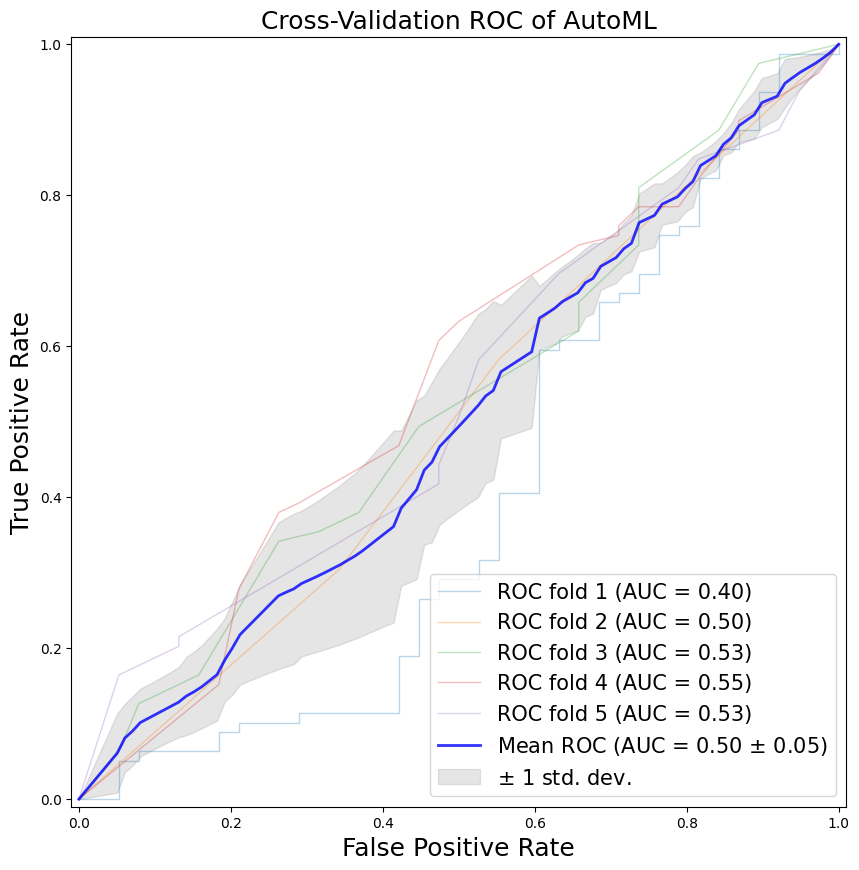

In [2]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.exceptions import ConvergenceWarning
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import roc_curve, auc, classification_report
from flaml import AutoML
import warnings

warnings.filterwarnings("ignore", category=ConvergenceWarning)

# Define the number of splits
num_splits = 5

tprs = []
aucs = []
mean_fpr = np.linspace(0, 1, 100)
plt.figure(figsize=(10, 10))

all_true_labels = []
all_predictions = []

for i in range(num_splits):
    # Load train and test sets
    train_file = f"train_{i}_with_embeddings.csv"
    test_file = f"test_{i}_with_embeddings.csv"
    train_set = pd.read_csv(os.path.join(DATAPATH, "train_test_splits", train_file))
    test_set = pd.read_csv(os.path.join(DATAPATH, "train_test_splits", test_file))
    
    # Extract features and target variables
    X_train = train_set["embeddings"].to_numpy()  # Convert to numpy array
    y_train = train_set["outcome"]
    X_test = test_set["embeddings"].to_numpy()  # Convert to numpy array
    y_test = test_set["outcome"]
    
    # Initialize AutoML for classification task
    modelAutoML = AutoML(task="classification", time_budget=600, logistic_max_iter=80000)

    # Fit AutoML model on the training data
    modelAutoML.fit(X_train, y_train, verbose=1)
    probas_ = modelAutoML.predict_proba(X_test)[:, 1]

    # Compute ROC curve and area under the curve
    fpr, tpr, thresholds = roc_curve(y_test, probas_)
    tprs.append(np.interp(mean_fpr, fpr, tpr))
    tprs[-1][0] = 0.0

    roc_auc = auc(fpr, tpr)
    aucs.append(roc_auc)
    plt.plot(fpr, tpr, lw=1, alpha=0.3, label=f'ROC fold {i + 1} (AUC = %0.2f)' % roc_auc)

    # Classification report
    y_pred = modelAutoML.predict(X_test)
    print(f"\nClassification Report for Fold {i + 1}:\n")
    print(classification_report(y_test, y_pred))

    # Accumulate true labels and predictions
    all_true_labels.extend(y_test)
    all_predictions.extend(y_pred)

# Calculate and print the average classification report
print("\nAverage Classification Report Across All Folds:\n")
print(classification_report(all_true_labels, all_predictions))

# Calculate mean ROC curve and AUC
mean_tpr = np.mean(tprs, axis=0)
mean_tpr[-1] = 1.0
mean_auc = auc(mean_fpr, mean_tpr)
std_auc = np.std(aucs)

# Plot mean ROC curve with boundaries
plt.plot(mean_fpr, mean_tpr, color='b', label=r'Mean ROC (AUC = %0.2f $\pm$ %0.2f)' % (mean_auc, std_auc), lw=2, alpha=.8)

std_tpr = np.std(tprs, axis=0)
tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
tprs_lower = np.maximum(mean_tpr - std_tpr, 0)

plt.fill_between(mean_fpr, tprs_lower, tprs_upper, color='grey', alpha=.2, label=r'$\pm$ 1 std. dev.')

plt.xlim([-0.01, 1.01])
plt.ylim([-0.01, 1.01])
plt.xlabel('False Positive Rate', fontsize=18)
plt.ylabel('True Positive Rate', fontsize=18)
plt.title('Cross-Validation ROC of AutoML', fontsize=18)
plt.legend(loc="lower right", prop={'size': 15})
plt.savefig(os.path.join(FIGUREPATH, "ersilia_AutoML_ersilia_600s.png"), dpi=300)
plt.show()


## Autogluon models

## Autogluon with padel descriptors

In [6]:
from autogluon.tabular import TabularDataset, TabularPredictor

No path specified. Models will be saved in: "AutogluonModels/ag-20240130_140949"
Presets specified: ['best_quality']
Stack configuration (auto_stack=True): num_stack_levels=1, num_bag_folds=8, num_bag_sets=1
Dynamic stacking is enabled (dynamic_stacking=True). AutoGluon will try to determine whether the input data is affected by stacked overfitting and enable or disable stacking as a consequence.
Detecting stacked overfitting by sub-fitting AutoGluon on the input data. That is, copies of AutoGluon will be sub-fit on subset(s) of the data. Then, the holdout validation data is used to detect stacked overfitting.
Sub-fit(s) time limit is: 50 seconds.
Starting holdout-based sub-fit for dynamic stacking. Context path is: AutogluonModels/ag-20240130_140949/ds_sub_fit/sub_fit_ho.
Beginning AutoGluon training ... Time limit = 12s
AutoGluon will save models to "AutogluonModels/ag-20240130_140949/ds_sub_fit/sub_fit_ho"
=================== System Info ===================
AutoGluon Version:  1.0.0


Average Classification Report Across All Folds:

              precision    recall  f1-score   support

           0       0.56      0.26      0.36       190
           1       0.72      0.90      0.80       395

    accuracy                           0.69       585
   macro avg       0.64      0.58      0.58       585
weighted avg       0.66      0.69      0.65       585



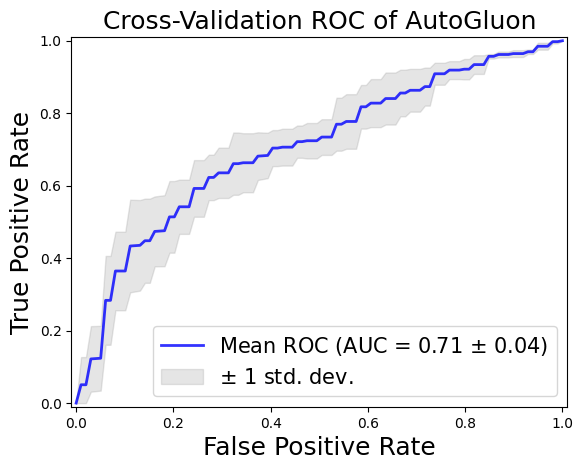

In [7]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from autogluon.tabular import TabularPredictor
from sklearn.metrics import roc_curve, auc, classification_report

# Set the path to your data and figure directories
DATAPATH = '../data'  # Change this to your data directory path
FIGUREPATH = '../figures'  # Change this to your figure directory path

# Initialize lists to store results
tprs = []
aucs = []
mean_fpr = np.linspace(0, 1, 100)
all_true_labels = []
all_predictions = []

# Load the PADEL Descriptors data
df = pd.read_csv(os.path.join(DATAPATH, "training_set_padel.csv"))

# Impute any missing values
for column in df.columns[3:]:
    column_mean = df[column].mean()
    df[column].fillna(column_mean, inplace=True)

# Change infinity values
df.replace([np.inf, -np.inf], 1e6, inplace=True)

# Iterate over the five folds
for i in range(5):
    train_file = f"train_{i}.csv"
    test_file = f"test_{i}.csv"
    train = pd.read_csv(os.path.join(DATAPATH, "train_test_splits", train_file))
    test = pd.read_csv(os.path.join(DATAPATH, "train_test_splits", test_file))
    
    # Merge train and test data with PADEL Descriptors data
    train_descs = pd.merge(train, df, on=['inchikey', "smiles", "outcome"], how='left')
    test_descs = pd.merge(test, df, on=['inchikey', "smiles", "outcome"], how='left')
    
    # Prepare train and test data
    y_train = train["outcome"]
    y_test = test["outcome"]
    X_train = train_descs.drop(columns=["inchikey", "outcome"])
    X_test = test_descs.drop(columns=["inchikey", "outcome"])
    
    # Train AutoGluon model with specified time limit and performance metric
    predictor = TabularPredictor(label='outcome').fit(train_data=train_descs, presets='best_quality', time_limit=600)
    
    # Make predictions
    y_pred_prob = predictor.predict_proba(X_test)
    y_pred = y_pred_prob[1]  # Probability of positive class
    y_pred_bin = predictor.predict(X_test)
    
    # Calculate ROC curve and AUC
    fpr, tpr, thresholds = roc_curve(y_test, y_pred)
    tprs.append(np.interp(mean_fpr, fpr, tpr))
    tprs[-1][0] = 0.0
    roc_auc = auc(fpr, tpr)
    aucs.append(roc_auc)
    
    # Accumulate true labels and predictions
    all_true_labels.extend(y_test)
    all_predictions.extend(y_pred_bin)

# Calculate and print the average classification report
print("\nAverage Classification Report Across All Folds:\n")
print(classification_report(all_true_labels, all_predictions))

# Calculate mean ROC curve and AUC
mean_tpr = np.mean(tprs, axis=0)
mean_tpr[-1] = 1.0
mean_auc = auc(mean_fpr, mean_tpr)
std_auc = np.std(aucs)

# Plot mean ROC curve with boundaries
plt.plot(mean_fpr, mean_tpr, color='b', label=r'Mean ROC (AUC = %0.2f $\pm$ %0.2f)' % (mean_auc, std_auc), lw=2, alpha=.8)

std_tpr = np.std(tprs, axis=0)
tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
tprs_lower = np.maximum(mean_tpr - std_tpr, 0)

plt.fill_between(mean_fpr, tprs_lower, tprs_upper, color='grey', alpha=.2, label=r'$\pm$ 1 std. dev.')

plt.xlim([-0.01, 1.01])
plt.ylim([-0.01, 1.01])
plt.xlabel('False Positive Rate', fontsize=18)
plt.ylabel('True Positive Rate', fontsize=18)
plt.title('Cross-Validation ROC of AutoGluon', fontsize=18)
plt.legend(loc="lower right", prop={'size': 15})
plt.savefig(os.path.join(FIGUREPATH, "padel_autogluon.png"))
plt.show()


## Autogluon with ersilia embeddings

No path specified. Models will be saved in: "AutogluonModels/ag-20240130_150744"
Presets specified: ['best_quality']
Stack configuration (auto_stack=True): num_stack_levels=1, num_bag_folds=8, num_bag_sets=1
Dynamic stacking is enabled (dynamic_stacking=True). AutoGluon will try to determine whether the input data is affected by stacked overfitting and enable or disable stacking as a consequence.
Detecting stacked overfitting by sub-fitting AutoGluon on the input data. That is, copies of AutoGluon will be sub-fit on subset(s) of the data. Then, the holdout validation data is used to detect stacked overfitting.
Sub-fit(s) time limit is: 60 seconds.
Starting holdout-based sub-fit for dynamic stacking. Context path is: AutogluonModels/ag-20240130_150744/ds_sub_fit/sub_fit_ho.
Beginning AutoGluon training ... Time limit = 15s
AutoGluon will save models to "AutogluonModels/ag-20240130_150744/ds_sub_fit/sub_fit_ho"
=================== System Info ===================
AutoGluon Version:  1.0.0


Average Classification Report Across All Folds:

              precision    recall  f1-score   support

           0       0.37      0.07      0.12       190
           1       0.68      0.94      0.79       395

    accuracy                           0.66       585
   macro avg       0.52      0.51      0.45       585
weighted avg       0.58      0.66      0.57       585



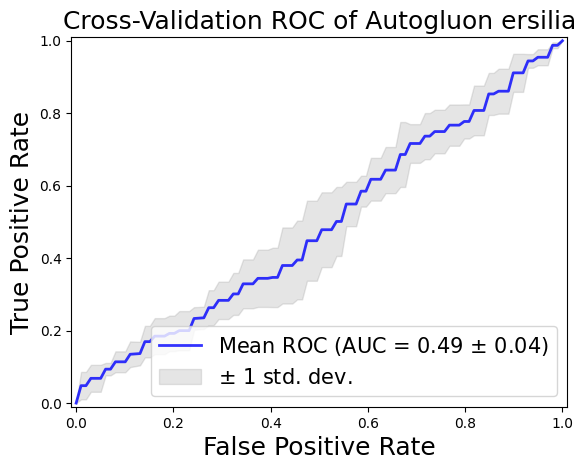

In [24]:
from autogluon.tabular import TabularPredictor
import os
import pandas as pd
import numpy as np
from sklearn.metrics import roc_curve, auc, classification_report
import matplotlib.pyplot as plt


tprs = []
aucs = []
mean_fpr = np.linspace(0, 1, 100)
all_true_labels = []
all_predictions = []

for i in range(5):
    train_file = f"train_{i}_with_embeddings.csv"
    test_file = f"test_{i}_with_embeddings.csv"
    train_set = pd.read_csv(os.path.join(DATAPATH, "train_test_splits", train_file))
    test_set = pd.read_csv(os.path.join(DATAPATH, "train_test_splits", test_file))
    
    # Extract embeddings and target variable
    X_train = train_set[['smiles', 'Unnamed: 0', 'embeddings']]  # Include the 'smiles' column
    y_train = train_set["outcome"]
    X_test = test_set[['smiles', 'Unnamed: 0', 'embeddings']]  # Include the 'smiles' column
    y_test = test_set["outcome"]

    # Fit the model using AutoGluon
    predictor = TabularPredictor(label='outcome').fit(train_data=train_set, time_limit=600, presets='best_quality')

    # Obtain predictions and true labels for the current fold
    y_pred_proba = predictor.predict_proba(pd.DataFrame(X_test))  # Get all predicted probabilities
    positive_class_col = predictor.positive_class  # Get the column name for positive class probabilities
    y_hat_proba = y_pred_proba[positive_class_col]  # Select the column for positive class probabilities
    y_pred = predictor.predict(pd.DataFrame(X_test))

    fpr, tpr, thresholds = roc_curve(y_test, y_hat_proba)
    tprs.append(np.interp(mean_fpr, fpr, tpr))
    tprs[-1][0] = 0.0
    roc_auc = auc(fpr, tpr)
    aucs.append(roc_auc)

    # Accumulate true labels and predictions
    all_true_labels.extend(y_test)
    all_predictions.extend(y_pred)

# Calculate and print the average classification report
print("\nAverage Classification Report Across All Folds:\n")
print(classification_report(all_true_labels, all_predictions))

# Calculate mean ROC curve and AUC
mean_tpr = np.mean(tprs, axis=0)
mean_tpr[-1] = 1.0
mean_auc = auc(mean_fpr, mean_tpr)
std_auc = np.std(aucs)

# Plot mean ROC curve with boundaries
plt.plot(mean_fpr, mean_tpr, color='b', label=r'Mean ROC (AUC = %0.2f $\pm$ %0.2f)' % (mean_auc, std_auc), lw=2, alpha=.8)

std_tpr = np.std(tprs, axis=0)
tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
tprs_lower = np.maximum(mean_tpr - std_tpr, 0)

plt.fill_between(mean_fpr, tprs_lower, tprs_upper, color='grey', alpha=.2, label=r'$\pm$ 1 std. dev.')

plt.xlim([-0.01, 1.01])
plt.ylim([-0.01, 1.01])
plt.xlabel('False Positive Rate', fontsize=18)
plt.ylabel('True Positive Rate', fontsize=18)
plt.title('Cross-Validation ROC of Autogluon ersilia', fontsize=18)
plt.legend(loc="lower right", prop={'size': 15})
plt.savefig(os.path.join(FIGUREPATH, "Ersilia_Autogluon_600s.png"), dpi=300)
plt.show()


## Autogluon with ersilia embeddings

No path specified. Models will be saved in: "AutogluonModels/ag-20240130_153816"
Presets specified: ['best_quality']
Stack configuration (auto_stack=True): num_stack_levels=1, num_bag_folds=8, num_bag_sets=1
Dynamic stacking is enabled (dynamic_stacking=True). AutoGluon will try to determine whether the input data is affected by stacked overfitting and enable or disable stacking as a consequence.
Detecting stacked overfitting by sub-fitting AutoGluon on the input data. That is, copies of AutoGluon will be sub-fit on subset(s) of the data. Then, the holdout validation data is used to detect stacked overfitting.
Sub-fit(s) time limit is: 60 seconds.
Starting holdout-based sub-fit for dynamic stacking. Context path is: AutogluonModels/ag-20240130_153816/ds_sub_fit/sub_fit_ho.
Beginning AutoGluon training ... Time limit = 15s
AutoGluon will save models to "AutogluonModels/ag-20240130_153816/ds_sub_fit/sub_fit_ho"
=================== System Info ===================
AutoGluon Version:  1.0.0


Average Classification Report Across All Folds:

              precision    recall  f1-score   support

           0       0.31      0.06      0.10       190
           1       0.67      0.93      0.78       395

    accuracy                           0.65       585
   macro avg       0.49      0.50      0.44       585
weighted avg       0.56      0.65      0.56       585



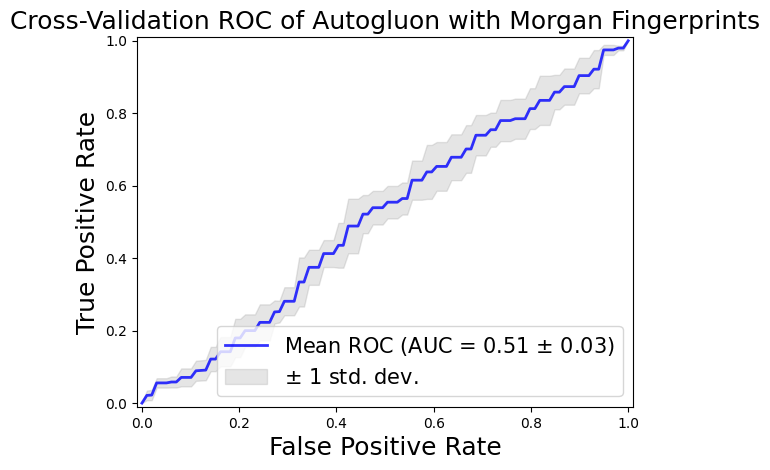

In [30]:
from autogluon.tabular import TabularPredictor
import os
import pandas as pd
import numpy as np
from sklearn.metrics import roc_curve, auc, classification_report
import matplotlib.pyplot as plt
from rdkit import Chem
from rdkit.Chem import AllChem

# Function to generate Morgan fingerprints from SMILES
def smiles_to_morgan(smiles):
    mol = Chem.MolFromSmiles(smiles)
    if mol is None:
        return None
    fp = AllChem.GetMorganFingerprintAsBitVect(mol, 2)  # Change radius as needed
    return fp

# Initialize lists for ROC curve plotting
tprs = []
aucs = []
mean_fpr = np.linspace(0, 1, 100)
all_true_labels = []
all_predictions = []

# Iterate over folds
for i in range(5):
    # Load train and test data for the current fold
    train_file = f"train_{i}_with_embeddings.csv"
    test_file = f"test_{i}_with_embeddings.csv"
    train_set = pd.read_csv(os.path.join(DATAPATH, "train_test_splits", train_file))
    test_set = pd.read_csv(os.path.join(DATAPATH, "train_test_splits", test_file))
    
    # Convert SMILES to Morgan fingerprints
    train_set['morgan_fp'] = train_set['smiles'].apply(smiles_to_morgan)
    test_set['morgan_fp'] = test_set['smiles'].apply(smiles_to_morgan)
    
    # Drop rows with None fingerprints
    train_set.dropna(subset=['morgan_fp'], inplace=True)
    test_set.dropna(subset=['morgan_fp'], inplace=True)
    
    # Extract features and target variable
    X_train = train_set[['morgan_fp', 'Unnamed: 0', 'embeddings', 'smiles']]
    y_train = train_set["outcome"]
    X_test = test_set[['morgan_fp', 'Unnamed: 0', 'embeddings', 'smiles']]
    y_test = test_set["outcome"]

    # Fit the model using AutoGluon
    predictor = TabularPredictor(label='outcome').fit(train_data=train_set, time_limit=600, presets='best_quality')

    # Obtain predictions and true labels for the current fold
    y_pred_proba = predictor.predict_proba(pd.DataFrame(X_test))  # Get all predicted probabilities
    positive_class_col = predictor.positive_class  # Get the column name for positive class probabilities
    y_hat_proba = y_pred_proba[positive_class_col]  # Select the column for positive class probabilities
    y_pred = predictor.predict(pd.DataFrame(X_test))

    # Compute ROC curve and AUC for the current fold
    fpr, tpr, thresholds = roc_curve(y_test, y_hat_proba)
    tprs.append(np.interp(mean_fpr, fpr, tpr))
    tprs[-1][0] = 0.0
    roc_auc = auc(fpr, tpr)
    aucs.append(roc_auc)

    # Accumulate true labels and predictions for overall evaluation
    all_true_labels.extend(y_test)
    all_predictions.extend(y_pred)

# Calculate and print the average classification report
print("\nAverage Classification Report Across All Folds:\n")
print(classification_report(all_true_labels, all_predictions))

# Calculate mean ROC curve and AUC
mean_tpr = np.mean(tprs, axis=0)
mean_tpr[-1] = 1.0
mean_auc = auc(mean_fpr, mean_tpr)
std_auc = np.std(aucs)

# Plot mean ROC curve with boundaries
plt.plot(mean_fpr, mean_tpr, color='b', label=r'Mean ROC (AUC = %0.2f $\pm$ %0.2f)' % (mean_auc, std_auc), lw=2, alpha=.8)

std_tpr = np.std(tprs, axis=0)
tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
tprs_lower = np.maximum(mean_tpr - std_tpr, 0)

plt.fill_between(mean_fpr, tprs_lower, tprs_upper, color='grey', alpha=.2, label=r'$\pm$ 1 std. dev.')

plt.xlim([-0.01, 1.01])
plt.ylim([-0.01, 1.01])
plt.xlabel('False Positive Rate', fontsize=18)
plt.ylabel('True Positive Rate', fontsize=18)
plt.title('Cross-Validation ROC of Autogluon with Morgan Fingerprints', fontsize=18)
plt.legend(loc="lower right", prop={'size': 15})
plt.savefig(os.path.join(FIGUREPATH, "Autogluon_Morgan_Fingerprints.png"), dpi=300)
plt.show()